# Analysis of Energy Consumption and Innovation Linkages (G7+China & Canada)

**Objective:** This notebook analyzes the relationship between energy consumption (primarily electricity) and various indicators of national innovation (patents, R&D, scientific output). It performs:
1.  **Data Collection:** Fetches relevant indicators from World Bank and OECD APIs for G7 countries + China.
2.  **Exploratory Data Analysis (EDA):** Visualizes trends and compares countries.
3.  **Correlation Analysis:** Examines relationships between energy and innovation metrics, focusing on Canada.
4.  **Comparative Analysis:** Compares Canada's performance against the United States.
5.  **Regression Modeling:** Models the statistical relationship between electricity consumption and innovation in Canada.
6.  **Policy Simulation:** Projects potential impacts of different energy policy scenarios on Canadian innovation and estimates related economic effects.

**Notebook Structure:**
1.  Setup & Configuration
2.  Data Collection Classes & Execution
3.  Helper Function Definitions
4.  Data Loading & Preparation
5.  Exploratory Data Analysis (G7+China)
6.  Canada Deep Dive & US Comparison (Correlation, Gaps, Regression)
7.  Advanced Policy Simulation (Canada)
8.  Conclusion



In [ ]:
#Imports & Configs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.linear_model import LinearRegression
from pathlib import Path
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from typing import List, Dict, Tuple, Optional, Union, Callable
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import requests
import io
import os
import time
import datetime
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import types
import traceback


base_dir = Path.cwd()
cache_dir = base_dir / "cache"
output_dir = base_dir / "output"
cache_dir.mkdir(exist_ok=True)
output_dir.mkdir(exist_ok=True)
print(f"cache dir: {cache_dir}")
print(f"output dir: {output_dir}")

DEFAULT_COUNTRIES = ["CAN", "USA", "GBR", "FRA", "DEU", "ITA", "JPN", "CHN",
                     "AUS", "KOR", "BRA", "MEX", "IND", "SAU", "NGA", "SWE",
                     "NOR", "ISR"]
COUNTRY_NAMES = {
    "CAN": "Canada", "USA": "United States", "GBR": "United Kingdom",
    "FRA": "France", "DEU": "Germany", "ITA": "Italy", "JPN": "Japan",
    "CHN": "China", "AUS": "Australia", "KOR": "South Korea", "BRA": "Brazil",
    "MEX": "Mexico", "IND": "India", "SAU": "Saudi Arabia", "NGA": "Nigeria",
    "SWE": "Sweden", "NOR": "Norway", "ISR": "Israel"
}

#plotting set
plt.style.use('fivethirtyeight')
sns.set_palette("viridis")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})
print("Setup complete")

cache dir: /content/cache
output dir: /content/output
Setup complete


In [ ]:
#API Client & Data Collector
class APIClient:
    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml,application/json;q=0.9,image/avif,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1'
        })
        retry_strategy = Retry(total=3, backoff_factor=1, status_forcelist=[429, 500, 502, 503, 504])
        adapter = HTTPAdapter(max_retries=retry_strategy)
        self.session.mount("http://", adapter)
        self.session.mount("https://", adapter)
        self.worldbank_base_url = "https://api.worldbank.org/v2"
        self.oecd_base_url = "https://stats.oecd.org/SDMX-JSON/data"

    def get_with_retry(self, url, params=None, headers=None):
        try:
            merged_headers = self.session.headers.copy()
            if headers:
                merged_headers.update(headers)
            response = self.session.get(url, params=params, headers=merged_headers, timeout=30)
            response.raise_for_status()
            return response
        except requests.exceptions.RequestException as e:
            print(f"API request failed: {url}")
            print(f"Error details: {str(e)}")
            raise


class DataCollector:
    def __init__(self):
        self.data_dir = "data"
        self.cache_dir = cache_dir
        self.api_client = APIClient()
        self.default_countries = DEFAULT_COUNTRIES
        self.country_names = COUNTRY_NAMES
        if not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir)
            print(f"Created cache directory: {self.cache_dir}")

        # indicators
        self.indicator_registry = {
            "gdp": {"id": "NY.GDP.MKTP.CD", "description": "GDP (current US$)", "primary_source": "worldbank"},
            "gdp_growth": {"id": "NY.GDP.MKTP.KD.ZG", "description": "GDP growth (annual %)", "primary_source": "worldbank"},
            "population": {"id": "SP.POP.TOTL", "description": "Population, total", "primary_source": "worldbank"},
            "rd_expenditure": {"id": "GB.XPD.RSDV.GD.ZS", "description": "Research and development expenditure (% of GDP)", "primary_source": "worldbank"},
            "patents_residents": {"id": "IP.PAT.RESD", "description": "Patent applications, residents", "primary_source": "worldbank"},
            "patents_nonresidents": {"id": "IP.PAT.NRES", "description": "Patent applications, nonresidents", "primary_source": "worldbank"},
            "researchers_in_rd": {"id": "SP.POP.SCIE.RD.P6", "description": "Researchers in R&D (per million people)", "primary_source": "worldbank"},
            "scientific_articles": {"id": "IP.JRN.ARTC.SC", "description": "Scientific and technical journal articles", "primary_source": "worldbank"},
            "high_tech_exports_pct": {"id": "TX.VAL.TECH.MF.ZS", "description": "High-technology exports (% of manufactured exports)", "primary_source": "worldbank"},
            "high_tech_exports_value": {"id": "TX.VAL.TECH.CD", "description": "High-technology exports (current US$)", "primary_source": "worldbank"},
            "firms_spending_on_rd": {"id": "GB.XPD.RSDV.GD.ZS", "description": "Research and development expenditure (% of GDP)", "primary_source": "worldbank"}, # Note: Same as rd_expenditure
            "electricity_production": {"id": "EG.ELC.FOSL.ZS", "description": "Electricity production from fossil fuels (% of total)", "primary_source": "worldbank"},
            "electricity_consumption_per_capita": {"id": "EG.USE.ELEC.KH.PC", "description": "Electric power consumption (kWh per capita)", "primary_source": "worldbank"},
            "renewable_electricity": {"id": "EG.ELC.RNEW.ZS", "description": "Renewable electricity output (% of total electricity output)", "primary_source": "worldbank"},
            "oil_production": {"id": "EG.EGY.PRIM.PP.KD", "description": "Energy production (kt of oil equivalent)", "primary_source": "worldbank"},
            "trade_pct_gdp": {"id": "NE.TRD.GNFS.ZS", "description": "Trade (% of GDP)", "primary_source": "worldbank"},
            "fdi_net_inflows": {"id": "BM.KLT.DINV.WD.GD.ZS", "description": "Foreign direct investment, net inflows (% of GDP)", "primary_source": "worldbank"},
            "gross_capital_formation": {"id": "NE.GDI.TOTL.ZS", "description": "Gross capital formation (% of GDP)", "primary_source": "worldbank"}
        }

    def download_file(self, url, filename):
        filepath = self.cache_dir / filename
        if not filepath.exists():
            try:
                print(f"Downloading file from {url}")
                response = self.api_client.get_with_retry(url)
                with open(filepath, 'wb') as f:
                    f.write(response.content)
                print(f"Successfully downloaded {filename}")
            except Exception as e:
                print(f"Failed to download {filename}: {str(e)}")
                raise
        else:
            print(f"Using existing file: {filename}")
        return filepath

    def save_to_cache(self, df, filename):
        filepath = self.cache_dir / filename
        df.to_csv(filepath, index=False)
        return filepath

    def load_from_cache(self, filename):
        filepath = self.cache_dir / filename
        if filepath.exists():
            try:
                df = pd.read_csv(filepath)
                if 'REF_DATE' in df.columns:
                    df['REF_DATE'] = pd.to_datetime(df['REF_DATE'], errors='coerce')
                print(f"Loaded data from cache: {filename}")
                return df
            except Exception as e:
                print(f"Failed to load cache file {filename}: {str(e)}")
        return None

    def get_worldbank_data(self, indicator, countries=None, start_year=1950, end_year=None):
        if end_year is None:
            end_year = datetime.datetime.now().year
        if countries is None:
            countries_list = self.default_countries
        elif isinstance(countries, str):
            countries_list = countries.split(",") if "," in countries else [countries]
        elif isinstance(countries, list):
            countries_list = countries
        else:
            raise ValueError(f"Unsupported countries parameter type: {type(countries)}")
        print(f"Fetching World Bank data for indicator: {indicator} for {len(countries_list)} countries from {start_year} to {end_year}") # Replaced logger

        MAX_COUNTRIES_PER_REQUEST = 8
        all_records = []
        country_batches = [countries_list[i:i + MAX_COUNTRIES_PER_REQUEST] for i in range(0, len(countries_list), MAX_COUNTRIES_PER_REQUEST)]
        for batch_num, country_batch in enumerate(country_batches):
            countries_param = ";".join(country_batch)
            if len(country_batches) > 1: print(f"Processing batch {batch_num + 1}/{len(country_batches)} with {len(country_batch)} countries") # Replaced logger

            try:
                url = f"{self.api_client.worldbank_base_url}/countries/{countries_param}/indicators/{indicator}"
                params = {"format": "json", "date": f"{start_year}:{end_year}", "per_page": 15000}
                response = self.api_client.get_with_retry(url, params=params)
                data = response.json()
                if isinstance(data, list) and len(data) > 1:
                    api_data = data[1]
                    for item in api_data:
                        if item['value'] is not None:
                            country_code = item['countryiso3code'] if 'countryiso3code' in item else item['country']['id']
                            country_name = self.country_names.get(country_code, item['country']['value'])
                            all_records.append({
                                'REF_DATE': pd.to_datetime(item['date'], format='%Y'),
                                'VALUE': float(item['value']),
                                'COUNTRY_CODE': country_code,
                                'COUNTRY': country_name
                            })
                elif isinstance(data, list) and len(data) > 0 and 'message' in data[0]:
                    api_message = data[0].get('message', [])
                    if api_message and isinstance(api_message, list) and len(api_message) > 0:
                         err_msg = api_message[0].get('value', 'Unknown World Bank API error')
                         print(f"World Bank API error for indicator {indicator}: {err_msg}")
                    else:
                         print(f"Unexpected World Bank API response structure for {indicator}: {data[0]}")

            except Exception as e:
                print(f"Failed to get data from World Bank for indicator {indicator} batch {batch_num + 1}: {str(e)}")

        if all_records:
            df = pd.DataFrame(all_records).sort_values(['COUNTRY', 'REF_DATE'])
            country_counts = df.groupby('COUNTRY').size().to_dict()
            countries_str = ", ".join([f"{country}: {count}" for country, count in country_counts.items()])
            print(f"Successfully retrieved World Bank data for {indicator}: {len(df)} total records.")
            return df
        else:
            print(f"No valid data records found in World Bank API response for {indicator}")
            return pd.DataFrame(columns=['REF_DATE', 'VALUE', 'COUNTRY_CODE', 'COUNTRY'])

    def get_oecd_data(self, dataset_id, countries=None, start_year=1950, end_year=None):
        if end_year is None:
            end_year = datetime.datetime.now().year

        if countries is None:
            countries_list = self.default_countries
        elif isinstance(countries, str):
            countries_list = countries.split(",") if "," in countries else [countries]
        elif isinstance(countries, list):
            countries_list = countries
        else:
            raise ValueError(f"Unsupported countries parameter type: {type(countries)}")

        countries_param = "+".join(countries_list)
        time_dimension = f"startTime={start_year}&endTime={end_year}"
        print(f"Fetching OECD data for dataset: {dataset_id} for {len(countries_list)} countries")

        try:
            filter_expression = countries_param
            url = f"{self.api_client.oecd_base_url}/{dataset_id}/{countries_param}.''.''.''/all?{time_dimension}"
            url_fallback = f"{self.api_client.oecd_base_url}/{dataset_id}/all/all?{time_dimension}&dimensionAtObservation=AllDimensions"

            print(f"Attempting OECD URL: {url}")
            headers = {'Accept': 'application/vnd.sdmx.data+json'}
            try:
                 response = self.api_client.get_with_retry(url, headers=headers)
            except requests.exceptions.RequestException as e:
                 print(f"Initial OECD URL failed ({e}), trying fallback URL: {url_fallback}")
                 response = self.api_client.get_with_retry(url_fallback, headers=headers)

            data = response.json()
            all_records = []
            if 'dataSets' in data and data['dataSets']:
                dataset_content = data['dataSets'][0]
                obs_list = dataset_content.get('observations', {})
                dimensions = data.get('structure', {}).get('dimensions', {}).get('observation', [])
                series_dims = data.get('structure', {}).get('dimensions', {}).get('series', [])
                attributes = data.get('structure', {}).get('attributes', {}).get('observation', [])
                key_order = [d['id'] for d in dimensions]
                country_dim_index = -1
                time_dim_index = -1
                value_index = -1

                for i, dim in enumerate(dimensions):
                    if dim.get('id') == 'LOCATION' or dim.get('role') == 'REF_AREA':
                        country_dim_index = i
                    if dim.get('id') == 'TIME_PERIOD' or dim.get('role') == 'TIME_PERIOD':
                        time_dim_index = i

                if country_dim_index == -1 or time_dim_index == -1:
                     print(f"Warning: Could not reliably identify Country or Time dimension for OECD {dataset_id}")
                     return pd.DataFrame(columns=['REF_DATE', 'VALUE', 'COUNTRY_CODE', 'COUNTRY'])

                for obs_key, values in obs_list.items():
                    if values is not None and len(values) > 0:
                        value = float(values[0])
                        key_parts = obs_key.split(':')
                        if len(key_parts) != len(dimensions):
                            print(f"Warning: Observation key length mismatch for {dataset_id}: {obs_key}, expected {len(dimensions)} parts.")
                            continue
                        try: # dim vals based on idx
                            country_code_idx = int(key_parts[country_dim_index])
                            time_val_idx = int(key_parts[time_dim_index])
                            country_struct = dimensions[country_dim_index]['values'][country_code_idx] #idx map to vals using
                            time_struct = dimensions[time_dim_index]['values'][time_val_idx]
                            country_code = country_struct.get('id', 'Unknown')
                            year_str = time_struct.get('id', time_struct.get('name', '0')) #diff time format handle

                            year = int(year_str[:4])
                            country_name = self.country_names.get(country_code, country_struct.get('name', country_code))

                            if start_year <= year <= end_year and country_code in countries_list: #filter
                                all_records.append({
                                    'REF_DATE': pd.to_datetime(str(year), format='%Y'),
                                    'VALUE': value,
                                    'COUNTRY_CODE': country_code,
                                    'COUNTRY': country_name
                                })

                        except (ValueError, IndexError) as parse_err:
                             print(f"Warning: Could not parse observation key/indices for {dataset_id}: {obs_key}, error: {parse_err}")
            if all_records:
                df = pd.DataFrame(all_records).sort_values(['COUNTRY', 'REF_DATE'])
                df = df.drop_duplicates(subset=['COUNTRY', 'REF_DATE'], keep='last')
                print(f"Successfully retrieved {len(df)} records from OECD for dataset {dataset_id}")
                return df
            else:
                print(f"No valid data found in OECD response for dataset {dataset_id}")
                return pd.DataFrame(columns=['REF_DATE', 'VALUE', 'COUNTRY_CODE', 'COUNTRY'])
        except Exception as e:
            print(f"Failed to get data from OECD for dataset {dataset_id}: {str(e)}")
            return pd.DataFrame(columns=['REF_DATE', 'VALUE', 'COUNTRY_CODE', 'COUNTRY'])


    def collect_all_indicators(self):
        results = {}
        print("\nStarting collection of all indicators...")
        for indicator_name, metadata in self.indicator_registry.items():
            cache_filename = f"g7_china_{indicator_name}.csv"
            cached_data = self.load_from_cache(cache_filename)
            if cached_data is not None:
                results[indicator_name] = cached_data
                print(f"Loaded {metadata['description']} from cache.")
                continue
            try:
                print(f"Collecting {metadata['description']} data from {metadata['primary_source']}...")
                df = pd.DataFrame()
                if metadata["primary_source"] == "worldbank":
                    df = self.get_worldbank_data(metadata["id"], countries=self.default_countries)
                elif metadata["primary_source"] == "oecd":
                    df = self.get_oecd_data(metadata["id"], countries=self.default_countries)
                else:
                    print(f"Unsupported data source: {metadata['primary_source']}")
                    continue
                if df is not None and not df.empty:
                    self.save_to_cache(df, cache_filename)
                    results[indicator_name] = df
                    min_year = df['REF_DATE'].min().year
                    max_year = df['REF_DATE'].max().year
                    print(f"-> Collected {metadata['description']}: {len(df)} records ({min_year}-{max_year}).")
                else:
                    print(f"-> Collection for {metadata['description']} returned no data.")
            except Exception as e:
                print(f"-> Failed to collect {metadata['description']}: {str(e)}")
        print("\nData collection completed.")
        return results

    def calculate_electricity_consumption(self):
        print("Calculating total electricity consumption...")
        try:
            elec_pc_cache = "g7_china_electricity_consumption_per_capita.csv"
            pop_cache = "g7_china_population.csv"
            target_cache = "g7_china_electricity_consumption.csv"

            elec_per_capita_df = self.load_from_cache(elec_pc_cache)
            if elec_per_capita_df is None:
                print(f"Cache miss for {elec_pc_cache}, attempting to fetch.")
                elec_pc_indicator = self.indicator_registry['electricity_consumption_per_capita']['id']
                elec_per_capita_df = self.get_worldbank_data(elec_pc_indicator, countries=self.default_countries)
                if elec_per_capita_df is not None and not elec_per_capita_df.empty:
                    self.save_to_cache(elec_per_capita_df, elec_pc_cache)
                else:
                     raise FileNotFoundError(f"Could not fetch or load {elec_pc_cache}")

            pop_df = self.load_from_cache(pop_cache)
            if pop_df is None:
                print(f"Cache miss for {pop_cache}, attempting to fetch.")
                pop_indicator = self.indicator_registry['population']['id']
                pop_df = self.get_worldbank_data(pop_indicator, countries=self.default_countries)
                if pop_df is not None and not pop_df.empty:
                    self.save_to_cache(pop_df, pop_cache)
                else:
                     raise FileNotFoundError(f"Could not fetch or load {pop_cache}")
            if 'VALUE' not in elec_per_capita_df.columns or 'VALUE' not in pop_df.columns:
                raise ValueError("Required 'VALUE' column missing in input dataframes for electricity calculation.")
            if 'REF_DATE' not in elec_per_capita_df.columns or 'REF_DATE' not in pop_df.columns:
                raise ValueError("Required 'REF_DATE' column missing in input dataframes for electricity calculation.")

            # Merge datasets
            merged_df = pd.merge(
                elec_per_capita_df[['REF_DATE', 'COUNTRY', 'COUNTRY_CODE', 'VALUE']],
                pop_df[['REF_DATE', 'COUNTRY', 'COUNTRY_CODE', 'VALUE']],
                on=['REF_DATE', 'COUNTRY', 'COUNTRY_CODE'],
                suffixes=('_pc', '_pop'),
                how='inner'
            )
            if merged_df.empty:
                 print("Warning: No matching data found between electricity per capita and population.")
                 return pd.DataFrame(columns=['REF_DATE', 'VALUE', 'COUNTRY_CODE', 'COUNTRY'])

            #Calc tot_cons (kWh per capita * pop / 1e9 conv. to TWh)
            merged_df['VALUE'] = (merged_df['VALUE_pc'] * merged_df['VALUE_pop']) / 1e9
            result_df = merged_df[['REF_DATE', 'VALUE', 'COUNTRY_CODE', 'COUNTRY']].copy()
            result_df = result_df.dropna(subset=['VALUE'])
            self.save_to_cache(result_df, target_cache)
            print(f"Successfully calculated and cached total electricity consumption ({len(result_df)} records).")
            return result_df
        except Exception as e:
            print(f"Failed to calculate electricity consumption: {str(e)}")
            raise

In [ ]:
# Execute Data Collection
print("--- Data Collection ---")
collector = DataCollector()
all_data = {}
calculation_successful = False
try:
    all_data = collector.collect_all_indicators()
    print("\nIndicator collection finished.")
except Exception as e:
    print(f"\nAn error occurred during indicator collection: {e}")
try:
    elec_pc_cache_path = cache_dir / "g7_china_electricity_consumption_per_capita.csv"
    pop_cache_path = cache_dir / "g7_china_population.csv"
    elec_cache_path = cache_dir / "g7_china_electricity_consumption.csv"

    if elec_pc_cache_path.exists() and pop_cache_path.exists():
        print("Attempting electricity consumption calculation (using cached dependencies if possible)...")
        derived_electricity = collector.calculate_electricity_consumption()
        if derived_electricity is not None and not derived_electricity.empty:
            all_data['electricity_consumption'] = derived_electricity
            calculation_successful = True
            print("Electricity consumption calculation successful.")
        else:
            print("Electricity consumption calculation yielded no data.")
    elif elec_cache_path.exists():
        print(f"Loading existing calculated electricity consumption from {elec_cache_path}...")
        derived_electricity = collector.load_from_cache(elec_cache_path.name)
        if derived_electricity is not None and not derived_electricity.empty:
            all_data['electricity_consumption'] = derived_electricity
            calculation_successful = True
            print("Successfully loaded pre-calc electricity consumption.")
        else:
             print("Failed to load pre-calc electricity consumption from cache.")
    else:
         print("Skipping electricity consumption calc: Missing either (per capita electricity or population).")
except Exception as e:
    print(f"\nAn error occurred during electricity consumption calc/loading: {e}")

print("\n--- Data Collection Summary ---")
print(f"Found {len(all_data)} datasets in cache:")
loaded_files = list(cache_dir.glob("*.csv"))
if loaded_files:
    print("Files in cache dir:")
    for f in loaded_files:
        print(f"  - {f.name}")
else:
    print("Cache dir is empty.")

essential_files = [
    "g7_china_gdp.csv", "g7_china_patents_residents.csv", "g7_china_rd_expenditure.csv",
    "g7_china_electricity_consumption.csv", "g7_china_population.csv",
    "g7_china_scientific_articles.csv", "g7_china_researchers_in_rd.csv"
]
missing_essential = [f for f in essential_files if not (cache_dir / f).exists()]
if missing_essential:
    print("\nWarning: The following data files missing from cache:")
    for f in missing_essential:
        print(f"  - {f}")
else:

--- Data Collection ---

Starting collection of all indicators...
Fetching World Bank data for indicator: NY.GDP.MKTP.CD for 18 countries from 1950 to 2025
Processing batch 1/3 with 8 countries
Processing batch 2/3 with 8 countries
Processing batch 3/3 with 2 countries
Successfully retrieved World Bank data for NY.GDP.MKTP.CD: 1152 total records.
-> Collected GDP (current US$): 1152 records (1960-2023).
Fetching World Bank data for indicator: NY.GDP.MKTP.KD.ZG for 18 countries from 1950 to 2025
Processing batch 1/3 with 8 countries
Processing batch 2/3 with 8 countries
Processing batch 3/3 with 2 countries
Successfully retrieved World Bank data for NY.GDP.MKTP.KD.ZG: 1134 total records.
-> Collected GDP growth (annual %): 1134 records (1961-2023).
Fetching World Bank data for indicator: SP.POP.TOTL for 18 countries from 1950 to 2025
Processing batch 1/3 with 8 countries
Processing batch 2/3 with 8 countries
Processing batch 3/3 with 2 countries
Successfully retrieved World Bank data fo

In [ ]:
# Analysis Helper Functions
print("--- Helper Functions ---")
def load_data(filename: str) -> pd.DataFrame:
    """Loads data from cache, handling dates and validation."""
    filepath = cache_dir / filename
    if not filepath.exists():
        raise FileNotFoundError(f"Data file not found in cache: {filepath}")
    try:
        df = pd.read_csv(filepath)
        if 'REF_DATE' in df.columns:
            df['REF_DATE'] = pd.to_datetime(df['REF_DATE'], errors='coerce')
            original_len = len(df)
            df = df.dropna(subset=['REF_DATE'])
            if len(df) < original_len:
                print(f"Warning: Dropped {original_len - len(df)} rows from {filename} due to invalid dates.")
        if 'VALUE' not in df.columns:
            raise ValueError(f"File {filename} is missing the required 'VALUE' column")
        missing_values = df['VALUE'].isna().sum()
        if missing_values > 0:
            warnings.warn(f"File {filename} contains {missing_values} missing 'VALUE' entries.")
        df['VALUE'] = pd.to_numeric(df['VALUE'], errors='coerce')
        df = df.dropna(subset=['VALUE'])
        return df
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        raise

def validate_date_range(df: pd.DataFrame, min_year: int = 1960, max_year: int = datetime.datetime.now().year) -> bool:
    """Checks if the DataFrame's date range is reasonable."""
    if 'REF_DATE' not in df.columns or df['REF_DATE'].isnull().all():
        return False
    try:
        years = df['REF_DATE'].dt.year
        return (years.min() <= max_year) and (years.max() >= min_year)
    except:
        return False

def get_common_years(dataframes: List[pd.DataFrame]) -> List[int]:
    """Finds sorted list of common years across multiple DataFrames."""
    if not dataframes:
        return []
    valid_dfs = [df for df in dataframes if df is not None and not df.empty and 'REF_DATE' in df.columns and not df['REF_DATE'].isnull().all()]
    if not valid_dfs:
        return []
    try:
        year_sets = []
        for df in valid_dfs:
            years = df.dropna(subset=['REF_DATE'])['REF_DATE'].dt.year
            if not years.empty:
                year_sets.append(set(years))

        if not year_sets:
            return []
        common_years = year_sets[0]
        for years in year_sets[1:]:
            common_years &= years
        return sorted(list(common_years))
    except Exception as e:
        print(f"Error finding common years: {e}")
        return []

def normalize_by_population(df: pd.DataFrame, population_df: pd.DataFrame,
                           country: Optional[str] = None) -> pd.DataFrame:
    """Calculates per capita values (per mill people)."""
    result_df = df.copy()
    pop_data = population_df.copy()
    if country and 'COUNTRY' in pop_data.columns:
        pop_data = pop_data[pop_data['COUNTRY'] == country]
    if country and 'COUNTRY' in result_df.columns:
         result_df = result_df[result_df['COUNTRY'] == country]
    if 'VALUE' not in result_df.columns or 'VALUE' not in pop_data.columns:
         raise ValueError("Missing 'VALUE' column in input dataframes for normalization.")
    if 'REF_DATE' not in result_df.columns or 'REF_DATE' not in pop_data.columns:
         raise ValueError("Missing 'REF_DATE' column in input dataframes for normalization.")

    merge_cols = ['REF_DATE']
    if 'COUNTRY' in result_df.columns and 'COUNTRY' in pop_data.columns:
        merge_cols.append('COUNTRY')
    elif 'COUNTRY' in result_df.columns and len(result_df['COUNTRY'].unique()) > 1:
        warnings.warn("Indicator DF has multiple countries but Population DF does not; normalization may be incorrect if not pre-filtered.")
    elif 'COUNTRY' in pop_data.columns and len(pop_data['COUNTRY'].unique()) > 1:
         warnings.warn("Population DF has multiple countries but Indicator DF does not; normalization may be incorrect if not pre-filtered.")

    result_df = result_df.rename(columns={'VALUE': 'VALUE_indicator'})
    pop_data = pop_data.rename(columns={'VALUE': 'VALUE_pop'})
    for col in merge_cols:
        if col not in result_df.columns or col not in pop_data.columns:
            raise ValueError(f"Missing merge column '{col}' in one of the dataframes.")

    merged = pd.merge(result_df, pop_data[merge_cols + ['VALUE_pop']], on=merge_cols, how='inner')
    if merged.empty:
        warnings.warn("Normalization by population resulted in empty DataFrame (no matching dates/countries).")
        output_cols = list(df.columns)
        if 'VALUE' not in output_cols:
            output_cols.append('VALUE')
        return pd.DataFrame(columns=output_cols)

    merged['VALUE_indicator'] = pd.to_numeric(merged['VALUE_indicator'], errors='coerce')
    merged['VALUE_pop'] = pd.to_numeric(merged['VALUE_pop'], errors='coerce')
    merged = merged.dropna(subset=['VALUE_indicator', 'VALUE_pop'])
    merged = merged[merged['VALUE_pop'].abs() > 1e-6] #div by 0 handle
    merged['VALUE'] = merged['VALUE_indicator'] / merged['VALUE_pop'] * 1_000_000  #per mill ppl

    #reconst. org cols + val
    cols_to_keep = [col for col in df.columns if col != 'VALUE'] + ['VALUE']
    final_cols = [col for col in cols_to_keep if col in merged.columns]

    return merged[final_cols].reset_index(drop=True)


def plot_trend(df: pd.DataFrame, title: str, y_label: str,
               countries: Optional[List[str]] = None,
               save_filename: Optional[str] = None,
               add_ci: bool = False,
               trend_line: bool = False) -> None:
    """Generates and saves/shows a trend plot for one or more countries"""
    if df is None or df.empty:
        print(f"Warning: Skipping plot '{title}' due to empty or None DataFrame.")
        return

    #req cols check
    if 'REF_DATE' not in df.columns or 'VALUE' not in df.columns:
        print(f"Warning: Skipping plot '{title}'. Missing 'REF_DATE' or 'VALUE' column.")
        return
    df_cleaned = df.dropna(subset=['REF_DATE', 'VALUE'])
    if df_cleaned.empty:
        print(f"Warning: Skipping plot '{title}' due to no valid data after dropping NaNs.")
        return

    fig, ax = plt.subplots(figsize=(14, 8))
    cmap = plt.get_cmap('tab10')
    distinct_colors = cmap(np.linspace(0, 1, 10))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']

    legend_handles = []
    legend_labels = []
    #multi-country plot
    if 'COUNTRY' in df_cleaned.columns and countries:
        plotted_countries = []
        for i, country in enumerate(countries):
            country_data = df_cleaned[df_cleaned['COUNTRY'] == country].sort_values('REF_DATE').copy()

            if country_data.empty or len(country_data) < 2:
                print(f"Debug: Skipping {country} - not enough data points ({len(country_data)})")
                continue

            color_idx = i % len(distinct_colors)
            marker_idx = i % len(markers)
            line = ax.plot(country_data['REF_DATE'], country_data['VALUE'],
                           marker=markers[marker_idx], linewidth=1.8,
                           color=distinct_colors[color_idx], markersize=6)
            legend_handles.append(line[0])
            legend_labels.append(country)
            plotted_countries.append(country)

            #trend calc
            if trend_line and len(country_data) > 1:
                try:
                    x_ord = country_data['REF_DATE'].map(datetime.datetime.toordinal).values
                    y = country_data['VALUE'].values
                    #dims check
                    if x_ord.ndim == 1 and y.ndim == 1 and len(x_ord) == len(y):
                        z = np.polyfit(x_ord, y, 1)
                        p = np.poly1d(z)
                        trend_y = p(x_ord) #calc trend
                        ax.plot(country_data['REF_DATE'], trend_y, linestyle='--',
                                color=distinct_colors[color_idx], alpha=0.7, linewidth=1.5,
                                label='_nolegend_')
                    else:
                         print(f"Warning: Trend line skipped for {country} due to unexpected data dimensions after cleaning.")
                except Exception as e:
                    print(f"Could not compute trend line for {country}: {e}")

            #Conf Inter Band calc
            if add_ci and len(country_data) >= 3:
                 try:
                     y_series_numeric = pd.to_numeric(country_data['VALUE'], errors='coerce').dropna()
                     if len(y_series_numeric) >= 3:
                          #simple interp
                          y_series_interp = country_data.set_index('REF_DATE')['VALUE'].interpolate(method='linear').ffill().bfill()

                          if not y_series_interp.empty:
                              window = min(5, max(3, len(y_series_interp) // 3))
                              y_mean = y_series_interp.rolling(window=window, center=True, min_periods=1).mean()
                              y_std = y_series_interp.rolling(window=window, center=True, min_periods=1).std().fillna(0)
                              lower_bound = (y_mean - y_std).clip(lower=0) #non-neg handle
                              upper_bound = y_mean + y_std
                              x_dates = country_data['REF_DATE'].values
                              y1 = lower_bound.reindex(country_data['REF_DATE']).values
                              y2 = upper_bound.reindex(country_data['REF_DATE']).values

                              #dims and NaN check
                              if x_dates.ndim == 1 and y1.ndim == 1 and y2.ndim == 1 and len(x_dates) == len(y1) and not np.isnan(y1).all() and not np.isnan(y2).all():
                                  ax.fill_between(x_dates, y1, y2,
                                                  alpha=0.15, color=distinct_colors[color_idx],
                                                  label='_nolegend_')
                              else:
                                   print(f"Warning: CI band skipped for {country} due to dimension/length/NaN mismatch.")
                          else:
                               print(f"Warning: CI band skipped for {country}, no data after interpolation.")
                     else:
                          print(f"Warning: CI band skipped for {country}, less than 3 numeric data points.")
                 except Exception as e:
                    print(f"Could not compute CI band for {country}: {e}")
        if not plotted_countries:
             print(f"Warning: No countries found with sufficient data in the provided list for plot '{title}'.")
             plt.close(fig)
             return

    elif not df_cleaned.empty:
         df_sorted = df_cleaned.sort_values('REF_DATE')
         if len(df_sorted) > 1:
             ax.plot(df_sorted['REF_DATE'], df_sorted['VALUE'], marker='o', linewidth=1.8)
         elif len(df_sorted) == 1:
              ax.scatter(df_sorted['REF_DATE'], df_sorted['VALUE'], marker='o', s=50)
         else:
             print(f"Warning: No data points to plot for '{title}' after cleaning.")
             plt.close(fig)
             return
    ax.set_title(title, fontsize=18)
    ax.set_ylabel(y_label, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5)

    if legend_handles:
        ax.legend(handles=legend_handles, labels=legend_labels, fontsize=12, framealpha=0.8, edgecolor='grey', loc='best')
    plt.tight_layout()
    if save_filename:
        save_path = output_dir / save_filename
        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Failed to save plot {save_path}: {e}")
    plt.show()


def normalize_by_gdp(indicator_df: pd.DataFrame, gdp_df: pd.DataFrame,
                    countries: Optional[List[str]] = None) -> pd.DataFrame:
    """Normalizes an indicator by GDP."""
    if indicator_df.empty or gdp_df.empty:
         warnings.warn("One or both input dataframes for GDP normalization are empty.")
         return pd.DataFrame(columns=['REF_DATE', 'COUNTRY', 'VALUE'] if 'COUNTRY' in indicator_df.columns else ['REF_DATE', 'VALUE'])

    indicator_df = indicator_df.rename(columns={'VALUE': 'VALUE_indicator'})
    gdp_df = gdp_df.rename(columns={'VALUE': 'VALUE_gdp'})

    merge_cols = ['REF_DATE']
    has_country_ind = 'COUNTRY' in indicator_df.columns
    has_country_gdp = 'COUNTRY' in gdp_df.columns

    if has_country_ind and has_country_gdp:
        merge_cols.append('COUNTRY')
    elif has_country_ind and not has_country_gdp and len(indicator_df['COUNTRY'].unique())==1:
         warnings.warn("GDP data missing COUNTRY column, assuming it matches the single country in indicator data.")
    elif not has_country_ind and has_country_gdp and len(gdp_df['COUNTRY'].unique())==1:
         warnings.warn("Indicator data missing COUNTRY column, assuming it matches the single country in GDP data.")
    elif has_country_ind != has_country_gdp:
         raise ValueError("Cannot merge for GDP normalization: COUNTRY column mismatch between dataframes.")

    for col in merge_cols:
        if col not in indicator_df.columns or col not in gdp_df.columns:
             raise ValueError(f"Missing merge column '{col}' for GDP normalization.")


    merged_df = pd.merge(
        indicator_df,
        gdp_df[merge_cols + ['VALUE_gdp']],
        on=merge_cols,
        how='inner'
    )

    if merged_df.empty:
        warnings.warn("No matching data found when normalizing by GDP.")
        return pd.DataFrame(columns=['REF_DATE', 'COUNTRY', 'VALUE'] if has_country_ind else ['REF_DATE', 'VALUE'])

    merged_df['VALUE_indicator'] = pd.to_numeric(merged_df['VALUE_indicator'], errors='coerce')
    merged_df['VALUE_gdp'] = pd.to_numeric(merged_df['VALUE_gdp'], errors='coerce')
    merged_df = merged_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['VALUE_indicator', 'VALUE_gdp'])


    merged_df = merged_df[merged_df['VALUE_gdp'].abs() > 1e-9]
    merged_df['VALUE'] = merged_df['VALUE_indicator'] / merged_df['VALUE_gdp']

    if countries and 'COUNTRY' in merged_df.columns:
        merged_df = merged_df[merged_df['COUNTRY'].isin(countries)]

    if 'COUNTRY' in merged_df.columns:
        return merged_df[['REF_DATE', 'COUNTRY', 'VALUE']].copy().reset_index(drop=True)
    else:
        return merged_df[['REF_DATE', 'VALUE']].copy().reset_index(drop=True)

def robust_correlation_analysis(dataframes: List[pd.DataFrame],
                               names: List[str],
                               min_periods: int = 5,
                               year_range: Optional[Tuple[int, int]] = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Calculate correlation matrix with robust handling of missing data and year range."""
    if len(dataframes) != len(names): raise ValueError("Number of dataframes and names must match")
    if len(dataframes) < 2: raise ValueError("Need at least two dataframes for correlations")

    processed_dfs = []
    for i, df in enumerate(dataframes):
        if df is None or df.empty:
            print(f"Warning: DataFrame for '{names[i]}' is empty or None, skipping.")
            continue
        if 'REF_DATE' not in df.columns or 'VALUE' not in df.columns:
            print(f"Warning: DataFrame for '{names[i]}' missing required columns, skipping.")
            continue

        df = df.copy()
        df = df.dropna(subset=['REF_DATE', 'VALUE'])
        df['VALUE'] = pd.to_numeric(df['VALUE'], errors='coerce')
        df = df.dropna(subset=['VALUE'])
        if df.empty:
            print(f"Warning: DataFrame for '{names[i]}' is empty after cleaning, skipping.")
            continue
        if year_range:
            start_year, end_year = year_range
            df = df[(df['REF_DATE'].dt.year >= start_year) & (df['REF_DATE'].dt.year <= end_year)]
        if not df.empty:
             #yr groupby, mean multi vals per yr
             df['Year'] = df['REF_DATE'].dt.year
             yearly_data = df.groupby('Year')['VALUE'].mean().reset_index()
             yearly_data = yearly_data.rename(columns={'VALUE': names[i]})
             processed_dfs.append(yearly_data.set_index('Year'))
        else:
             print(f"Warning: DataFrame for '{names[i]}' has no data within the specified year range, skipping.")

    if len(processed_dfs) < 2:
        raise ValueError("Less than two valid datasets remain after processing for correlation.")

    combined_df = pd.concat(processed_dfs, axis=1, join='outer') #comb. dfs w/ outer join, calc pairwise corr
    correlation_matrix = combined_df.corr(method='pearson', min_periods=min_periods) #calc corr matrx

    return correlation_matrix, combined_df

def test_granger_causality(df1: pd.DataFrame, df2: pd.DataFrame, max_lag: int = 5) -> Optional[Dict]:
    """Test for Granger causality between two time series."""
    if df1 is None or df1.empty or df2 is None or df2.empty:
         print("Warning: Granger test requires non-empty input dataframes.")
         return None
    if 'VALUE' not in df1.columns or 'VALUE' not in df2.columns:
         print("Warning: Granger test requires 'VALUE' column in both dataframes.")
         return None
    if 'REF_DATE' not in df1.columns or 'REF_DATE' not in df2.columns:
         print("Warning: Granger test requires 'REF_DATE' column in both dataframes.")
         return None

    try:
        df1_clean = df1[['REF_DATE', 'VALUE']].copy()
        df1_clean['VALUE'] = pd.to_numeric(df1_clean['VALUE'], errors='coerce')
        df1_clean = df1_clean.dropna()
        df2_clean = df2[['REF_DATE', 'VALUE']].copy()
        df2_clean['VALUE'] = pd.to_numeric(df2_clean['VALUE'], errors='coerce')
        df2_clean = df2_clean.dropna()

        if df1_clean.empty or df2_clean.empty:
             print("Warning: Granger test - one or both series empty after cleaning.")
             return None

        merged = pd.merge(
            df1_clean.rename(columns={'VALUE':'VALUE_1'}),
            df2_clean.rename(columns={'VALUE':'VALUE_2'}),
            on='REF_DATE',
            how='inner'
        ).sort_values('REF_DATE')
        merged = merged.dropna()
        if len(merged) < max_lag + 3:
            print(f"Warning: Not enough overlapping observations ({len(merged)}) for Granger test with lag {max_lag}.")
            return None

        values = merged[['VALUE_1', 'VALUE_2']].values
        #stationarity check
        adf_test1 = sm.tsa.stattools.adfuller(values[:, 0])
        adf_test2 = sm.tsa.stattools.adfuller(values[:, 1])
        print(f"ADF p-value (Series 1): {adf_test1[1]}, (Series 2): {adf_test2[1]}")
        if adf_test1[1] > 0.05 or adf_test2[1] > 0.05:
            warnings.warn("One or both series may be non-stationary. Granger results might be spurious.")
        result = grangercausalitytests(values, maxlag=max_lag, verbose=False)
        return result
    except Exception as e:
        warnings.warn(f"Granger causality test failed: {str(e)}")
        return None

def create_regression_model(X_df: pd.DataFrame, y_df: pd.DataFrame,
                         lag_years: int = 0) -> Tuple[Optional[sm.regression.linear_model.RegressionResultsWrapper], pd.DataFrame]:
    """Create an OLS regression model with optional lag."""
    if X_df is None or X_df.empty or y_df is None or y_df.empty:
        raise ValueError("Input dataframes cannot be empty or None")
    if 'VALUE' not in X_df.columns or 'VALUE' not in y_df.columns:
        raise ValueError("Input dataframes must contain a 'VALUE' column")
    if 'REF_DATE' not in X_df.columns or 'REF_DATE' not in y_df.columns:
        raise ValueError("Input dataframes must contain a 'REF_DATE' column")

    X_data = X_df[['REF_DATE', 'VALUE']].copy()
    X_data['VALUE'] = pd.to_numeric(X_data['VALUE'], errors='coerce')
    X_data = X_data.replace([np.inf, -np.inf], np.nan).dropna().rename(columns={'VALUE': 'VALUE_X'})

    y_data = y_df[['REF_DATE', 'VALUE']].copy()
    y_data['VALUE'] = pd.to_numeric(y_data['VALUE'], errors='coerce')
    y_data = y_data.replace([np.inf, -np.inf], np.nan).dropna().rename(columns={'VALUE': 'VALUE_y'})

    if X_data.empty or y_data.empty:
        print("Warning: dfs are empty after pre regression clean.")
        return None, pd.DataFrame()

    # lag app
    if lag_years > 0:
        X_data['REF_DATE'] = X_data['REF_DATE'] + pd.DateOffset(years=lag_years)
    elif lag_years < 0:
         warnings.warn(f"Negative lag ({lag_years}) applied to Y variable.")
         y_data['REF_DATE'] = y_data['REF_DATE'] + pd.DateOffset(years=abs(lag_years))

    merged = pd.merge(X_data, y_data, on='REF_DATE', how='inner').dropna()

    if merged.empty:
        print(f"Warning: No overlapping data points found for regression (lag={lag_years}).")
        return None, pd.DataFrame()
    if len(merged) < 5:
        print(f"Warning: Only {len(merged)} overlapping data points. Regression may be unreliable.")
        return None, pd.DataFrame()

    X = merged['VALUE_X'].values
    y = merged['VALUE_y'].values
    X_with_const = sm.add_constant(X)
    try:
        model = sm.OLS(y, X_with_const).fit()
        return model, merged
    except Exception as e:
        print(f"Error fitting OLS model: {e}")
        return None, merged

def extend_time_series(df: pd.DataFrame, target_year: int = 2022,
                     method: str = 'linear', country_col: Optional[str] = 'COUNTRY') -> pd.DataFrame:
    """Extends time series data up to target_year using simple forecasting methods."""
    if df is None or df.empty:
         warnings.warn("Input DataFrame for extension is empty or None.")
         return pd.DataFrame(columns=df.columns if df is not None else [])

    result_dfs = []
    has_country_col = country_col is not None and country_col in df.columns
    if has_country_col:
        df_grouped = df.dropna(subset=[country_col])
        grouped = df_grouped.groupby(country_col)
        group_keys = df_grouped[country_col].unique()
    else:
        grouped = [(None, df)]
        group_keys = [None]

    df['VALUE'] = pd.to_numeric(df['VALUE'], errors='coerce')
    for group_key in group_keys:
        country_data = grouped.get_group(group_key) if group_key is not None else df
        #NaN sort & drop in cols for base forecast
        country_data = country_data.sort_values('REF_DATE').dropna(subset=['REF_DATE', 'VALUE'])
        if country_data.empty:
            #append empty df with org cols if grp empty
            result_dfs.append(pd.DataFrame(columns=df.columns))
            continue
        last_date = country_data['REF_DATE'].max()
        last_year = last_date.year
        if last_year >= target_year:
            result_dfs.append(country_data)
            continue

        years_to_forecast = target_year - last_year
        forecast_dates = pd.to_datetime([f'{last_year + i + 1}-01-01' for i in range(years_to_forecast)])
        forecast_df = pd.DataFrame({'REF_DATE': forecast_dates})
        if group_key is not None:
            forecast_df[country_col] = group_key

        historical_years = min(15, len(country_data))
        forecast_base_data = country_data.iloc[-historical_years:]

        forecast_values = np.full(years_to_forecast, np.nan)

        if len(forecast_base_data) < 2:
            method = 'mean'
            print(f"Warning: Less than 2 data points for group {group_key}, using mean forecast.")

        try:
            if method == 'linear' and len(forecast_base_data) >= 2:
                X_ord = forecast_base_data['REF_DATE'].map(datetime.datetime.toordinal).values.reshape(-1, 1)
                y = forecast_base_data['VALUE'].values
                model = LinearRegression()
                model.fit(X_ord, y)
                X_forecast_ord = forecast_df['REF_DATE'].map(datetime.datetime.toordinal).values.reshape(-1, 1)
                forecast_values = model.predict(X_forecast_ord)

            elif method == 'growth_rate' and len(forecast_base_data) >= 2:
                #avg annual growth rate calc
                pct_change = forecast_base_data['VALUE'].pct_change().dropna()
                if not pct_change.empty:
                     # geo mean for avg rate, else arith mean
                     # +1 for geo mean calc
                     valid_growth = pct_change + 1
                     if (valid_growth > 1e-9).all(): #non-neg results for geo mean check
                           avg_growth_rate = (np.prod(valid_growth) ** (1/len(valid_growth))) - 1
                     else:
                           avg_growth_rate = pct_change.mean()
                else:
                     avg_growth_rate = 0
                last_value = forecast_base_data['VALUE'].iloc[-1]
                forecast_values = [last_value * ((1 + avg_growth_rate) ** (i+1)) for i in range(years_to_forecast)]
                forecast_values = np.array(forecast_values)

            #fallback 'mean' meth, if forecast vals is still NaN or if method is mean
            if method == 'mean' or (isinstance(forecast_values, np.ndarray) and np.isnan(forecast_values).any()):
                if method != 'mean':
                    print(f"Warning: Method '{method}' failed for group {group_key},mean fallback.")
                mean_value = forecast_base_data['VALUE'].mean()
                forecast_values = np.full(years_to_forecast, mean_value)
            forecast_df['VALUE'] = forecast_values

            #add cols from last row
            other_cols = [col for col in country_data.columns if col not in ['REF_DATE', 'VALUE', country_col] and col in country_data.columns]
            if other_cols and not country_data.empty:
                 last_row_values = country_data.iloc[-1][other_cols]
                 for col in other_cols:
                     forecast_df[col] = last_row_values[col]

            extended_country = pd.concat([country_data, forecast_df], ignore_index=True)
            result_dfs.append(extended_country)
        except Exception as e:
             print(f"Error extending time series for group {group_key}: {e}. Appending original data.")
             result_dfs.append(country_data)
    if not result_dfs:
         return pd.DataFrame(columns=df.columns)
    final_df = pd.concat(result_dfs, ignore_index=True)
    return final_df


def create_composite_innovation_index(dataframes: List[pd.DataFrame],
                                   weights: Optional[List[float]] = None,
                                   country_col: str = 'COUNTRY') -> pd.DataFrame:
    """Creates a composite index, normalizing metrics per country first."""
    if not dataframes: raise ValueError("No dataframes provided")
    n_metrics = len(dataframes)
    if weights is None: weights = [1.0 / n_metrics] * n_metrics
    if len(weights) != n_metrics: raise ValueError("Number of weights must match number of dataframes")
    if abs(sum(weights) - 1.0) > 1e-6: warnings.warn("Weights do not sum to 1.")

    required_cols = ['REF_DATE', 'VALUE', country_col]
    valid_dataframes = []
    valid_weights = []
    for i, df in enumerate(dataframes):
         if df is None or df.empty:
              print(f"Warning: Skipping DataFrame at index {i} as it is None or empty.")
              continue
         if not all(col in df.columns for col in required_cols):
              print(f"Warning: Skipping DataFrame at index {i} - missing one or more required columns: {required_cols}.")
              continue
         valid_dataframes.append(df)
         valid_weights.append(weights[i])

    dataframes = valid_dataframes
    weights = valid_weights
    n_metrics = len(dataframes)
    if n_metrics < 1:
         print("Warning: No valid DataFrames remaining for composite index after initial checks.")
         return pd.DataFrame(columns=['REF_DATE', country_col, 'VALUE'])
    if abs(sum(weights) - 1.0) > 1e-6 and sum(weights) > 1e-9:
         print("Renormalizing weights for valid metrics.")
         weights = [w / sum(weights) for w in weights]

    has_country = all(country_col in df.columns for df in dataframes)
    if not has_country:
        raise ValueError(f"Err: Not all valid dfs have '{country_col}' col")
    common_years = get_common_years(dataframes)
    if not common_years:
        print("Warning: No common yrs found for composite index across valid dfs")
        return pd.DataFrame(columns=['REF_DATE', country_col, 'VALUE'])

    #common countries find
    common_countries = None
    for df in dataframes:
        df_clean = df.dropna(subset=[country_col])
        if not df_clean.empty:
             current_countries = set(df_clean[country_col].unique())
             if common_countries is None:
                 common_countries = current_countries
             else:
                 common_countries &= current_countries
    if common_countries is None or not common_countries:
        print("Warning: No common countries found for composite index.")
        return pd.DataFrame(columns=['REF_DATE', country_col, 'VALUE'])

    all_indices = []
    for country in common_countries:
        country_metric_dfs = [] #norm series/df
        valid_metric_indices = []

        for i, df in enumerate(dataframes):
            # country & common yr filter
            filtered = df[
                (df[country_col] == country) &
                (df['REF_DATE'].dt.year.isin(common_years))
            ].copy()
            if 'VALUE' not in filtered.columns:
                 print(f"Warning: Skipping metric {i} for {country} - missing VALUE column before NaN drop.")
                 continue
            filtered = filtered.dropna(subset=['REF_DATE', 'VALUE'])
            filtered['VALUE'] = pd.to_numeric(filtered['VALUE'], errors='coerce')
            filtered = filtered.replace([np.inf, -np.inf], np.nan).dropna(subset=['VALUE'])

            if filtered.empty:
                print(f"Debug: No valid numeric data for metric {i} in {country} after coercion.") # Optional debug
                continue

            min_val = filtered['VALUE'].min()
            max_val = filtered['VALUE'].max()
            if not np.isfinite(min_val) or not np.isfinite(max_val):
                 print(f"Warning: Skipping metric {i} for {country} due to non-finite min/max value ({min_val}, {max_val}).")
                 continue

            #normalization
            if not np.isclose(max_val, min_val):
                filtered['VALUE_norm'] = (filtered['VALUE'] - min_val) / (max_val - min_val)
            else:
                 filtered['VALUE_norm'] = 0.5

            # Ensure VALUE_norm column exists and has no NaNs
            if 'VALUE_norm' in filtered.columns and not filtered[['VALUE_norm']].isnull().any().any():
                 filtered_dedup = filtered.drop_duplicates(subset=['REF_DATE'], keep='last')
                 norm_series = filtered_dedup.set_index('REF_DATE')['VALUE_norm']
                 if not norm_series.empty: # Ensure nonempty
                    norm_series.name = f"metric_{i}"
                    country_metric_dfs.append(norm_series)
                    valid_metric_indices.append(i)
                 else:
                    print(f"Warning: Normalized series empty for metric {i}, country {country} after deduplication. Skipping.")
            else:
                 print(f"Warning: VALUE_norm column missing or contains NaNs for metric {i}, country {country}. Skipping.")
        if not country_metric_dfs:
            print(f"Debug: No valid metrics found for {country}")
            continue

        combined_metrics = pd.concat(country_metric_dfs, axis=1, join='outer')
        # NaNs from outer joined, filled 0.
        combined_metrics = combined_metrics.fillna(0)
        if combined_metrics.empty:
            print(f"Warning: combined_metrics empty for {country} after concat/fillna.")
            continue

        #org weight corresponding to val metric
        current_weights = np.array([weights[idx] for idx in valid_metric_indices])
        sum_weights = current_weights.sum()

        # Renorm weights
        if sum_weights > 1e-9:
             renormalized_weights = current_weights / sum_weights
        elif len(current_weights) > 0:
             print(f"Warning: Sum of weights for valid metrics in {country} is near zero. Using equal weights.")
             renormalized_weights = np.ones(len(current_weights)) / len(current_weights)
        else:
             print(f"Warning: No valid weights for {country}. Skipping final calculation.")
             continue

        weighted_avg_values = None
        try:
            #shapes, weights check
            if combined_metrics.shape[1] == len(renormalized_weights) and len(renormalized_weights) > 0:
                weighted_avg_values = np.average(combined_metrics.values, axis=1, weights=renormalized_weights)
            #mean fallback
            elif combined_metrics.shape[1] > 0:
                 print(f"Warning for {country}: Weight/Metric mismatch or zero weight sum ({len(renormalized_weights)} weights, {combined_metrics.shape[1]} metrics). Using simple mean.")
                 weighted_avg_values = np.mean(combined_metrics.values, axis=1)
            else:
                print(f"Warning for {country}: combined_metrics has zero columns. Skipping.")
                continue
        except Exception as e:
             print(f"Error during final average calculation for {country}: {e}. Skipping country.")
             continue

        if weighted_avg_values is None or not isinstance(weighted_avg_values, np.ndarray):
            print(f"Warning for {country}: weighted_avg_values invalid after calculation block. Skipping country.")
            continue
        # Ensure index is REF_DATE for the result
        combined = pd.DataFrame({'VALUE': weighted_avg_values}, index=combined_metrics.index)
        combined = combined.reset_index() # Makes REF_DATE a column again
        combined[country_col] = country
        all_indices.append(combined[['REF_DATE', country_col, 'VALUE']])

    if not all_indices:
        print("Warning: Composite index is empty after processing all countries.")
        return pd.DataFrame(columns=['REF_DATE', country_col, 'VALUE'])
    try:
        final_index = pd.concat(all_indices, ignore_index=True).sort_values([country_col, 'REF_DATE'])
        return final_index
    except Exception as e:
        print(f"Error during final concatenation of composite index: {e}")
        return pd.DataFrame(columns=['REF_DATE', country_col, 'VALUE'])


def analyze_innovation_gaps(can_df: pd.DataFrame, us_df: pd.DataFrame, metric_name: str,
                           time_period: Optional[Tuple[int, int]] = None,
                           save_filename_base: str = "canada_us_gap") -> pd.DataFrame:
    """Analyzes and plots the percentage gap between US and Canada for a metric."""
    if can_df is None or can_df.empty or us_df is None or us_df.empty:
         print(f"Warning: Skipping gap analysis for {metric_name}. Input data missing or empty.")
         return pd.DataFrame()
    if 'VALUE' not in can_df.columns or 'VALUE' not in us_df.columns:
         raise ValueError("Both dataframes must contain a 'VALUE' column for gap analysis.")
    if 'REF_DATE' not in can_df.columns or 'REF_DATE' not in us_df.columns:
         raise ValueError("Both dataframes must contain a 'REF_DATE' column for gap analysis.")

    can_df_clean = can_df[['REF_DATE', 'VALUE']].copy()
    can_df_clean['VALUE'] = pd.to_numeric(can_df_clean['VALUE'], errors='coerce')
    can_df_clean = can_df_clean.replace([np.inf, -np.inf], np.nan).dropna().rename(columns={'VALUE': 'VALUE_CAN'})
    us_df_clean = us_df[['REF_DATE', 'VALUE']].copy()
    us_df_clean['VALUE'] = pd.to_numeric(us_df_clean['VALUE'], errors='coerce')
    us_df_clean = us_df_clean.replace([np.inf, -np.inf], np.nan).dropna().rename(columns={'VALUE': 'VALUE_US'})

    if can_df_clean.empty or us_df_clean.empty:
         print(f"Warning: Skipping gap analysis for {metric_name}. No valid numeric data after cleaning.")
         return pd.DataFrame()

    gap_df = pd.merge(
        can_df_clean,
        us_df_clean,
        on='REF_DATE',
        how='inner'
    ).sort_values('REF_DATE')
    if time_period:
        start_year, end_year = time_period
        gap_df = gap_df[(gap_df['REF_DATE'].dt.year >= start_year) & (gap_df['REF_DATE'].dt.year <= end_year)]
    if gap_df.empty:
        print(f"Warning: No overlapping data for {metric_name} gap analysis in the specified period.")
        return pd.DataFrame()

    #calc gap (US adv.)
    gap_df['GAP'] = np.where(
        np.abs(gap_df['VALUE_CAN']) > 1e-9, #CAN non-zero
        (gap_df['VALUE_US'] / gap_df['VALUE_CAN'] - 1) * 100,
        np.nan
    )
    #case handle, both are zero Assign 0 gap.
    gap_df['GAP'] = np.where(
         (np.abs(gap_df['VALUE_CAN']) < 1e-9) & (np.abs(gap_df['VALUE_US']) < 1e-9),
         0.0, #if both are zero % assigned
         gap_df['GAP']
    )
    gap_df = gap_df.dropna(subset=['GAP'])
    if gap_df.empty:
        print(f"Warning: Gap calculation resulted in empty dataframe for {metric_name}.")
        return pd.DataFrame()

    plt.figure(figsize=(14, 7))
    plt.plot(gap_df['REF_DATE'], gap_df['GAP'], marker='.', linestyle='-', linewidth=1.5, label=f'{metric_name} Gap', color='#1f77b4', markersize=8)
    plt.axhline(y=0, linestyle='--', color='black', alpha=0.6, linewidth=1, label='Parity (No Gap)')
    trend_label = "No Trend Calculated"
    trend_slope = np.nan
    #trend line (linear)
    if len(gap_df) > 2:
        try:
            x_num = gap_df['REF_DATE'].map(datetime.datetime.toordinal)
            y = gap_df['GAP'].values
            if x_num.ndim == 1 and y.ndim == 1 and len(x_num) == len(y):
                 z = np.polyfit(x_num, y, 1)
                 p = np.poly1d(z)
                 trend_slope = z[0] * 365.25
                 trend_label = "Widening US Lead" if trend_slope > 0 else "Narrowing US Lead"
                 plt.plot(gap_df['REF_DATE'], p(x_num), linestyle=':', color='red', alpha=0.8, linewidth=2, label=f'Trend ({trend_slope:.2f}% pts/year)')
            else:
                 print(f"Trend line skipped for {metric_name} gap: dimension mismatch.")
        except Exception as e:
            print(f"Could not compute trend line for {metric_name} gap: {e}")

    #rolling avg
    window = min(7, max(3, len(gap_df) // 3))
    if len(gap_df) >= window and window >= 1:
         gap_df['ROLLING_MEAN'] = gap_df['GAP'].rolling(window=window, center=True, min_periods=1).mean()
         plt.plot(gap_df['REF_DATE'], gap_df['ROLLING_MEAN'], color='darkorange', linestyle='--', linewidth=2.0, alpha=0.8, label=f'{window}-Year Avg.')

    plt.title(f'US vs Canada: {metric_name} Gap (% US Advantage)', fontsize=16)
    plt.ylabel('US Advantage (%)', fontsize=14)
    plt.xlabel('Year', fontsize=14)
    plt.grid(True, linestyle=':', alpha=0.4)
    plt.legend(fontsize=11, frameon=True, facecolor='white', framealpha=0.8, loc='best')
    plt.tight_layout()
    safe_metric_name = metric_name.lower().replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '').replace('%', 'pct')
    save_path = output_dir / f"{save_filename_base}_{safe_metric_name}.png"
    try:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Failed to save gap plot {save_path}: {e}")
    plt.show()

    #Stats
    mean_gap = gap_df['GAP'].mean()
    median_gap = gap_df['GAP'].median()
    last_5_years = gap_df.sort_values('REF_DATE').iloc[-5:]
    recent_gap = last_5_years['GAP'].mean() if len(last_5_years) > 0 else np.nan
    print(f"\n--- {metric_name} Gap Analysis Summary ---")
    if not gap_df.empty:
        print(f"Time Period Analyzed: {gap_df['REF_DATE'].min().year}-{gap_df['REF_DATE'].max().year}")
        print(f"Average US Advantage: {mean_gap:.2f}%")
        print(f"Median US Advantage: {median_gap:.2f}%")
        if not np.isnan(recent_gap):
            print(f"Recent US Advantage (avg last <=5yr): {recent_gap:.2f}%")
        if not np.isnan(trend_slope):
            print(f"Linear Trend: {trend_label} ({trend_slope:.2f} percentage points per year)")
    else:
         print("No data available for summary statistics.")
    print("-"*(len(metric_name)+24))

    return gap_df

def create_visualize_regression_models(X_df: pd.DataFrame, X_name: str,
                                      y_dfs: List[pd.DataFrame], y_names: List[str],
                                      lag_years: int = 0,
                                      save_filename: str = "regression_analysis.png") -> pd.DataFrame:
    """Creates, visualizes, and summarizes multiple regression models."""
    if len(y_dfs) != len(y_names):
        raise ValueError("Number of y dataframes and names must match")

    regression_results = []
    valid_y_count = sum(1 for y_df in y_dfs if y_df is not None and not y_df.empty)
    if valid_y_count == 0:
        print("No valid Y dataframes provided for regression.")
        return pd.DataFrame()

    #adj grid based on num valid
    num_plots = valid_y_count
    n_cols = 2
    n_rows = (num_plots + n_cols - 1) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows), squeeze=False)
    axs = axs.flatten()
    plot_idx = 0

    for i, (y_df, y_name) in enumerate(zip(y_dfs, y_names)):
        if y_df is None or y_df.empty:
            print(f"Skipping regression for {y_name}: Input Y dataframe is None or empty.")
            continue
        ax = axs[plot_idx]
        try:
            model, data = create_regression_model(X_df, y_df, lag_years=lag_years)
            if model is None or data.empty:
                 print(f"Skipping plot for {y_name}: No valid model or data after merge/lag.")
                 ax.text(0.5, 0.5, "Regression Failed\n(No overlapping data)", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, color='red')
                 ax.set_title(f'{X_name} vs. {y_name} (Lag={lag_years} yr)', fontsize=15)
                 plot_idx += 1
                 continue

            r_squared = model.rsquared
            p_value_f = model.f_pvalue
            coef = model.params[1] if len(model.params) > 1 else np.nan
            p_value_coef = model.pvalues[1] if len(model.pvalues) > 1 else np.nan
            n_obs = int(model.nobs)

            regression_results.append({
                'Independent': X_name,
                'Dependent': y_name,
                'Lag (Years)': lag_years,
                'R-squared': r_squared,
                'Adj R-squared': model.rsquared_adj,
                'F-test p-value': p_value_f,
                'Coefficient': coef,
                'Coef p-value': p_value_coef,
                'Observations': n_obs
            })
            ax.scatter(data['VALUE_X'], data['VALUE_y'], alpha=0.7, s=80, color='#1f77b4', edgecolor='white', label='Data Points')
            x_pred_min = data['VALUE_X'].min()
            x_pred_max = data['VALUE_X'].max()
            x_range_pad = (x_pred_max - x_pred_min) * 0.05 #padding, avoid plot at edge points
            x_pred = np.linspace(x_pred_min - x_range_pad, x_pred_max + x_range_pad, 100)
            x_pred_const = sm.add_constant(x_pred)
            y_pred = model.predict(x_pred_const)

            #calc pred interval, wls_prediction_std for pred ints
            try:
                 prstd, lower, upper = wls_prediction_std(model, x_pred_const, alpha=0.05) #95%
                 ax.plot(x_pred, y_pred, 'r-', linewidth=2, label='Regression Line')
                 ax.fill_between(x_pred, lower, upper, color='red', alpha=0.1, label='95% Prediction Interval')
            except Exception as ci_err:
                 print(f"Warning: Could not calculate prediction interval for {y_name}: {ci_err}")
                 ax.plot(x_pred, y_pred, 'r-', linewidth=2, label='Regression Line (CI failed)')

            #stats text box
            stars = "***" if p_value_coef < 0.001 else "**" if p_value_coef < 0.01 else "*" if p_value_coef < 0.05 else ""
            stats_text = (f"R² = {r_squared:.3f}\n"
                          f"Adj R² = {model.rsquared_adj:.3f}\n"
                          f"Coef = {coef:.3f}{stars} (p={p_value_coef:.3f})\n"
                          f"Model F p-value = {p_value_f:.3f}\n"
                          f"N = {n_obs}")
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=11,
                  bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
                  verticalalignment='top')
            ax.set_title(f'Regression: {X_name} vs. {y_name} (Lag={lag_years} yr)', fontsize=15)
            ax.set_xlabel(X_name, fontsize=13)
            ax.set_ylabel(y_name, fontsize=13)
            ax.grid(True, linestyle=':', alpha=0.4)
            ax.legend(fontsize=10)
            plot_idx += 1
        except Exception as e:
            print(f"Error during regression or plotting for {X_name} -> {y_name}: {str(e)}")
            ax.text(0.5, 0.5, f"Error:\n{e}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='red', fontsize=10)
            ax.set_title(f'Regression Failed: {X_name} vs. {y_name}', fontsize=15)
            plot_idx += 1

    for i in range(plot_idx, len(axs)):
        fig.delaxes(axs[i])
    plt.tight_layout(pad=2.0)
    save_path = output_dir / save_filename
    try:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Failed to save regression plots {save_path}: {e}")
    plt.show()
    return pd.DataFrame(regression_results)
print("Helper functions defined.")

--- Helper Functions ---
Helper functions defined.


In [ ]:
# Load & Prepare Data for Analysis
print("--- Loading & Preparing Data ---")
datasets = {}
required_files = {
    "gdp": "g7_china_gdp.csv",
    "patents": "g7_china_patents_residents.csv",
    "rd_expenditure": "g7_china_rd_expenditure.csv",
    "electricity": "g7_china_electricity_consumption.csv", # calc total consumption
    "population": "g7_china_population.csv",
    "electricity_prod": "g7_china_electricity_production.csv", # Fossil fuel %
    "oil_prod": "g7_china_oil_production.csv", # Energy prod (kt oil eq)
    "scientific_articles": "g7_china_scientific_articles.csv",
    "researchers": "g7_china_researchers_in_rd.csv",
    "electricity_pc_base": "g7_china_electricity_consumption_per_capita.csv"
}
for name, filename in required_files.items():
    try:
        datasets[name] = load_data(filename)
        print(f"Loaded '{name}' from {filename}")
    except FileNotFoundError:
        print(f"Error: Could not find {filename}. Analysis involving '{name}' may fail.")
        datasets[name] = pd.DataFrame()
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        datasets[name] = pd.DataFrame()

print("\n--- Sample Data Info ---")
for name in ["gdp", "electricity", "patents", "rd_expenditure"]:
    df_to_show = datasets.get(name)
    if df_to_show is not None and not df_to_show.empty:
        print(f"\n{name.upper()} DataFrame Info:")
        df_to_show.info(memory_usage=False, show_counts=True)
        try:
             display(df_to_show.head(3))
        except NameError:
             print(df_to_show.head(3))
    else:
        print(f"\n{name.upper()} DataFrame is empty or failed to load.")

#Extended Elec Data (Total Consumption TWh)
electricity_total_df = datasets.get('electricity')
if electricity_total_df is not None and not electricity_total_df.empty:
    print("\nExtending total electricity consumption data using linear forecast...")
    #last yr based on actuals
    last_actual_year = electricity_total_df['REF_DATE'].dt.year.max()
    target_extend_year = max(last_actual_year, 2023)
    if last_actual_year < target_extend_year:
        electricity_extended = extend_time_series(
            electricity_total_df,
            target_year=target_extend_year,
            method='linear',
            country_col='COUNTRY'
        )
        electricity_extended['DATA_TYPE'] = 'Actual'
        forecast_mask = electricity_extended['REF_DATE'].dt.year > last_actual_year
        electricity_extended.loc[forecast_mask, 'DATA_TYPE'] = 'Forecast'

        # orig elec data replaced
        datasets['electricity'] = electricity_extended
        print(f"Total electricity data extended to {target_extend_year}.")
        print("Forecasted rows marked in 'DATA_TYPE' column.")
        try:
             display(datasets['electricity'].query("DATA_TYPE == 'Forecast'").head(5))
        except NameError:
             print(datasets['electricity'].query("DATA_TYPE == 'Forecast'").head(5))
    else:
        print(f"Total electricity data already available up to {last_actual_year}, no extension needed.")
        datasets['electricity']['DATA_TYPE'] = 'Actual'
else:
    print("\nSkipping total electricity data extension as it failed to load.")

#CAN elec cons. comp. check
elec_pc_base_df = datasets.get('electricity_pc_base')
if elec_pc_base_df is not None and not elec_pc_base_df.empty:
     print("\nComparing latest available electricity per capita (kWh/person, original data):")
     latest_elec_pc = elec_pc_base_df.loc[elec_pc_base_df.groupby('COUNTRY')['REF_DATE'].idxmax()]
     latest_elec_pc_sorted = latest_elec_pc[['COUNTRY', 'REF_DATE', 'VALUE']].sort_values('VALUE', ascending=False)
     try:
        display(latest_elec_pc_sorted)
     except NameError:
        print(latest_elec_pc_sorted)
else:
     print("\nSkipping elec per capita check")

print("\nValidating data timeframes")
valid_datasets_for_range = {}
for name, df in datasets.items():
    if df is not None and not df.empty and validate_date_range(df):
        try:
            min_year = df['REF_DATE'].dt.year.min()
            max_year = df['REF_DATE'].dt.year.max()
            print(f"✓ {name}: Valid range ({min_year}-{max_year})")
            valid_datasets_for_range[name] = df
        except Exception as e:
             print(f"✗ {name}: Error validating range: {e}")
    elif df is not None and not df.empty:
        print(f"✗ {name}: Data timeframe validation failed (e.g., dates outside expected range).")

#common yrs in key datasets for analysis
key_analysis_datasets_names = ["gdp", "patents", "rd_expenditure", "electricity", "population"]
key_analysis_datasets = [datasets.get(name) for name in key_analysis_datasets_names]
common_years = get_common_years(key_analysis_datasets)
if common_years:
    print(f"\nCommon analysis years across key datasets ({', '.join(key_analysis_datasets_names)}): {min(common_years)}-{max(common_years)} ({len(common_years)} years)")
else:
    print(f"\nWarning: No common years found across key datasets ({', '.join(key_analysis_datasets_names)}). Analysis might be limited.")
print("\nData loading & preparation complete.")

--- Loading & Preparing Data ---
Loaded 'gdp' from g7_china_gdp.csv
Loaded 'patents' from g7_china_patents_residents.csv
Loaded 'rd_expenditure' from g7_china_rd_expenditure.csv
Loaded 'electricity' from g7_china_electricity_consumption.csv
Loaded 'population' from g7_china_population.csv
Loaded 'electricity_prod' from g7_china_electricity_production.csv
Loaded 'oil_prod' from g7_china_oil_production.csv
Loaded 'scientific_articles' from g7_china_scientific_articles.csv
Loaded 'researchers' from g7_china_researchers_in_rd.csv
Loaded 'electricity_pc_base' from g7_china_electricity_consumption_per_capita.csv

--- Sample Data Info ---

GDP DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   REF_DATE      1152 non-null   datetime64[ns]
 1   VALUE         1152 non-null   float64       
 2   COUNTRY_CODE  1152 non-null 

REF_DATE         VALUE COUNTRY_CODE    COUNTRY
0 1960-01-01  1.860768e+10          AUS  Australia
1 1961-01-01  1.968400e+10          AUS  Australia
2 1962-01-01  1.992368e+10          AUS  Australia


ELECTRICITY DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   REF_DATE      902 non-null    datetime64[ns]
 1   VALUE         902 non-null    float64       
 2   COUNTRY_CODE  902 non-null    object        
 3   COUNTRY       902 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(2)

REF_DATE   VALUE COUNTRY_CODE    COUNTRY
0 1960-01-01  18.761          AUS  Australia
1 1961-01-01  20.412          AUS  Australia
2 1962-01-01  21.620          AUS  Australia


PATENTS DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   REF_DATE      685 non-null    datetime64[ns]
 1   VALUE         685 non-null    float64       
 2   COUNTRY_CODE  685 non-null    object        
 3   COUNTRY       685 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(2)

REF_DATE  VALUE COUNTRY_CODE    COUNTRY
0 1980-01-01  397.0          AUS  Australia
1 1981-01-01  458.0          AUS  Australia
2 1982-01-01  369.0          AUS  Australia


RD_EXPENDITURE DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   REF_DATE      408 non-null    datetime64[ns]
 1   VALUE         408 non-null    float64       
 2   COUNTRY_CODE  408 non-null    object        
 3   COUNTRY       408 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(2)

REF_DATE    VALUE COUNTRY_CODE    COUNTRY
0 1996-01-01  1.66231          AUS  Australia
1 1998-01-01  1.51356          AUS  Australia
2 2000-01-01  1.57320          AUS  Australia


Extending total electricity consumption data using linear forecast...
Total electricity data extended to 2023.
Forecasted rows marked in 'DATA_TYPE' column.


REF_DATE       VALUE COUNTRY_CODE    COUNTRY DATA_TYPE
55 2015-01-01  246.366170          AUS  Australia  Forecast
56 2016-01-01  249.335810          AUS  Australia  Forecast
57 2017-01-01  252.313585          AUS  Australia  Forecast
58 2018-01-01  255.283225          AUS  Australia  Forecast
59 2019-01-01  258.252864          AUS  Australia  Forecast


Comparing latest available electricity per capita (kWh/person, original data):


COUNTRY   REF_DATE         VALUE
648          Norway 2014-01-01  22999.934595
153          Canada 2014-01-01  15589.969269
791          Sweden 2014-01-01  13480.148224
901   United States 2014-01-01  12993.965579
736     South Korea 2014-01-01  10496.513672
692    Saudi Arabia 2014-01-01  10267.377760
54        Australia 2014-01-01  10071.398979
505           Japan 2014-01-01   7819.714636
307         Germany 2014-01-01   7035.482975
252          France 2014-01-01   6939.943525
395          Israel 2014-01-01   6600.898280
846  United Kingdom 2014-01-01   5130.390253
450           Italy 2014-01-01   5002.406680
197           China 2014-01-01   3905.317598
98           Brazil 2014-01-01   2655.034924
549          Mexico 2014-01-01   2167.605308
351           India 2014-01-01    794.292553
593         Nigeria 2014-01-01    137.145902


Validating data timeframes
✓ gdp: Valid range (1960-2023)
✓ patents: Valid range (1980-2021)
✓ rd_expenditure: Valid range (1996-2022)
✓ electricity: Valid range (1960-2023)
✓ population: Valid range (1960-2023)
✓ electricity_prod: Valid range (1960-2015)
✓ oil_prod: Valid range (2000-2022)
✓ scientific_articles: Valid range (1996-2022)
✓ researchers: Valid range (1996-2022)
✓ electricity_pc_base: Valid range (1960-2014)

Common analysis years across key datasets (gdp, patents, rd_expenditure, electricity, population): 1996-2021 (26 years)

Data loading & preparation complete.


## Part 1: Exploratory Data Analysis (G7 + China)

This section explores the trends of key energy and innovation indicators across the G7 nations and China. We'll look at:
*   Electricity Consumption per Capita
*   R&D Expenditure (% of GDP)
*   Patent Applications per Capita
*   Scientific Articles per Capita
*   Researchers in R&D per Capita
*   A Composite Innovation Index

--- EDA: G7+China Electricity Consumption per Capita ---


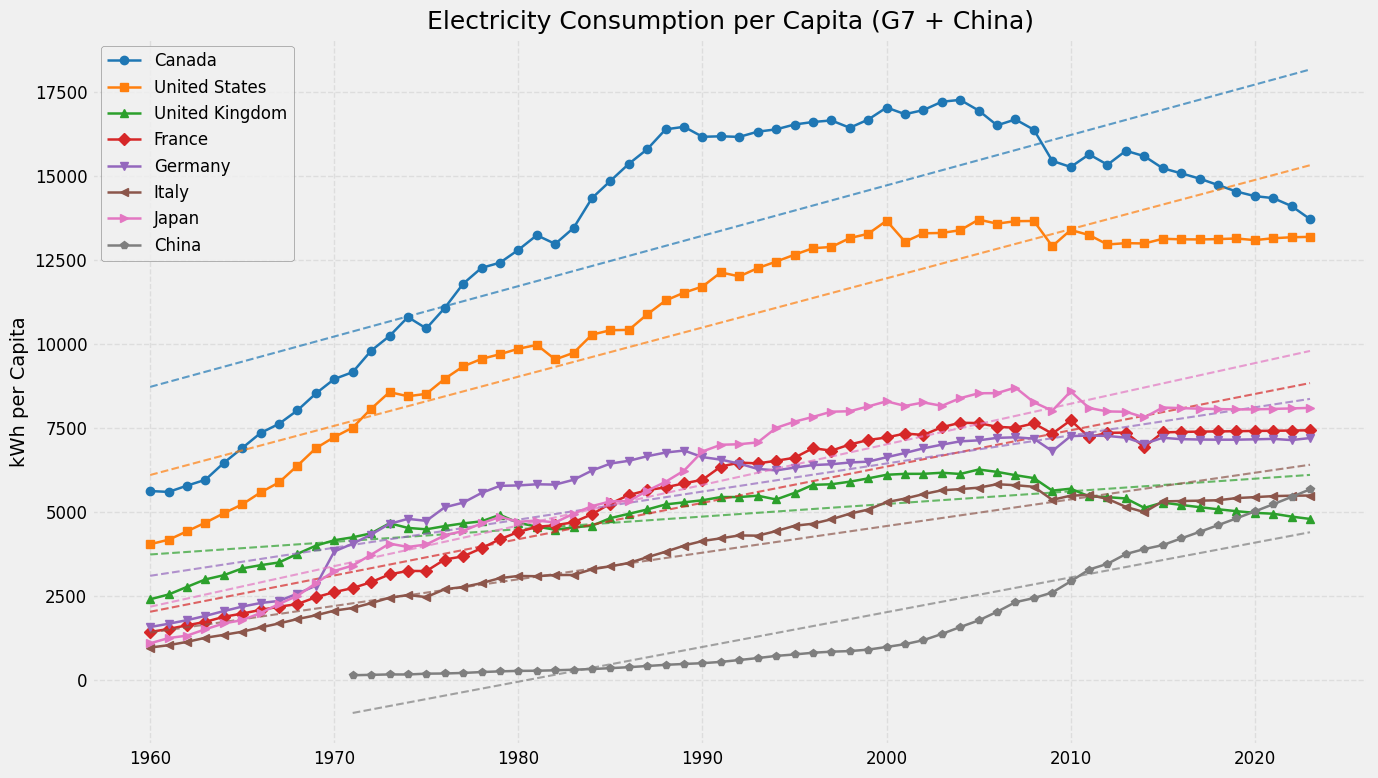

In [ ]:
# EDA - G7+China Electricity Consumption per Capita
print("--- EDA: G7+China Electricity Consumption per Capita ---")
g7_countries = ['Canada', 'United States',
                'United Kingdom', 'France',
                'Germany', 'Italy',
                'Japan', 'China']

electricity_total_df = datasets.get('electricity')
population_df = datasets.get('population')

if electricity_total_df is not None and not electricity_total_df.empty and \
   population_df is not None and not population_df.empty:
    try:
        # Norm tot elec consump by pop
        elec_filt = electricity_total_df[electricity_total_df['COUNTRY'].isin(g7_countries)]
        pop_filt = population_df[population_df['COUNTRY'].isin(g7_countries)]

        electricity_pc_norm = normalize_by_population(elec_filt, pop_filt)

        #kWh/person: val * 1e9 / 1e6 = val * 1000
        if not electricity_pc_norm.empty:
            electricity_pc_norm['VALUE'] = electricity_pc_norm['VALUE'] * 1000 # TWh/Mil -> kWh/per
            plot_trend(
                electricity_pc_norm,
                'Electricity Consumption per Capita (G7 + China)',
                'kWh per Capita',
                countries=g7_countries,
                save_filename="electricity_consumption_g7_china.png",
                add_ci=False,
                trend_line=True
            )
        else:
             print("Skipping plot: Normalization for G7+China electricity per capita yielded no data.")
    except Exception as e:
        print(f"Error during Electricity per Capita EDA: {e}")
else:
    print("Skipping plot: Total Electricity or Population data not available.")

*Interpretation:* Observe the trends in per capita electricity use. Note countries with high/low consumption and whether trends are increasing, decreasing, or stabilizing. Canada and the US typically show high per capita consumption. China's rapid increase is often notable. The forecasted data points (after 2014) should be viewed with caution.



--- EDA: G7+China R&D Expenditure (% GDP) ---


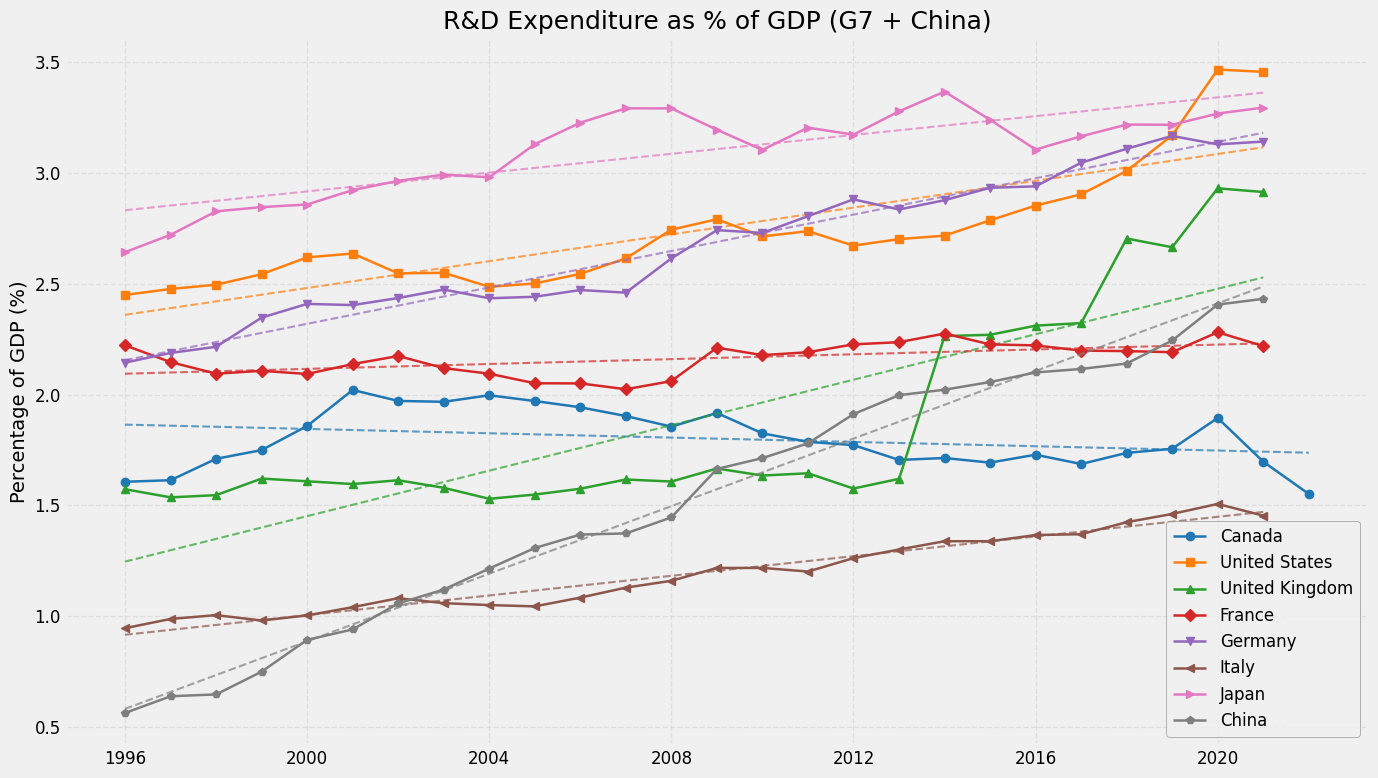

In [ ]:
# EDA - G7+China R&D Expenditure (% GDP)
print("\n--- EDA: G7+China R&D Expenditure (% GDP) ---")
rd_expenditure_df = datasets.get('rd_expenditure')
if rd_expenditure_df is not None and not rd_expenditure_df.empty:
    plot_trend(
        rd_expenditure_df[rd_expenditure_df['COUNTRY'].isin(g7_countries)],
        'R&D Expenditure as % of GDP (G7 + China)',
        'Percentage of GDP (%)',
        countries=g7_countries,
        save_filename="rd_expenditure_g7_china.png",
        trend_line=True
    )
else:
    print("Skipping plot: R&D Expenditure data not available.")

*Interpretation:* Compare R&D investment levels relative to GDP. Countries like South Korea (if included), Japan, and Germany often show high percentages. Note China's increasing trend. Consider if investment levels correlate visually with other innovation outputs.



--- EDA: G7+China Patent Applications per Capita ---


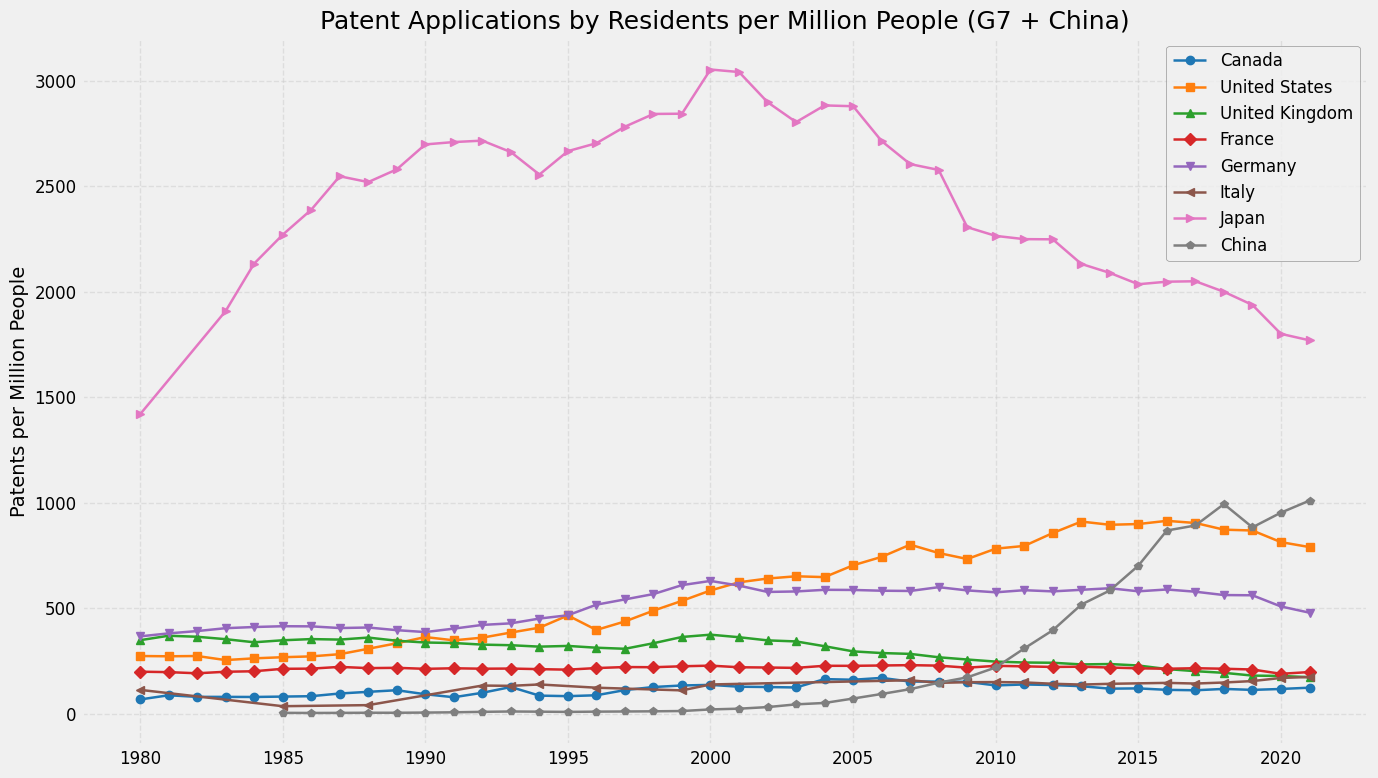

In [ ]:
# EDA - G7+China Patent Applications per Capita
print("\n--- EDA: G7+China Patent Applications per Capita ---")
patents_df = datasets.get('patents')
population_df = datasets.get('population')

if patents_df is not None and not patents_df.empty and \
   population_df is not None and not population_df.empty:
    try:
        patents_filt = patents_df[patents_df['COUNTRY'].isin(g7_countries)] #Filter
        pop_filt = population_df[population_df['COUNTRY'].isin(g7_countries)]
        patents_pc_norm = normalize_by_population(patents_filt, pop_filt)

        if not patents_pc_norm.empty:
            plot_trend(
                patents_pc_norm,
                'Patent Applications by Residents per Million People (G7 + China)',
                'Patents per Million People',
                countries=g7_countries,
                save_filename="patents_per_capita_g7_china.png",
                add_ci=False,
                trend_line=False
            )
        else:
             print("Skipping plot: Normalization for G7+China patents per capita yielded no data.")
    except Exception as e:
         print(f"Error during Patent per Capita EDA: {e}")
else:
    print("Skipping plot: Patents or Population data not available.")

*Interpretation:* Analyze patenting activity relative to population size. East Asian countries (Japan, S. Korea) and some European nations often lead. China's dramatic rise is a key feature. Compare these trends to R&D spending.



--- EDA: G7+China Scientific Articles per Capita ---


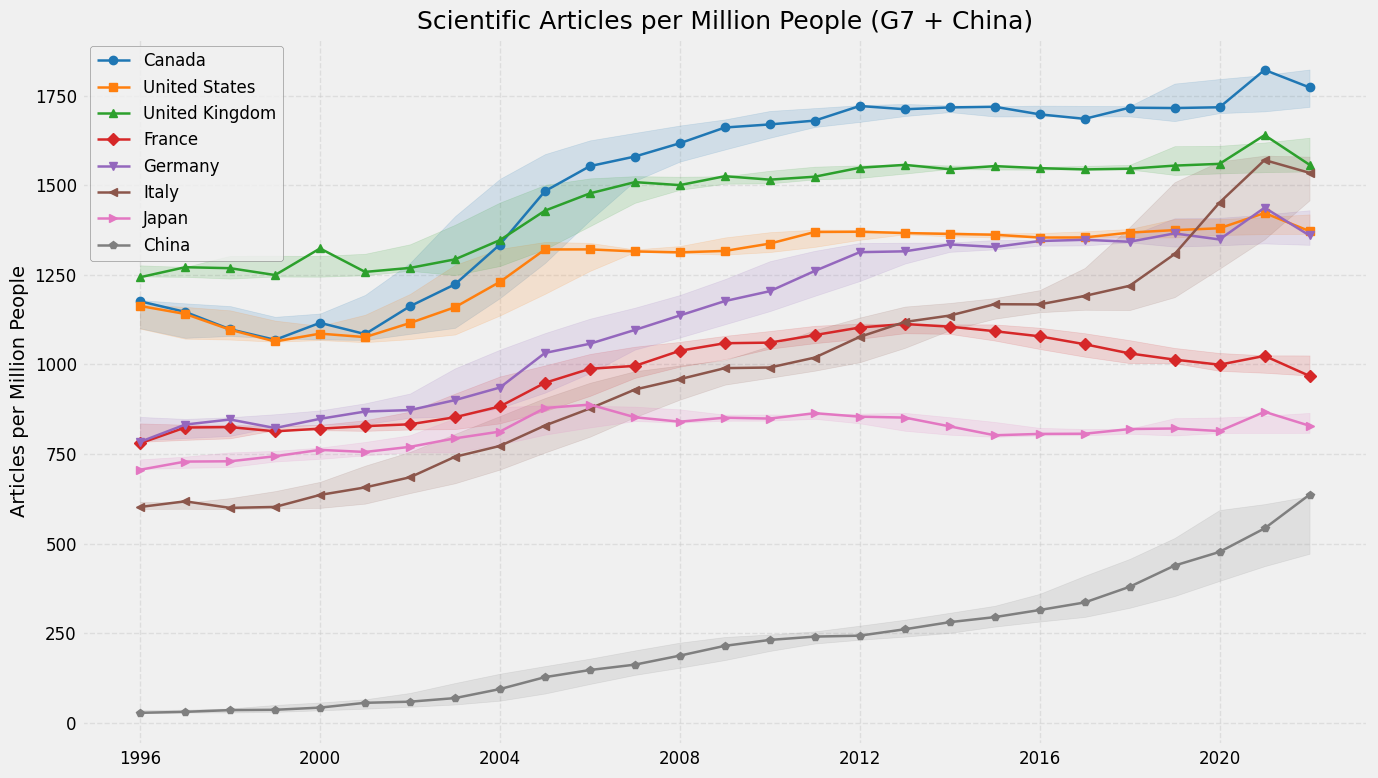

In [ ]:
# EDA - G7+China Scientific Articles per Capita
print("\n--- EDA: G7+China Scientific Articles per Capita ---")
articles_df = datasets.get('scientific_articles')
population_df = datasets.get('population')

if articles_df is not None and not articles_df.empty and \
   population_df is not None and not population_df.empty:
    try:
        articles_filt = articles_df[articles_df['COUNTRY'].isin(g7_countries)]  #Filter
        pop_filt = population_df[population_df['COUNTRY'].isin(g7_countries)]

        articles_pc_norm = normalize_by_population(articles_filt, pop_filt) #per mill ppl
        if not articles_pc_norm.empty:
            plot_trend(
                articles_pc_norm,
                'Scientific Articles per Million People (G7 + China)',
                'Articles per Million People',
                countries=g7_countries,
                save_filename="scientific_articles_per_capita_g7_china.png",
                add_ci=False
            )
        else:
            print("Skipping plot: Normalization for G7+China articles per capita yielded no data.")
    except Exception as e:
        print(f"Error during Scientific Articles per Capita EDA: {e}")
else:
    print("Skipping plot: Scientific Articles or Population data not available.")

*Interpretation:* Compare the output of scientific publications per capita. Some smaller, research-intensive countries might rank highly here alongside larger economies like the US. Observe the trends over time.



--- EDA: G7+China Researchers in R&D ---


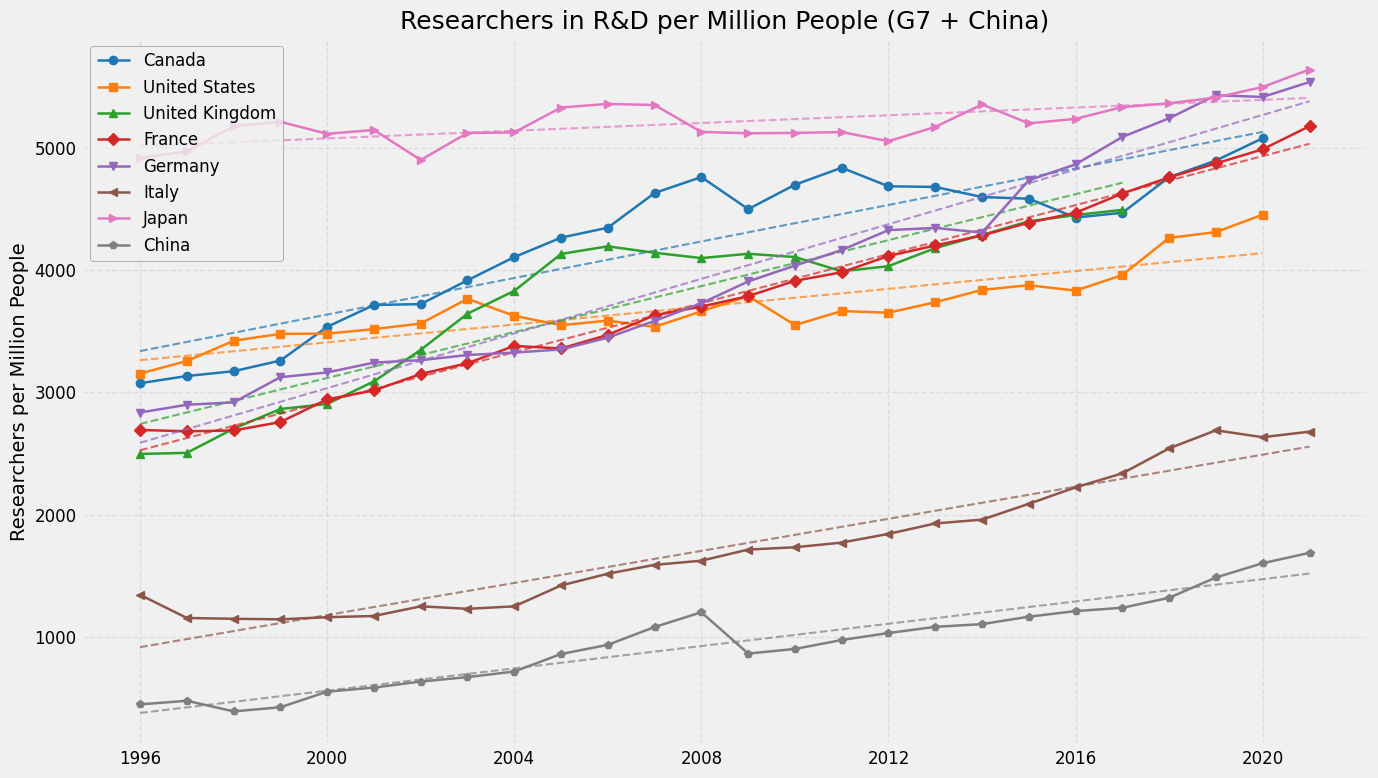

In [ ]:
# EDA - G7+China Researchers in R&D per Million People
print("\n--- EDA: G7+China Researchers in R&D ---")
researchers_df = datasets.get('researchers')
if researchers_df is not None and not researchers_df.empty:
    plot_trend(
        researchers_df[researchers_df['COUNTRY'].isin(g7_countries)],
        'Researchers in R&D per Million People (G7 + China)',
        'Researchers per Million People',
        countries=g7_countries,
        save_filename="researchers_g7_china.png",
        trend_line=True
    )
else:
    print("Skipping plot: Researchers data not available.")

*Interpretation:* Assess the density of research personnel in different countries. This is another input indicator for innovation. Compare trends with R&D expenditure and outputs like patents or articles.



--- EDA: Composite Innovation Index ---
Composite Innovation Index created (R&D % GDP: 60%, Patents/Capita: 40%).


REF_DATE COUNTRY     VALUE
104 1996-01-01  Canada  0.000000
105 1997-01-01  Canada  0.129674
106 1998-01-01  Canada  0.340081
107 1999-01-01  Canada  0.432363
108 2000-01-01  Canada  0.603603

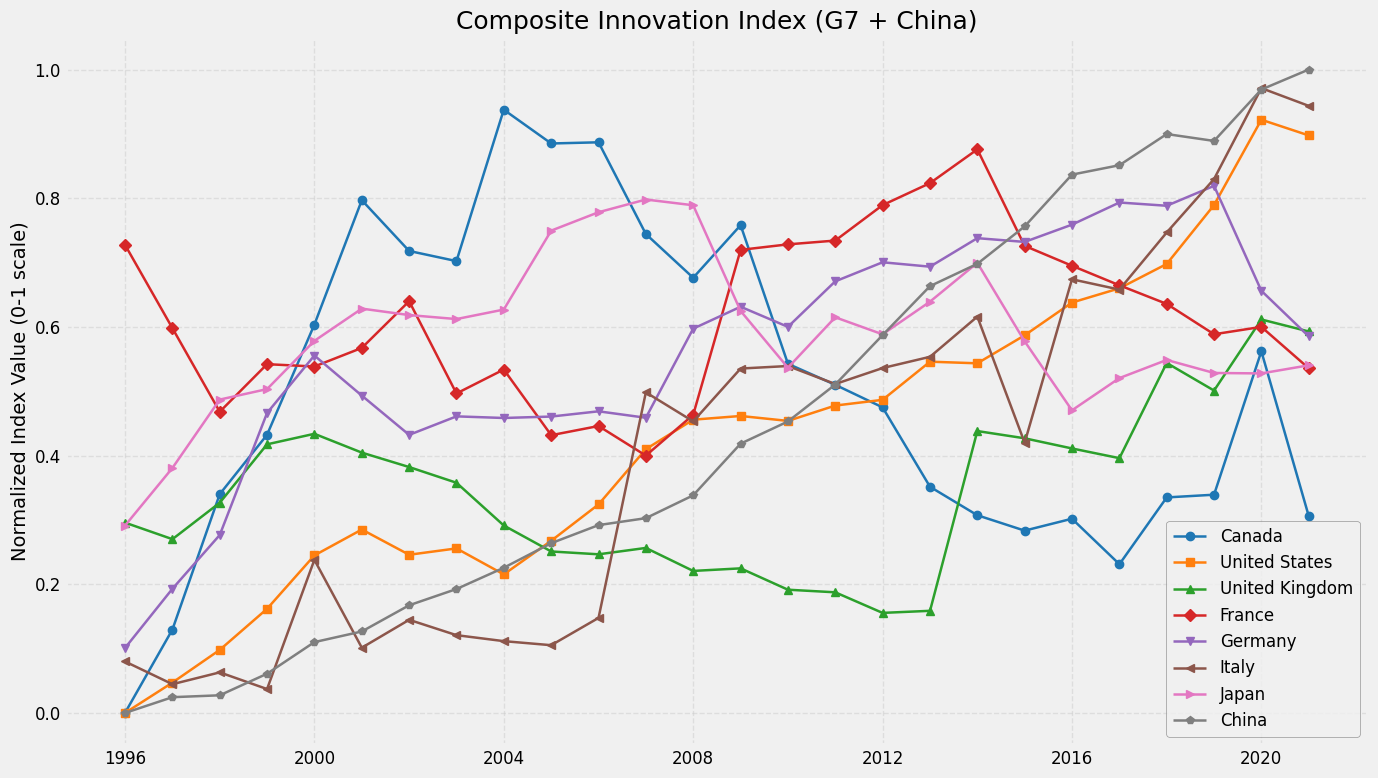

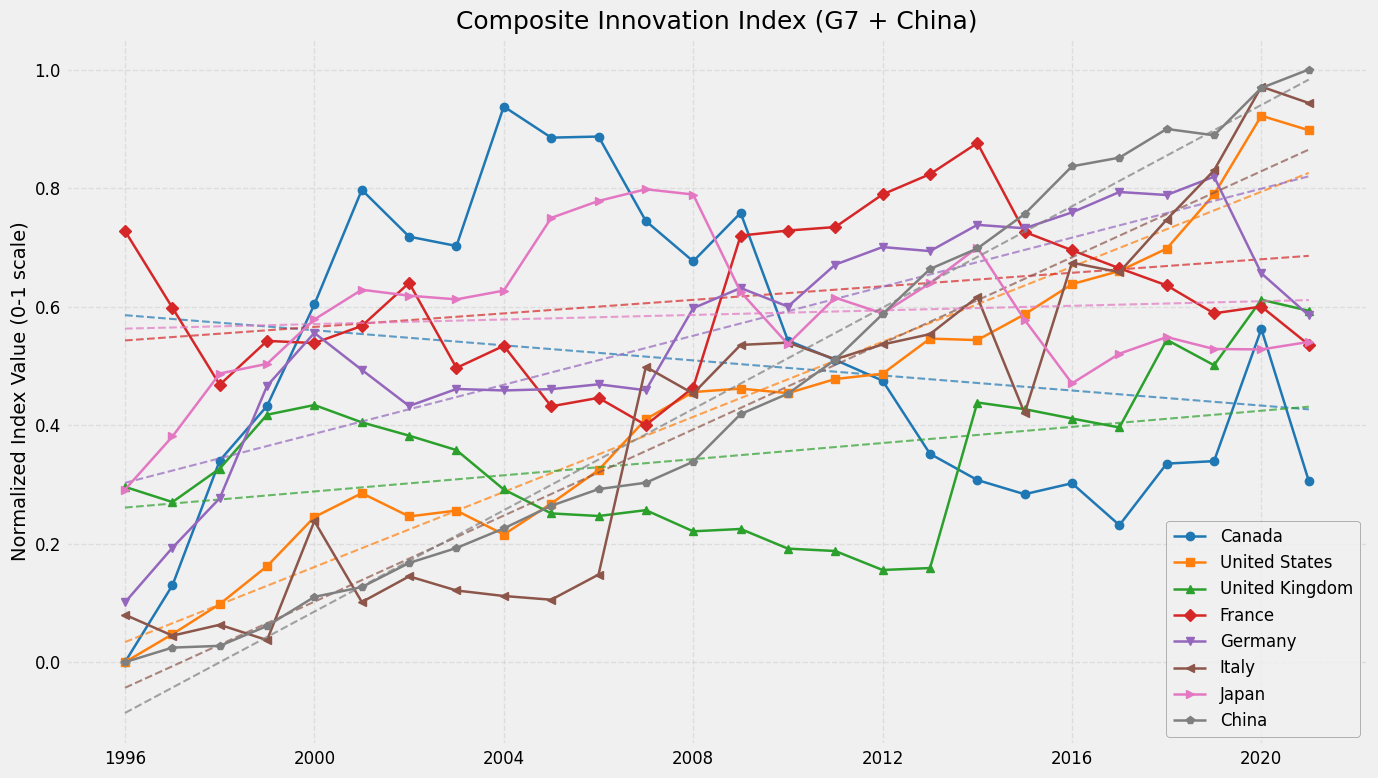

In [ ]:
# EDA - G7+China Composite Innovation Index
print("\n--- EDA: Composite Innovation Index ---")
composite_innovation_index = pd.DataFrame()
patents_df = datasets.get('patents')
rd_expenditure_df = datasets.get('rd_expenditure')
population_df = datasets.get('population')

patents_pc_calculated = 'patents_pc_norm' in locals() and patents_pc_norm is not None and not patents_pc_norm.empty
if not patents_pc_calculated and patents_df is not None and not patents_df.empty and population_df is not None and not population_df.empty:
    try:
        print("Recalculating patents per capita for composite index...")
        patents_pc_norm = normalize_by_population(patents_df, population_df)
        if patents_pc_norm.empty:
             print("Recalculation of patents per capita failed.")
             patents_pc_calculated = False
        else:
             patents_pc_calculated = True
    except Exception as e:
         print(f"Error recalculating patents per capita: {e}")
         patents_pc_calculated = False

if patents_pc_calculated and rd_expenditure_df is not None and not rd_expenditure_df.empty:
    rd_filt = rd_expenditure_df[rd_expenditure_df['COUNTRY'].isin(g7_countries)]
    patents_pc_filt = patents_pc_norm[patents_pc_norm['COUNTRY'].isin(g7_countries)]
    try:
        #filtered dfs passed
        composite_innovation_index = create_composite_innovation_index(
            dataframes=[rd_filt, patents_pc_filt],
            weights=[0.6, 0.4],
            country_col='COUNTRY'
        )
        if composite_innovation_index is not None and not composite_innovation_index.empty:
            print("Composite Innovation Index created (R&D % GDP: 60%, Patents/Capita: 40%).")
            try:
                display(composite_innovation_index.head())
            except NameError:
                 print(composite_innovation_index.head())
            plot_trend(
                composite_innovation_index,
                'Composite Innovation Index (G7 + China)',
                'Normalized Index Value (0-1 scale)',
                countries=g7_countries,
                save_filename="composite_innovation_index.png",
                trend_line=False
            )
            plot_trend(
                composite_innovation_index,
                'Composite Innovation Index (G7 + China)',
                'Normalized Index Value (0-1 scale)',
                countries=g7_countries,
                save_filename="composite_innovation_index.png",
                trend_line=True
            )
        else:
            print("Composite index calculation resulted in an empty DataFrame.")
    except Exception as e:
        print(f"Error creating composite index: {e}")
        traceback.print_exc()


*Interpretation:* The composite index provides a simplified overview of innovation performance based on the chosen inputs (R&D % GDP, Patents/Capita). Note the relative rankings and how they change over time. Remember this index is sensitive to the chosen metrics and weights.


## Part 2: Canada Deep Dive & US Comparison

This section focuses specifically on Canada, examining:
*   Correlations between energy consumption and innovation metrics within Canada.
*   Scatter plots visualizing key relationships.
*   A direct comparison of trends and gaps between Canada and the United States.
*   Regression models linking electricity consumption to innovation outputs in Canada.

In [ ]:
# Prepare CAN & US Specific Data
print("--- Preparing Canada & US Data ---")
canada_data = {}
us_data = {}
countries_to_extract = ['Canada', 'United States']
for name, df in datasets.items():
    if df is not None and not df.empty and 'COUNTRY' in df.columns:
        can_df_filt = df[df['COUNTRY'] == 'Canada'].copy()
        us_df_filt = df[df['COUNTRY'] == 'United States'].copy()
        if not can_df_filt.empty: canada_data[name] = can_df_filt
        if not us_df_filt.empty: us_data[name] = us_df_filt
    elif df is not None and not df.empty:
         warnings.warn(f"Dataset '{name}' loaded but has no COUNTRY column. Cannot filter for CAN/USA.")

# Calculate per-capita metrics specifically for Canada and US if base data exists
print("Calculating per-capita metrics for Canada...")
can_pop_df = canada_data.get('population')

#CAN Electricity Per Capita
can_elec_total_df = canada_data.get('electricity')
if can_elec_total_df is not None and not can_elec_total_df.empty and can_pop_df is not None and not can_pop_df.empty:
    try:
        #borm_by_pop which does per mil, then scaled
        canada_data['electricity_pc'] = normalize_by_population(can_elec_total_df, can_pop_df)
        if not canada_data['electricity_pc'].empty:
             canada_data['electricity_pc']['VALUE'] *= 1000
    except Exception as e:
         print(f"Warning: Failed to calculate Canada electricity per capita: {e}")
         canada_data['electricity_pc'] = pd.DataFrame()
else:
    canada_data['electricity_pc'] = pd.DataFrame()
    print("Warning: Cannot calculate Canada electricity per capita (missing total electricity or population).")

#CAN Patents Per Capita
can_patents_df = canada_data.get('patents')
if can_patents_df is not None and not can_patents_df.empty and can_pop_df is not None and not can_pop_df.empty:
    try:
        canada_data['patents_pc'] = normalize_by_population(can_patents_df, can_pop_df)
    except Exception as e:
         print(f"Warning: Failed to calculate Canada patents per capita: {e}")
         canada_data['patents_pc'] = pd.DataFrame()
else:
    canada_data['patents_pc'] = pd.DataFrame()
    print("Warning: Cannot calculate Canada patents per capita (missing patents or population).")

# US Data
print("Calculating per-capita metrics for US...")
us_pop_df = us_data.get('population')

# US Electricity Per Capita
us_elec_total_df = us_data.get('electricity')
if us_elec_total_df is not None and not us_elec_total_df.empty and us_pop_df is not None and not us_pop_df.empty:
    try:
        us_data['electricity_pc'] = normalize_by_population(us_elec_total_df, us_pop_df)
        if not us_data['electricity_pc'].empty:
             us_data['electricity_pc']['VALUE'] *= 1000
    except Exception as e:
        print(f"Warning: Failed to calculate US electricity per capita: {e}")
        us_data['electricity_pc'] = pd.DataFrame()
else:
    us_data['electricity_pc'] = pd.DataFrame()
    print("Warning: Cannot calculate US electricity per capita (missing total electricity or population).")

# US Patents Per Capita
us_patents_df = us_data.get('patents')
if us_patents_df is not None and not us_patents_df.empty and us_pop_df is not None and not us_pop_df.empty:
    try:
        us_data['patents_pc'] = normalize_by_population(us_patents_df, us_pop_df)
    except Exception as e:
        print(f"Warning: Failed to calculate US patents per capita: {e}")
        us_data['patents_pc'] = pd.DataFrame()
else:
    us_data['patents_pc'] = pd.DataFrame()
    print("Warning: Cannot calculate US patents per capita (missing patents or population).")

#list of key CAN innovation indicators for analysis
canada_indicators_dict = {
    'Electricity Cons. (kWh/Cap)': canada_data.get('electricity_pc'),
    'Patents (per Million)': canada_data.get('patents_pc'),
    'R&D Expenditure (% GDP)': canada_data.get('rd_expenditure'),
    'Scientific Articles': canada_data.get('scientific_articles'),
    'Scientific Articles (per Million)': None,
    'Researchers (per Million)': canada_data.get('researchers')
}
# Calculate Articles per Capita
can_articles_df = canada_data.get('scientific_articles')
if can_articles_df is not None and not can_articles_df.empty and can_pop_df is not None and not can_pop_df.empty:
    try:
        can_articles_pc = normalize_by_population(can_articles_df, can_pop_df)
        if not can_articles_pc.empty:
             canada_indicators_dict['Scientific Articles (per Million)'] = can_articles_pc
    except Exception as e:
         print(f"Warning: Failed to calculate Canada articles per capita: {e}")

canada_indicators_dfs = []
canada_indicator_names = []
for name, df in canada_indicators_dict.items():
    if df is not None and not df.empty:
         canada_indicators_dfs.append(df)
         canada_indicator_names.append(name)
    else:
         print(f"Note: Canadian indicator '{name}' is unavailable for analysis.")

if len(canada_indicators_dfs) < 2:
     print("\nError: Less than two valid Canadian indicators available. Correlation and regression may fail.")
else:
     print(f"\nPrepared {len(canada_indicators_dfs)} valid indicators for Canadian analysis: {', '.join(canada_indicator_names)}")

--- Preparing Canada & US Data ---
Calculating per-capita metrics for Canada...
Calculating per-capita metrics for US...

Prepared 6 valid indicators for Canadian analysis: Electricity Cons. (kWh/Cap), Patents (per Million), R&D Expenditure (% GDP), Scientific Articles, Scientific Articles (per Million), Researchers (per Million)


--- Canada Correlation Analysis ---

Correlation Matrix (Canada, 1996-2021):


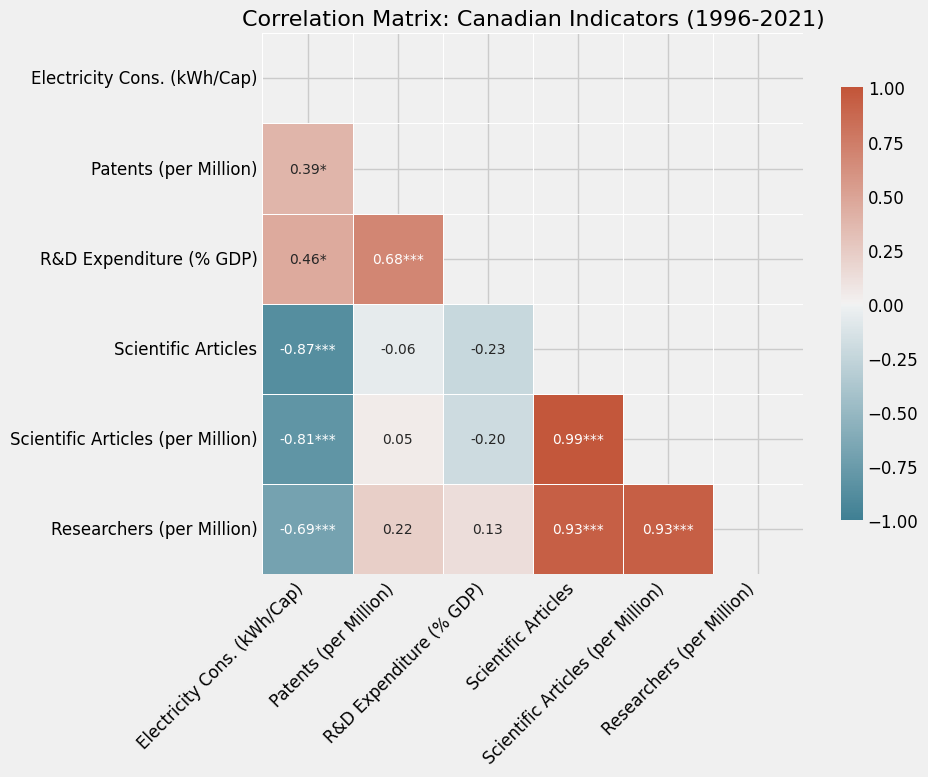

In [ ]:
# Canada Correlation Analysis
print("--- Canada Correlation Analysis ---")
if len(canada_indicators_dfs) >= 2:
    try:
        #correlation func for period
        corr_year_range = (1996, 2021)
        canada_corr_matrix, canada_corr_data = robust_correlation_analysis(
            canada_indicators_dfs,
            canada_indicator_names,
            min_periods=5, #min overlap yrs
            year_range=corr_year_range
        )
        print(f"\nCorrelation Matrix (Canada, {corr_year_range[0]}-{corr_year_range[1]}):")
        styled_corr = canada_corr_matrix.style.format("{:.2f}").background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
        try:
            display(styled_corr)
        except NameError:
            print(canada_corr_matrix.round(2))

        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(canada_corr_matrix, dtype=bool))
        cmap = sns.diverging_palette(220, 20, as_cmap=True)

        annot_labels = canada_corr_matrix.astype(str).copy()
        #est N based on pairwise
        n_obs_approx = len(canada_corr_data.dropna(how='all'))
        p_critical = 0.05
        for i in range(len(canada_corr_matrix)):
            for j in range(len(canada_corr_matrix)):
                r = canada_corr_matrix.iloc[i, j]
                if i == j:
                     annot_labels.iloc[i, j] = "1.00"
                     continue
                if pd.isna(r):
                     annot_labels.iloc[i, j] = "N/A"
                     continue

                #calc pairwise N for p-val
                pairwise_data = canada_corr_data[[canada_corr_matrix.columns[i], canada_corr_matrix.columns[j]]].dropna()
                n_pairwise = len(pairwise_data)
                if n_pairwise < 3:
                     p_value = 1.0
                else:
                     try:
                         corr_coeff, p_value = stats.pearsonr(pairwise_data.iloc[:, 0], pairwise_data.iloc[:, 1])
                     except Exception:
                         p_value = 1.0

                stars = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < p_critical else ""
                annot_labels.iloc[i, j] = f"{r:.2f}{stars}"

        sns.heatmap(canada_corr_matrix,
                    annot=annot_labels,
                    cmap=cmap,
                    vmin=-1, vmax=1,
                    fmt='',
                    mask=mask,
                    square=True,
                    linewidths=0.5,
                    cbar_kws={"shrink": 0.8},
                    annot_kws={"size": 10})

        plt.title(f'Correlation Matrix: Canadian Indicators ({corr_year_range[0]}-{corr_year_range[1]})', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        save_path = output_dir / "canada_correlation_matrix.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    except ValueError as ve:
         print(f"Skipping correlation analysis: {ve}")
    except Exception as e:
        print(f"Error during correlation analysis: {e}")
else:
    print("Skipping correlation analysis: Not enough valid Canadian indicator data.")

*Interpretation:* Examine the correlation matrix and heatmap. Pay attention to the relationship between 'Electricity Cons. (kWh/Cap)' and the innovation metrics (Patents, R&D, Articles, Researchers). Note the sign (positive/negative) and magnitude of the correlations. Stars indicate statistical significance (*p<0.05, **p<0.01, ***p<0.001). Are the relationships strong or weak? Do they align with expectations?



--- Canada Scatter Plots (Electricity vs. Innovation) ---


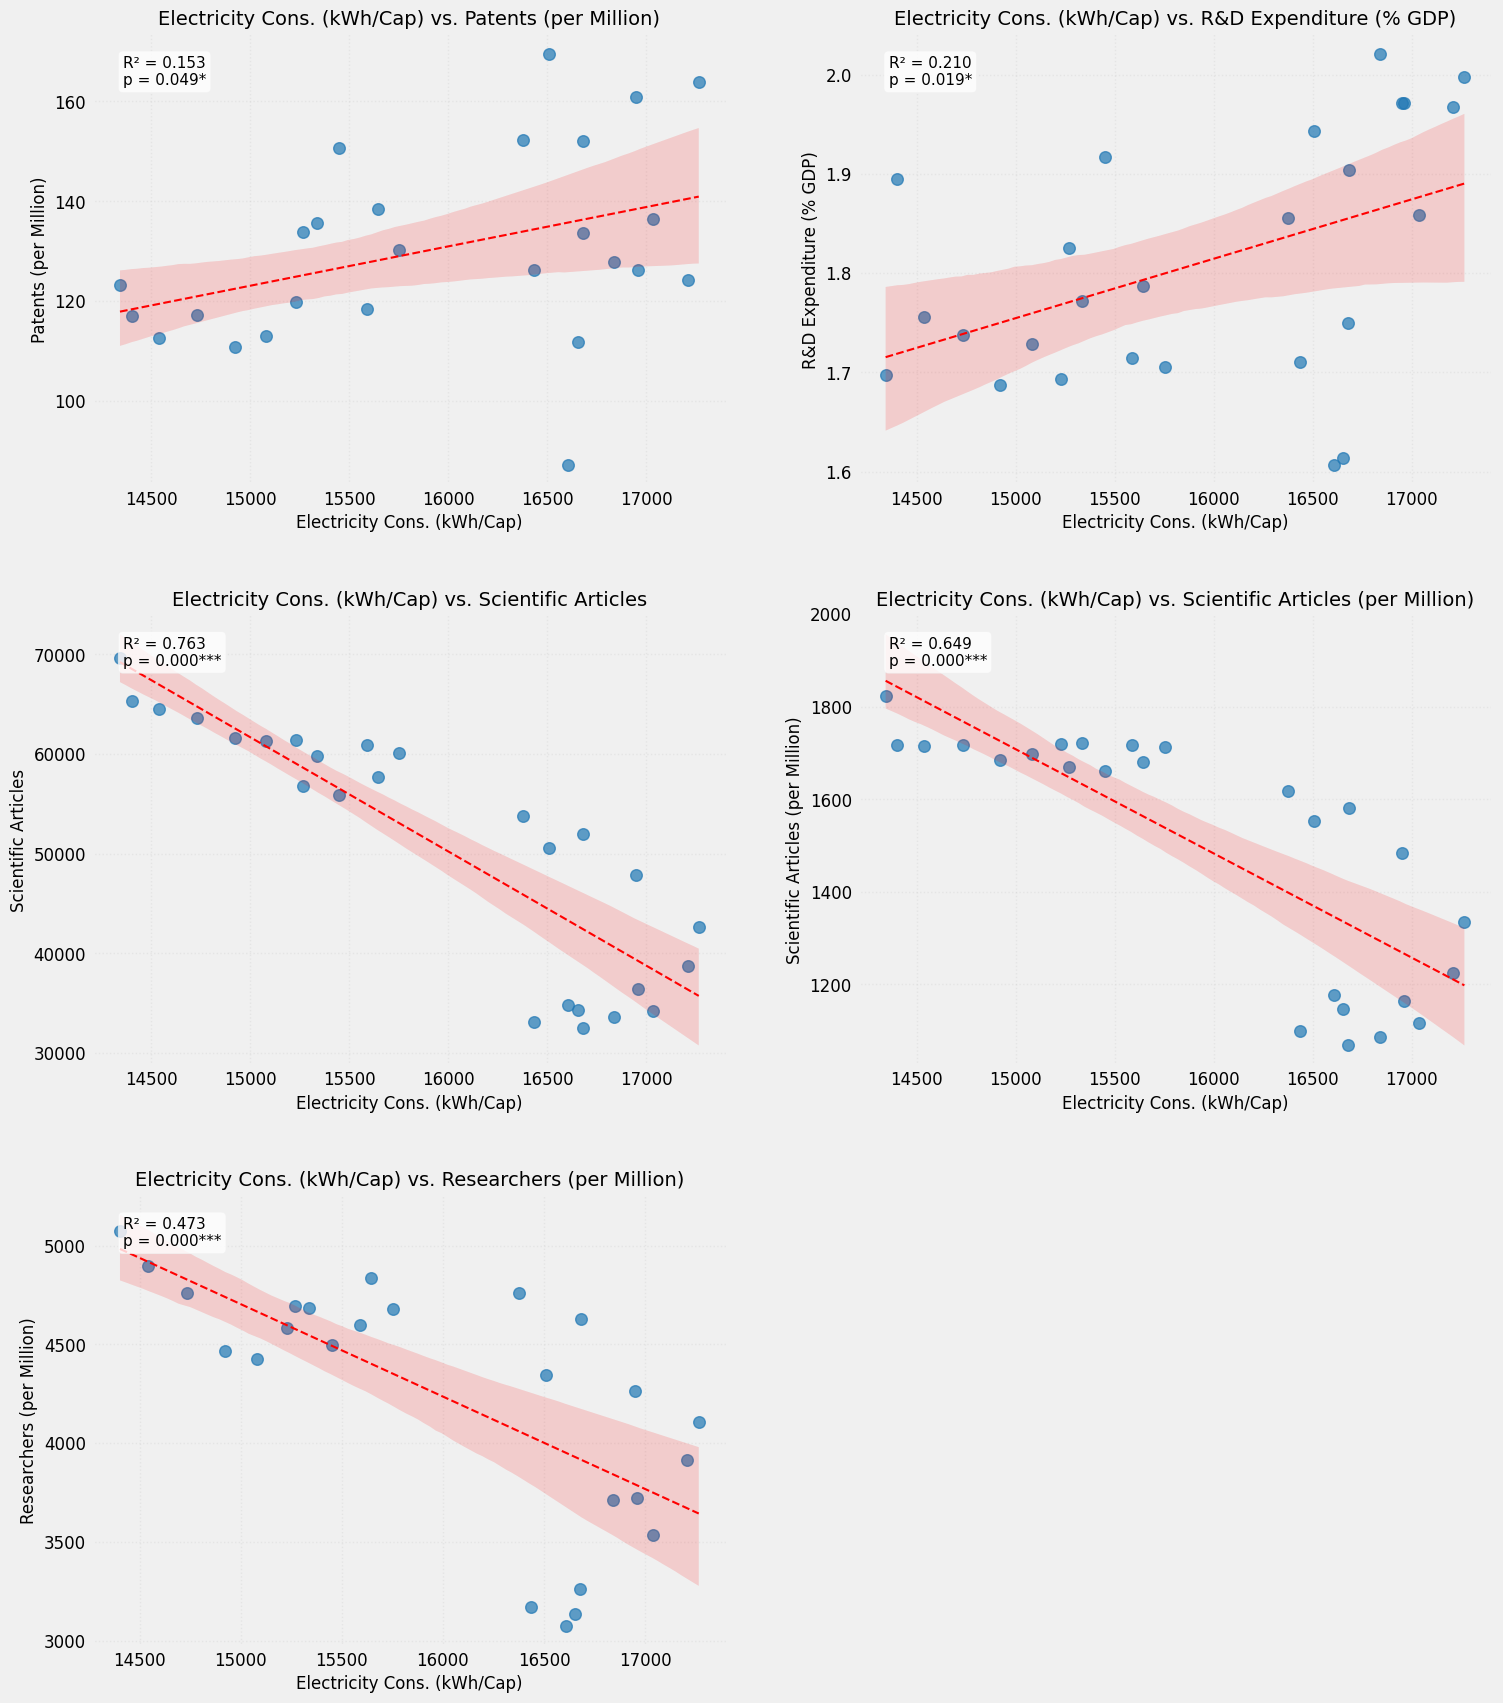

In [ ]:
# Canada Scatter Plots (Electricity vs. Innovation)
print("\n--- Canada Scatter Plots (Electricity vs. Innovation) ---")
if 'canada_corr_data' in locals() and canada_corr_data is not None and not canada_corr_data.empty:
    x_var = 'Electricity Cons. (kWh/Cap)'

    if x_var not in canada_corr_data.columns:
         print(f"Error: X-variable '{x_var}' not found in correlation data for scatter plots.")
    else:
        present_innovation_metrics = [
            name for name in canada_indicator_names
            if name != x_var and name in canada_corr_data.columns
        ]
        num_plots = len(present_innovation_metrics)
        if num_plots > 0:
            n_cols = 2
            n_rows = (num_plots + n_cols - 1) // n_cols
            fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows), squeeze=False)
            axs = axs.flatten() # Flatten to 1D array for easy indexing
            plot_idx = 0
            for y_var in present_innovation_metrics:
                 ax = axs[plot_idx]
                 valid_data = canada_corr_data[[x_var, y_var]].dropna()
                 if len(valid_data) > 1: # min 2 points for regplot
                      sns.regplot(x=x_var, y=y_var, data=valid_data, ax=ax,
                                line_kws={"color":"red", "lw":1.5, "linestyle":"--"},
                                scatter_kws={"color": "#1f77b4", "s": 70, "alpha": 0.7})
                      try:
                            slope, intercept, r_value, p_value, std_err = stats.linregress(valid_data[x_var], valid_data[y_var])
                            stars = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                            ax.text(0.05, 0.95, f"R² = {r_value**2:.3f}\np = {p_value:.3f}{stars}",
                                  transform=ax.transAxes, fontsize=11, verticalalignment='top',
                                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                      except ValueError as e:
                           print(f"Linregress failed for {y_var}: {e}")
                           ax.text(0.05, 0.95, "Stats N/A", transform=ax.transAxes, fontsize=11, verticalalignment='top')
                      ax.set_title(f'{x_var} vs. {y_var}', fontsize=14)
                      ax.set_xlabel(x_var, fontsize=12)
                      ax.set_ylabel(y_var, fontsize=12)
                      ax.grid(True, alpha=0.3, linestyle=':')
                      plot_idx += 1
                 else:
                      ax.text(0.5, 0.5, "Not enough data", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='red')
                      ax.set_title(f'{x_var} vs. {y_var}', fontsize=14)
                      plot_idx += 1
            for i in range(plot_idx, len(axs)):
                 fig.delaxes(axs[i])
            plt.tight_layout(pad=3.0)
            save_path = output_dir / "canada_electricity_innovation_scatterplots.png"
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print("Skipping scatter plots: No valid innovation metrics found in correlation data.")

*Interpretation:* These plots visualize the correlations observed earlier. Look at the slope of the regression line (red dashed line) to see the direction of the relationship. The R-squared value indicates the proportion of variance in the innovation metric explained by electricity consumption in this simple linear model. The p-value indicates the significance of the relationship. Does a linear relationship seem appropriate? Are there outliers?



--- Canada vs. US Gap Analysis ---

--- Analyzing Gap: Electricity Cons. (kWh/Cap) ---


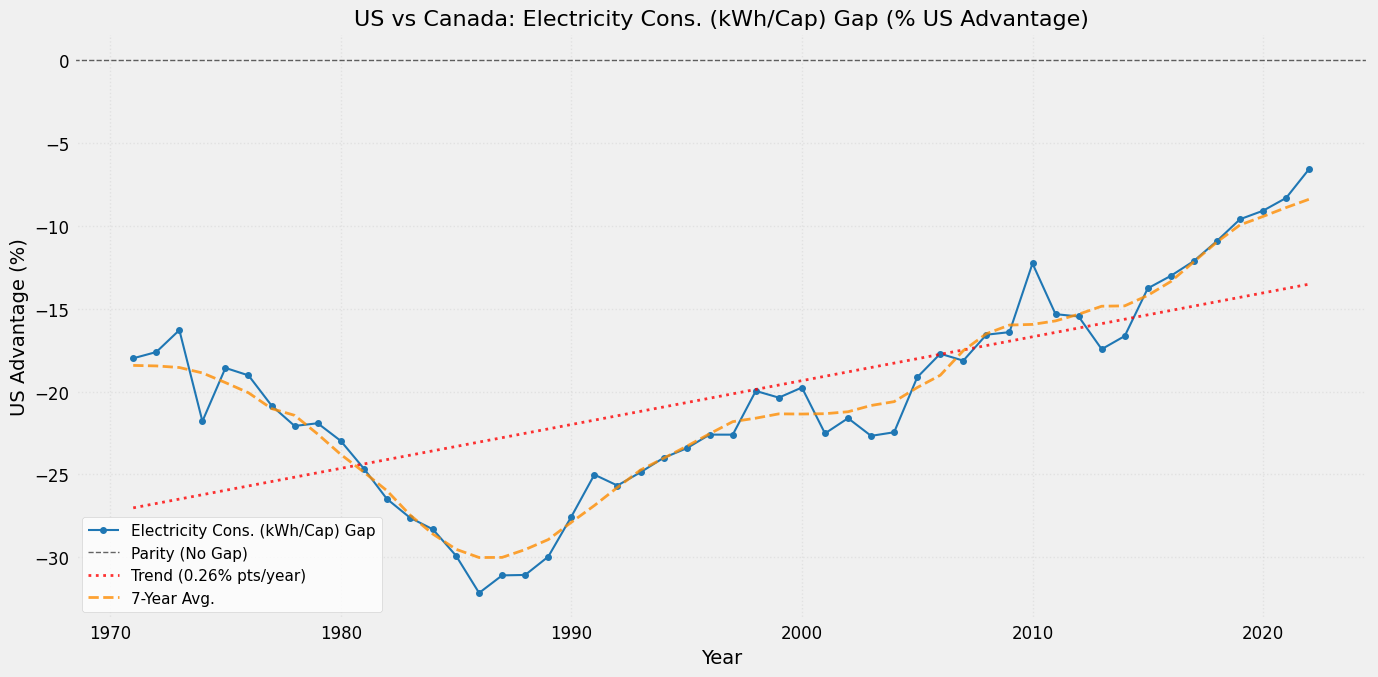


--- Electricity Cons. (kWh/Cap) Gap Analysis Summary ---
Time Period Analyzed: 1971-2022
Average US Advantage: -20.27%
Median US Advantage: -20.61%
Recent US Advantage (avg last <=5yr): -8.90%
Linear Trend: Widening US Lead (0.26 percentage points per year)
---------------------------------------------------

--- Analyzing Gap: Patents (per Million) ---


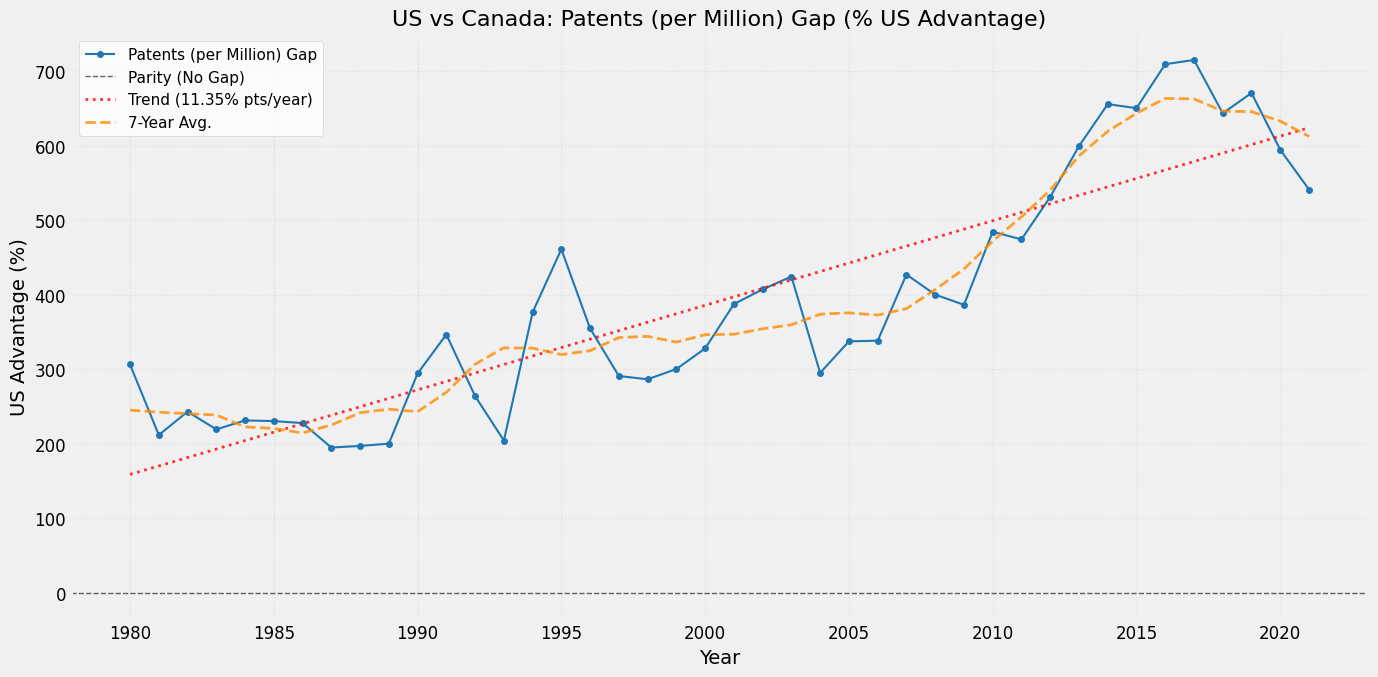


--- Patents (per Million) Gap Analysis Summary ---
Time Period Analyzed: 1980-2021
Average US Advantage: 391.62%
Median US Advantage: 350.80%
Recent US Advantage (avg last <=5yr): 633.06%
Linear Trend: Widening US Lead (11.35 percentage points per year)
---------------------------------------------

--- Analyzing Gap: R&D Expenditure (% GDP) ---


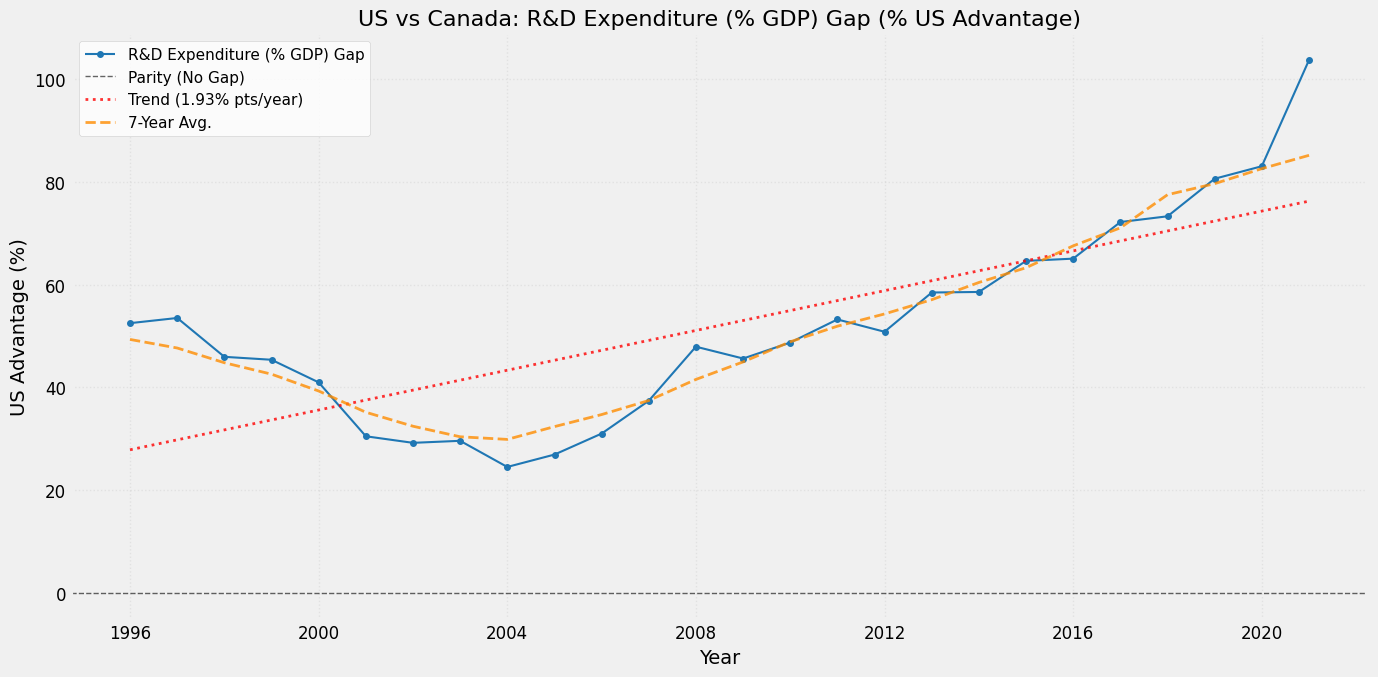


--- R&D Expenditure (% GDP) Gap Analysis Summary ---
Time Period Analyzed: 1996-2021
Average US Advantage: 52.03%
Median US Advantage: 49.76%
Recent US Advantage (avg last <=5yr): 82.54%
Linear Trend: Widening US Lead (1.93 percentage points per year)
-----------------------------------------------

--- Analyzing Gap: Researchers (per Million) ---


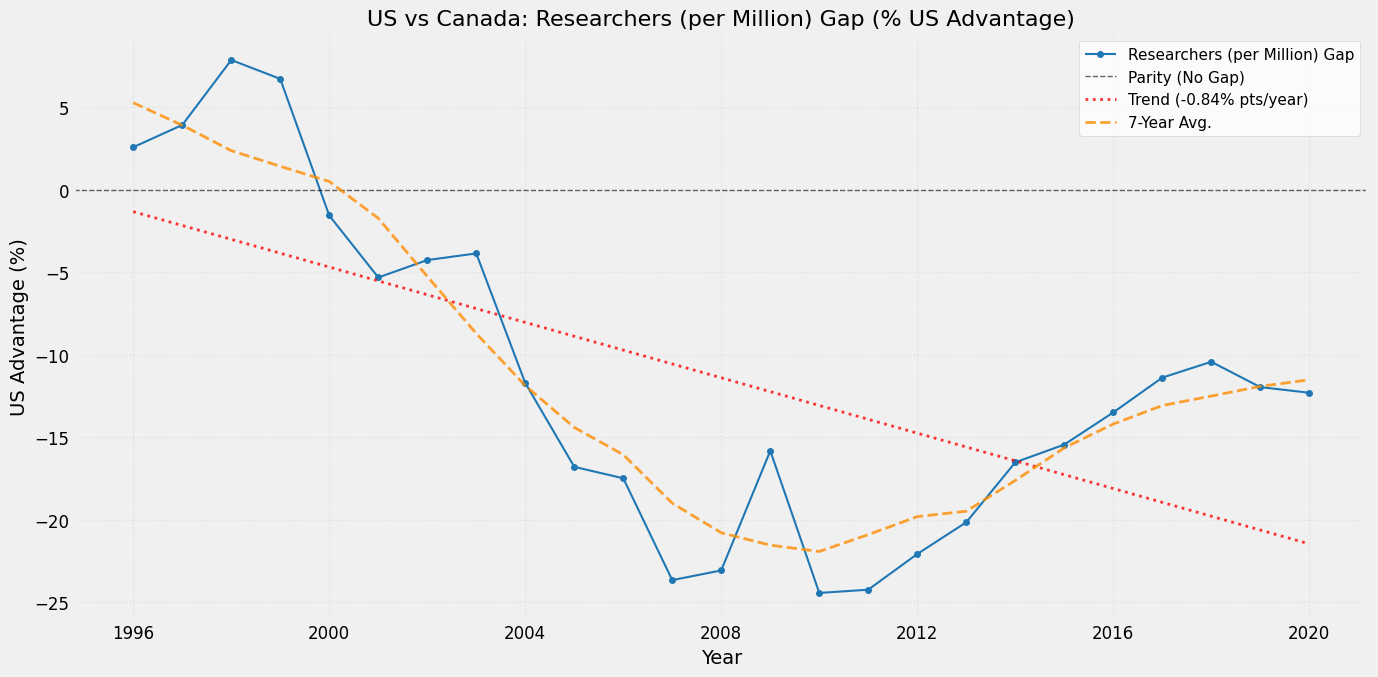


--- Researchers (per Million) Gap Analysis Summary ---
Time Period Analyzed: 1996-2020
Average US Advantage: -11.40%
Median US Advantage: -12.30%
Recent US Advantage (avg last <=5yr): -11.91%
Linear Trend: Narrowing US Lead (-0.84 percentage points per year)
-------------------------------------------------

--- Analyzing Gap: Scientific Articles (per Million) ---
Skipping gap analysis for Scientific Articles (per Million): Missing data for Canada 'Scientific Articles (per Million)', US 'Scientific Articles (per Million)'.


In [ ]:
# Canada vs. US Gap Analysis
print("\n--- Canada vs. US Gap Analysis ---")
#per-capita and %GDP metrics calc before
gap_analysis_metrics = {
    "Electricity Cons. (kWh/Cap)": ('electricity_pc', (1971, 2022)),
    "Patents (per Million)": ('patents_pc', (1980, 2022)),
    "R&D Expenditure (% GDP)": ('rd_expenditure', (1981, 2022)),
    "Researchers (per Million)": ('researchers', (1996, 2022)),
    "Scientific Articles (per Million)": ('Scientific Articles (per Million)', (1996, 2022)),
}
gap_results = {}
for metric_name, (data_key, time_range) in gap_analysis_metrics.items():
    print(f"\n--- Analyzing Gap: {metric_name} ---")
    can_df = canada_data.get(data_key)
    us_df = us_data.get(data_key)
    if can_df is not None and not can_df.empty and us_df is not None and not us_df.empty:
        try:
            gap_df = analyze_innovation_gaps(
                can_df=can_df,
                us_df=us_df,
                metric_name=metric_name,
                time_period=time_range,
                save_filename_base="canada_us_gap"
            )
            gap_results[metric_name] = gap_df
        except Exception as e:
            print(f"Error during gap analysis for {metric_name}: {e}")
    else:
        missing = []
        if can_df is None or can_df.empty:
            missing.append(f"Canada '{data_key}'")
        if us_df is None or us_df.empty:
            missing.append(f"US '{data_key}'")
        print(f"Skipping gap analysis for {metric_name}: Missing data for {', '.join(missing)}.")

*Interpretation:* A positive gap indicates a US advantage, negative indicates a Canadian advantage.



--- Innovation Efficiency (Patents per GWh) ---


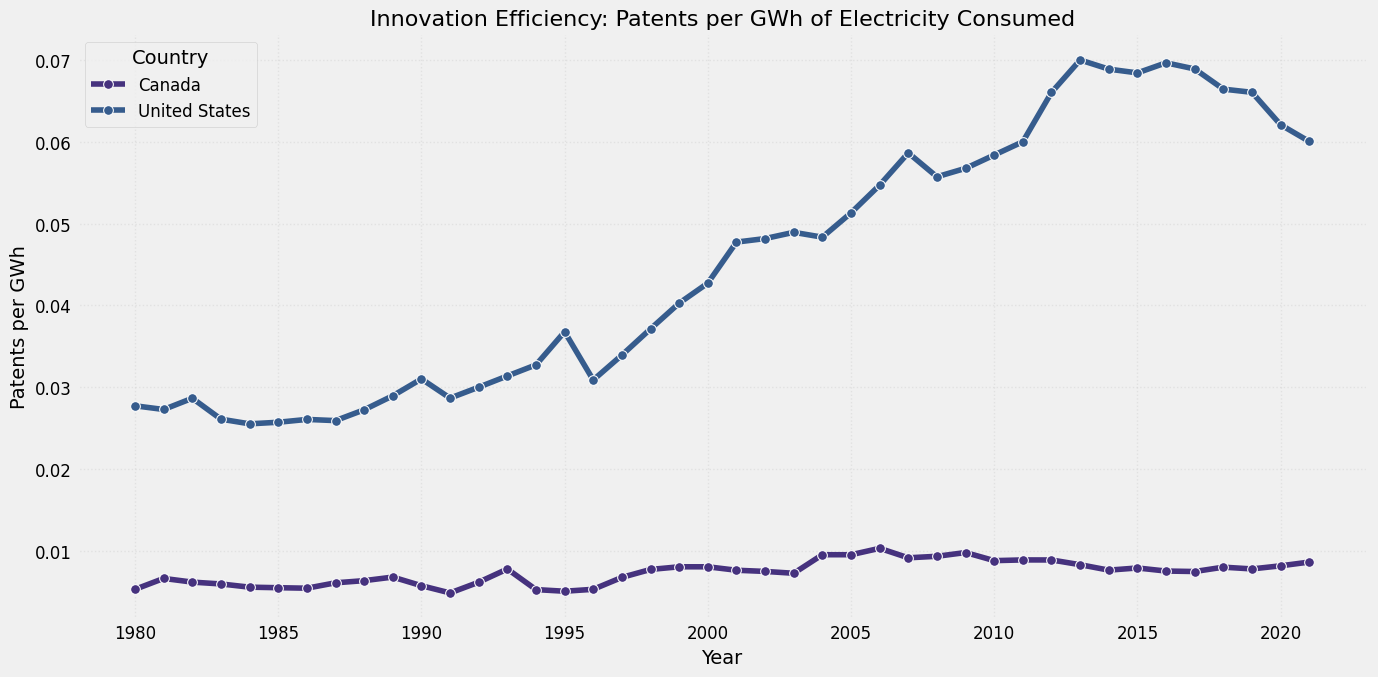


Average Innovation Efficiency (Patents per GWh, 2000-2021):
  Canada: 0.0084
  US:     0.0590
  US Advantage: 601.13%


In [ ]:
# Innovation Efficiency Comparison (Patents per GWh)
print("\n--- Innovation Efficiency (Patents per GWh) ---")
can_patents = canada_data.get('patents')
can_electricity = canada_data.get('electricity')
us_patents = us_data.get('patents')
us_electricity = us_data.get('electricity')

if can_patents is not None and not can_patents.empty and \
   can_electricity is not None and not can_electricity.empty and \
   us_patents is not None and not us_patents.empty and \
   us_electricity is not None and not us_electricity.empty:

    def calculate_efficiency(pat_df, elec_df, country_name):
        # Ensure numeric and clean
        pat_df_clean = pat_df[['REF_DATE', 'VALUE']].copy()
        pat_df_clean['VALUE'] = pd.to_numeric(pat_df_clean['VALUE'], errors='coerce')
        pat_df_clean = pat_df_clean.dropna().rename(columns={'VALUE':'Patents'})
        elec_df_clean = elec_df[['REF_DATE', 'VALUE']].copy()
        elec_df_clean['VALUE'] = pd.to_numeric(elec_df_clean['VALUE'], errors='coerce')
        elec_df_clean = elec_df_clean.dropna().rename(columns={'VALUE':'Electricity_TWh'})

        if pat_df_clean.empty or elec_df_clean.empty:
            return pd.DataFrame()

        merged = pd.merge(pat_df_clean, elec_df_clean, on='REF_DATE', how='inner')
        merged = merged[merged['Electricity_TWh'] > 1e-6]
        if merged.empty:
            return pd.DataFrame()

        merged['Efficiency_Patents_per_GWh'] = merged['Patents'] / (merged['Electricity_TWh'] * 1000)
        merged['COUNTRY'] = country_name
        return merged[['REF_DATE', 'COUNTRY', 'Efficiency_Patents_per_GWh']]
    try:
        can_efficiency = calculate_efficiency(can_patents, can_electricity, 'Canada')
        us_efficiency = calculate_efficiency(us_patents, us_electricity, 'United States')

        combined_efficiency = pd.concat([can_efficiency, us_efficiency], ignore_index=True)
        if not combined_efficiency.empty:
            plt.figure(figsize=(14, 7))
            sns.lineplot(data=combined_efficiency, x='REF_DATE', y='Efficiency_Patents_per_GWh', hue='COUNTRY', marker='o', markersize=7)
            plt.title('Innovation Efficiency: Patents per GWh of Electricity Consumed', fontsize=16)
            plt.ylabel('Patents per GWh', fontsize=14)
            plt.xlabel('Year', fontsize=14)
            # plt.yscale('log')
            plt.grid(True, which='both', linestyle=':', alpha=0.4)
            plt.legend(title='Country', fontsize=12)
            plt.tight_layout()
            save_path = output_dir / "patent_energy_efficiency.png"
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.show()

            #calc avg eff metrics over common period
            common_eff_years = get_common_years([can_efficiency, us_efficiency])
            recent_common_eff_years = [yr for yr in common_eff_years if yr >= 2000]

            if recent_common_eff_years:
                 can_recent_eff = can_efficiency[can_efficiency['REF_DATE'].dt.year.isin(recent_common_eff_years)]['Efficiency_Patents_per_GWh']
                 us_recent_eff = us_efficiency[us_efficiency['REF_DATE'].dt.year.isin(recent_common_eff_years)]['Efficiency_Patents_per_GWh']

                 can_avg_eff = can_recent_eff.mean()
                 us_avg_eff = us_recent_eff.mean()

                 if pd.notna(can_avg_eff) and pd.notna(us_avg_eff) and abs(can_avg_eff) > 1e-9:
                     efficiency_gap_pct = (us_avg_eff / can_avg_eff - 1) * 100
                 else:
                     efficiency_gap_pct = np.nan


                 print(f"\nAverage Innovation Efficiency (Patents per GWh, {min(recent_common_eff_years)}-{max(recent_common_eff_years)}):")
                 print(f"  Canada: {can_avg_eff:.4f}")
                 print(f"  US:     {us_avg_eff:.4f}")
                 if not np.isnan(efficiency_gap_pct): print(f"  US Advantage: {efficiency_gap_pct:.2f}%")
            else:
                 print("\nCould not calculate average efficiency comparison (no recent common years with data for both).")
        else:
             print("No efficiency data calculated for plotting or comparison.")
    except Exception as e:
        print(f"Error calculating or plotting innovation efficiency: {e}")
else:
    missing_eff = []
    if can_patents is None or can_patents.empty:
        missing_eff.append("CAN Patents")
    if can_electricity is None or can_electricity.empty:
        missing_eff.append("CAN Electricity")
    if us_patents is None or us_patents.empty:
        missing_eff.append("US Patents")
    if us_electricity is None or us_electricity.empty:
        missing_eff.append("US Electricity")
    print(f"Skipping innovation efficiency analysis: Missing required data ({', '.join(missing_eff)}).")

*Interpretation:* This metric attempts to capture how effectively electricity consumption translates into patent output. A higher value suggests more patents generated per unit of energy. Is there a significant difference between Canada and the US? How have these efficiencies changed over time? The log scale helps visualize trends when values differ by orders of magnitude.



--- Canada Regression Modeling (Electricity -> Innovation) ---
Note: Using base data for Electricity Cons. (kWh/Cap) in regression.
Running regression with Electricity Cons. (kWh/Cap) as independent variable for 6 dependent variables.


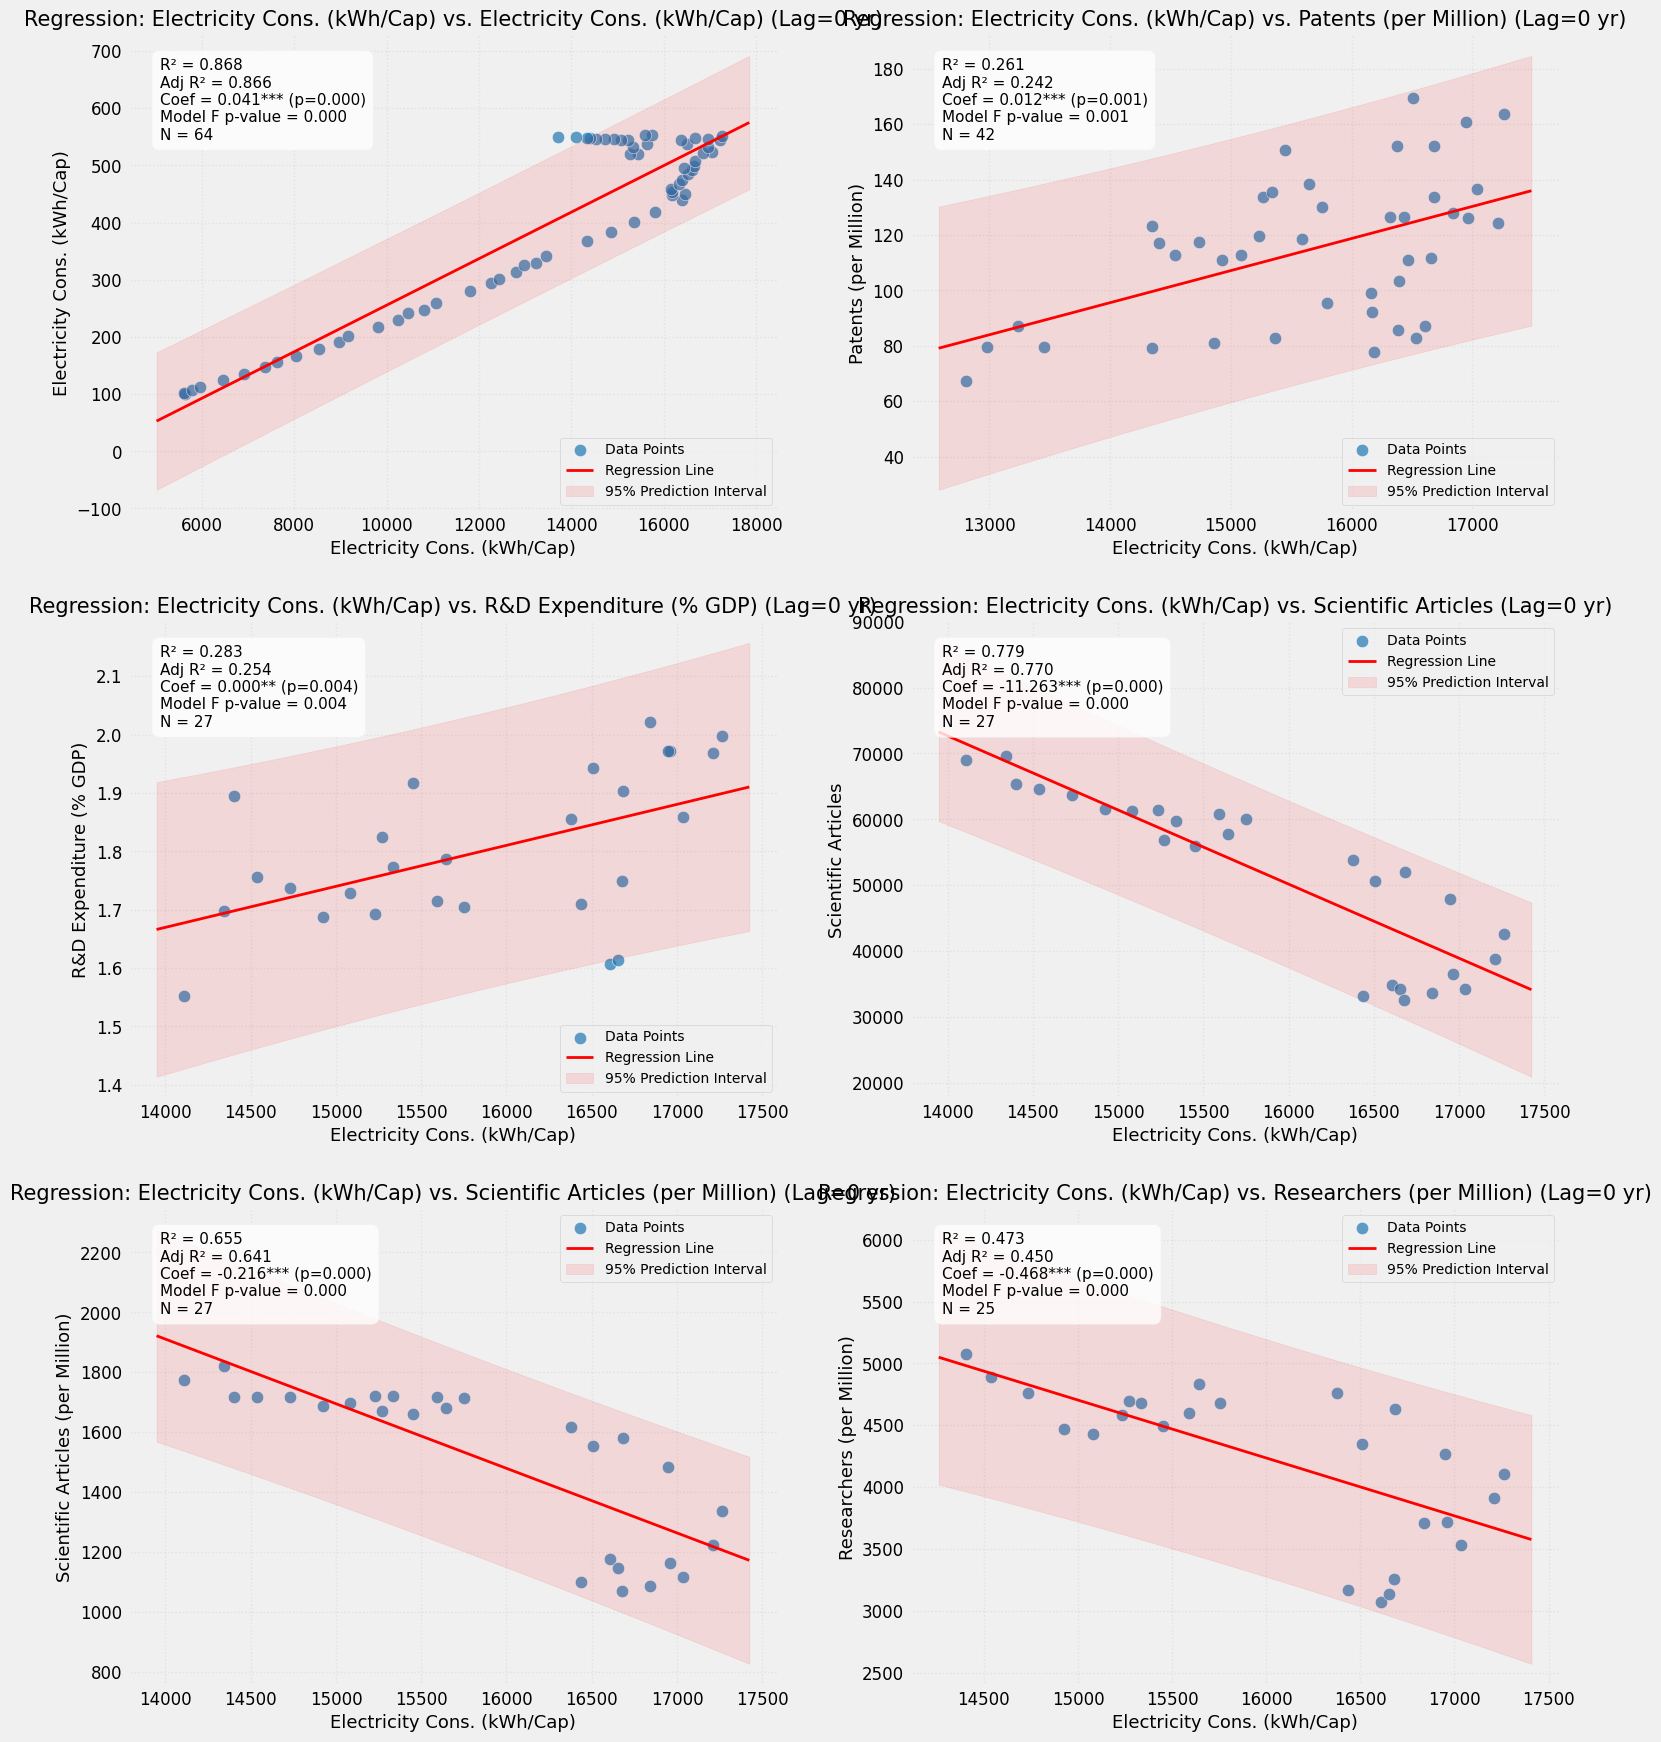


Regression Model Results Summary:


Dependent  R-squared  Adj R-squared  Coefficient  \
0        Electricity Cons. (kWh/Cap)     0.8680         0.8658       0.0407   
1              Patents (per Million)     0.2610         0.2425       0.0116   
2            R&D Expenditure (% GDP)     0.2830         0.2543       0.0001   
3                Scientific Articles     0.7792         0.7703     -11.2626   
4  Scientific Articles (per Million)     0.6551         0.6413      -0.2159   
5          Researchers (per Million)     0.4728         0.4498      -0.4680   

   Coef p-value  Observations  
0        0.0000            64  
1        0.0005            42  
2        0.0043            27  
3        0.0000            27  
4        0.0000            27  
5        0.0001            25

In [ ]:
# Canada Regression Modeling (Electricity -> Innovation)
print("\n--- Canada Regression Modeling (Electricity -> Innovation) ---")
x_df_reg = canada_data.get('electricity_pc')
x_name_reg = 'Electricity Cons. (kWh/Cap)'
y_dfs_for_reg = []
y_names_for_reg = []
for name, df in zip(canada_indicator_names, canada_indicators_dfs):
    if name != x_name_reg:
        y_dfs_for_reg.append(df)
        y_names_for_reg.append(name)
    else:
        base_name_map = {
              'Scientific Articles (per Million)': 'scientific_articles',
              'Patents (per Million)': 'patents',
              'Electricity Cons. (kWh/Cap)': 'electricity'
        }
        base_name = base_name_map.get(name, name)
        y_df_candidate_base = canada_data.get(base_name)
        if y_df_candidate_base is not None and not y_df_candidate_base.empty:
            y_dfs_for_reg.append(y_df_candidate_base)
            y_names_for_reg.append(name)
            print(f"Note: Using base data for {name} in regression.")
        else:
            print(f"Warning: Skipping {name} in regression - Data not found.")

regression_results_df = pd.DataFrame()
if x_df_reg is not None and not x_df_reg.empty and y_dfs_for_reg:
    print(f"Running regression with {x_name_reg} as independent variable for {len(y_names_for_reg)} dependent variables.")
    try:
        #reg with lag = 0
        lag_to_test = 0
        regression_results_df = create_visualize_regression_models(
            X_df=x_df_reg,
            X_name=x_name_reg,
            y_dfs=y_dfs_for_reg,
            y_names=y_names_for_reg,
            lag_years=lag_to_test,
            save_filename=f"canada_electricity_innovation_regressions_lag{lag_to_test}.png"
        )
        if not regression_results_df.empty:
             print("\nRegression Model Results Summary:")
             cols_to_show = ['Dependent','R-squared', 'Adj R-squared', 'Coefficient', 'Coef p-value', 'Observations']
             cols_exist = [c for c in cols_to_show if c in regression_results_df.columns]
             summary_display = regression_results_df[cols_exist].round(4)
             try:
                  display(summary_display)
             except NameError:
                  print(summary_display)
        else:
            if not y_names_for_reg:
                print("\nRegression modeling skipped: No valid Y variables found after filtering.")
            elif x_df_reg is None or x_df_reg.empty:
                print("\nRegression modeling skipped: Input X variable data is missing.")
            else:
                print("\nRegression modeling did not produce any results.")
    except Exception as e:
        print(f"Error during regression modeling: {e}")
        import traceback
        traceback.print_exc()
else:
    missing_reg = []
    if x_df_reg is None or x_df_reg.empty:
        missing_reg.append("X variable (Electricity Cons. kWh/Cap)")
    if not y_dfs_for_reg:
        missing_reg.append("valid Y variables (Innovation Metrics)")
    print(f"Skipping regression modeling: Input data missing ({', '.join(missing_reg)}).")

*Interpretation:* Analyze the regression plots and the summary table. For each innovation metric:
*   **R-squared:** How much variance does electricity consumption explain?
*   **Coefficient:** How much does the innovation metric change for a one-unit increase in electricity consumption (in kWh/Capita)? Is the relationship positive or negative?
*   **Coef p-value:** Is the relationship statistically significant (typically p < 0.05)?
These simple linear regressions provide a first look, but causation is not implied, and relationships might be non-linear or influenced by other factors.


--- Preliminary Economic Impact Model (Patents -> GDP Growth) ---
Modeling relationship between Patents per Capita and GDP Growth Rate in Canada.

OLS Regression Results: Patents per Million vs. GDP per Capita Growth Rate (Canada)
                            OLS Regression Results                            
Dep. Variable:          GDP_GROWTH_PC   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.4546
Date:                Thu, 27 Mar 2025   Prob (F-statistic):              0.504
Time:                        02:08:43   Log-Likelihood:                -144.47
No. Observations:                  42   AIC:                             292.9
Df Residuals:                      40   BIC:                             296.4
Df Model:                           1                                         
Covariance Type:            nonrobust                    

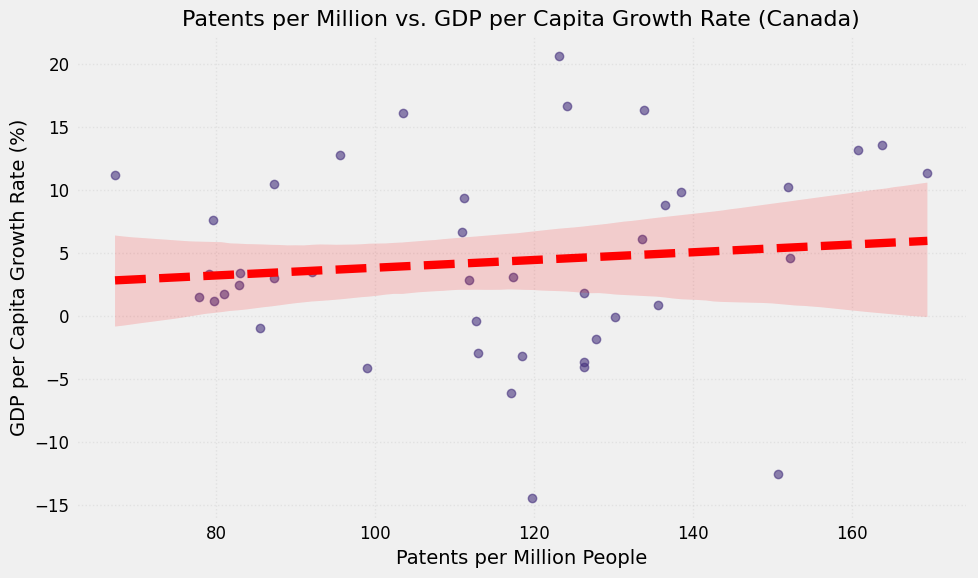

In [ ]:
# Preliminary Economic Impact Model (Patents -> GDP Growth)
print("\n--- Preliminary Economic Impact Model (Patents -> GDP Growth) ---")
print("Modeling relationship between Patents per Capita and GDP Growth Rate in Canada.")
can_gdp_total = canada_data.get('gdp')
can_pop = canada_data.get('population')
can_pat_pc = canada_data.get('patents_pc')
patents_gdp_growth_model = None

missing_econ_data = []
if can_gdp_total is None or can_gdp_total.empty:
    missing_econ_data.append("GDP (Total)")
if can_pop is None or can_pop.empty:
    missing_econ_data.append("Population")
if can_pat_pc is None or can_pat_pc.empty:
    missing_econ_data.append("Patents per Capita")

if not missing_econ_data:
    try:
        can_gdp_pc_norm = normalize_by_population(can_gdp_total, can_pop)
        if not can_gdp_pc_norm.empty:
            can_gdp_pc_norm = can_gdp_pc_norm.sort_values('REF_DATE')
            can_gdp_pc_norm['GDP_GROWTH_PC'] = can_gdp_pc_norm['VALUE'].pct_change() * 100
            can_gdp_pc_norm = can_gdp_pc_norm.dropna(subset=['GDP_GROWTH_PC'])

            patents_gdp_data = pd.merge(
                can_pat_pc[['REF_DATE', 'VALUE']].rename(columns={'VALUE': 'Patents_PC_M'}),
                can_gdp_pc_norm[['REF_DATE', 'GDP_GROWTH_PC']],
                on='REF_DATE',
                how='inner'
            ).dropna()

            if len(patents_gdp_data) > 5:
                X = patents_gdp_data['Patents_PC_M']
                y = patents_gdp_data['GDP_GROWTH_PC']
                X_with_const = sm.add_constant(X)
                try:
                    patents_gdp_growth_model = sm.OLS(y, X_with_const).fit()
                    print("\nOLS Regression Results: Patents per Million vs. GDP per Capita Growth Rate (Canada)")
                    print(patents_gdp_growth_model.summary())
                    #visual
                    plt.figure(figsize=(10, 6))
                    sns.regplot(x='Patents_PC_M', y='GDP_GROWTH_PC', data=patents_gdp_data,
                                line_kws={'color':'red', 'ls':'--'}, scatter_kws={'alpha':0.6})
                    plt.title('Patents per Million vs. GDP per Capita Growth Rate (Canada)')
                    plt.xlabel('Patents per Million People')
                    plt.ylabel('GDP per Capita Growth Rate (%)')
                    plt.grid(True, linestyle=':', alpha=0.4)
                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"Error fitting OLS model for Patents vs GDP Growth: {e}")
            else:
                print("Skipping Patents vs GDP Growth model: Not enough overlapping data points after merging.")
        else:
            print("Skipping Patents vs GDP Growth model: Failed to calculate GDP per capita.")
    except Exception as e:
        print(f"Error during setup for Patents vs GDP Growth model: {e}")
else:
    print(f"Skipping Patents vs GDP Growth model: Missing required data ({', '.join(missing_econ_data)}).")

*Interpretation:* This model attempts to link innovation output (patents per capita) to economic outcome (GDP growth).
*   **Model Summary:** Very low R-squared, shows that this metric alone does not show correlation with gdp per capita growth rate as many factors affect GDP growth.
*   **Limitations:** This was a very simple model implemented. GDP growth is influenced by numerous factors beyond patents.


## Part 3: Advanced Policy Simulation (Canada)

This section uses the relationships explored earlier to simulate the potential impact of different future energy policy scenarios on Canadian innovation outcomes.

**Scenarios:**
*   **Baseline:** Assumes minimal changes to current trends.
*   **Green Innovation:** Focuses on increased energy use coupled with significant efficiency gains and boosts to innovation activities, potentially through targeted investments.
*   **Strategic Growth:** Prioritizes higher energy availability with moderate efficiency and innovation efforts.
*   **Research Intensive:** Moderate energy growth, lower efficiency focus, but strong direct boosts to innovation metrics, representing heavy R&D investment.

The simulation projects key innovation indicators and estimates the potential downstream economic impacts based on the preliminary Patents-GDP link. Includes uncertainty estimation.


In [ ]:
# Advanced Policy Simulation Class Definition
print("--- Defining Advanced Policy Simulation Class ---")
class AdvancedPolicySimulation:
    def __init__(self,
                 base_year: int = 2021,
                 projection_years: int = 8, #num yrs after base yr
                 baseline_growth: float = 0.01, #baseline annual energy growth
                 random_seed: int = 42):

        self.base_year = base_year
        self.projection_horizon = projection_years
        self.num_proj_points = projection_years + 1
        self.baseline_growth = baseline_growth
        self.random_seed = random_seed
        np.random.seed(random_seed)

        # energy_multiplier: Factor applied to baseline energy growth rate
        # efficiency_gain: Cumulative % reduction in energy needed per output unit by end of horizon
        # innovation_boost: Cumulative % boost to innovation metric projection by end of horizon
        # implementation_cost: Estimated total cost as % of initial GDP
        # renewable_shift: Added annual increase in renewable share
        # policy_uncertainty: Std Dev factor for random shocks
        # economic_feedback: Annual % boost to innovation based on GDP growth itself
        self.default_scenarios = {
            'Baseline': {
                'energy_multiplier': 1.0, 'efficiency_gain': 0.0, 'innovation_boost': 0.0,
                'implementation_cost': 0.0, 'renewable_shift': 0.005, 'policy_uncertainty': 0.05,
                'economic_feedback': 0.0
            },
            'Green Innovation': {
                'energy_multiplier': 1.15, 'efficiency_gain': 0.18, 'innovation_boost': 0.25,
                'implementation_cost': 0.45, 'renewable_shift': 0.035, 'policy_uncertainty': 0.15,
                'economic_feedback': 0.12
            },
            'Strategic Growth': {
                'energy_multiplier': 1.3, 'efficiency_gain': 0.08, 'innovation_boost': 0.15,
                'implementation_cost': 0.4, 'renewable_shift': 0.015, 'policy_uncertainty': 0.2,
                'economic_feedback': 0.1
            },
            'Research Intensive': {
                'energy_multiplier': 1.25, 'efficiency_gain': 0.05, 'innovation_boost': 0.3,
                'implementation_cost': 0.55, 'renewable_shift': 0.01, 'policy_uncertainty': 0.18,
                'economic_feedback': 0.15
            }
        }
        self.scenarios = self.default_scenarios


    def _generate_energy_pathway(self, latest_energy: float, scenario_params: Dict) -> np.ndarray:
        """Generates a stochastic energy pathway for a scenario."""
        num_points = self.num_proj_points
        energy_multiplier = scenario_params.get('energy_multiplier', 1.0)
        #eff. gain as cum. reduction by end yr
        final_efficiency_reduction = scenario_params.get('efficiency_gain', 0.0)
        policy_uncertainty_std = scenario_params.get('policy_uncertainty', 0.1) * self.baseline_growth #uncertainty scaled w/ growth

        energy_values = np.zeros(num_points)
        energy_values[0] = latest_energy

        for i in range(1, num_points):
            #linear ramp-up of eff effect over horizon
            cumulative_efficiency_factor = 1.0 - (final_efficiency_reduction * (i / self.projection_horizon)) if self.projection_horizon > 0 else 1.0
            # Stochastic shock for the year
            random_shock = np.random.normal(0, policy_uncertainty_std)
            #growth rate calc
            growth_rate = (self.baseline_growth * energy_multiplier * cumulative_efficiency_factor) + random_shock
            #growth rate
            energy_values[i] = energy_values[i-1] * (1 + growth_rate)

        return energy_values

    def _predict_innovation_metric(self,
                                model: sm.regression.linear_model.RegressionResultsWrapper,
                                energy_values: np.ndarray,
                                latest_innovation_value: float,
                                scenario_params: Dict,
                                lag: int = 0,
                                include_uncertainty: bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Predicts innovation metric using model, scenario boosts, and uncertainty."""
        num_points = self.num_proj_points
        innovation_boost = scenario_params.get('innovation_boost', 0.0) # Cum boost by end yr
        economic_feedback = scenario_params.get('economic_feedback', 0.0) # Annual feedback factor
        policy_uncertainty_std_factor = scenario_params.get('policy_uncertainty', 0.1) #uncertainty factor

        #lagged Energy Input
        #if lag=1, innovation(t) depends on energy(t-1).
        if lag > 0:
            #assumed energy was const. at base_year val for `lag` yrs before
            padded_energy = np.concatenate([np.full(lag, energy_values[0]), energy_values])
            # Select the lagged values corresponding to prediction time points 0 to N
            lagged_energy_input = padded_energy[:num_points]
        elif lag < 0:
             #assumed energy t+abs(lag) is same as energy(t) for pred
             warnings.warn(f"Negative lag ({lag}) interpretation assumes future energy is same as current for prediction.")
             lagged_energy_input = energy_values
        else:
            lagged_energy_input = energy_values
        X_pred_input = lagged_energy_input.reshape(-1, 1)
        X_pred_with_const = sm.add_constant(X_pred_input)

        #Pred w/ OLS Model
        base_predictions = model.predict(X_pred_with_const)

        #Adj implementation
        predictions = np.copy(base_predictions)
        for i in range(num_points):
            #linear ramp-up of innovation boost
            boost_factor = 1.0 + (innovation_boost * (i / self.projection_horizon)) if self.projection_horizon > 0 else 1.0
            #econ. feedback effect - compounding
            feedback_factor = (1.0 + economic_feedback) ** i
            #rand. shock related to uncertainty, scaled by pred val
            random_shock = np.random.normal(0, policy_uncertainty_std_factor * abs(predictions[i]) * 0.1)
            #adjustments
            predictions[i] = predictions[i] * boost_factor * feedback_factor + random_shock

        #first pred point = last hist. val
        predictions[0] = latest_innovation_value
        predictions = np.maximum(predictions, 0)
        #Calc Uncertainty Bounds
        lower_bound = np.copy(predictions)
        upper_bound = np.copy(predictions)
        if include_uncertainty:
             try:
                 #pred stand. error from the model
                 prstd, iv_l, iv_u = wls_prediction_std(model, X_pred_with_const, alpha=0.05)
                 #uncertainty (prstd) & add. scenario uncertainty
                 time_factor = np.linspace(0, 1, num_points)
                 #variances: pred variance + scenario variance
                 policy_se = policy_uncertainty_std_factor * np.abs(predictions) * time_factor
                 #stand error for the pred interval
                 total_se = np.sqrt(prstd**2 + policy_se**2)
                 total_se[0] = 0
                 lower_bound = predictions - 1.96 * total_se
                 upper_bound = predictions + 1.96 * total_se
                 lower_bound = np.maximum(lower_bound, 0)
             except Exception as e:
                  print(f"Warning: Could not calculate prediction intervals: {e}")
        return predictions, lower_bound, upper_bound

    def simulate(self,
                 energy_df: pd.DataFrame,
                 innovation_models: Dict[str, sm.regression.linear_model.RegressionResultsWrapper],
                 innovation_latest_values: Dict[str, float],
                 lags: Optional[Dict[str, int]] = None,
                 scenarios: Optional[Dict[str, Dict]] = None,
                 include_uncertainty: bool = True) -> Dict[str, pd.DataFrame]:
        """Runs the simulation for all scenarios and innovation metrics."""

        if energy_df is None or energy_df.empty:
             raise ValueError("Energy dataframe is required for simulation.")
        if not innovation_models:
             raise ValueError("Innovation models dictionary is required.")
        if not innovation_latest_values:
             raise ValueError("Latest innovation values dictionary is required.")

        self.scenarios = scenarios if scenarios is not None else self.default_scenarios
        if lags is None:
            lags = {name: 0 for name in innovation_models.keys()}
        np.random.seed(self.random_seed)

        energy_df_sorted = energy_df.sort_values('REF_DATE')
        latest_year_dt = energy_df_sorted['REF_DATE'].iloc[-1]
        base_year_actual = latest_year_dt.year
        if base_year_actual != self.base_year:
             print(f"Warning: Simulation base year set to {self.base_year}, but latest energy data is for {base_year_actual}. Using {base_year_actual} as effective start year.")
             self.base_year = base_year_actual #base yr to match data

        latest_energy = energy_df_sorted['VALUE'].iloc[-1]
        proj_years = np.arange(self.base_year, self.base_year + self.num_proj_points)
        # proj_years_dt = pd.to_datetime(proj_years, format='%Y')

        all_projections = {}
        for innovation_name, model in innovation_models.items():
            if model is None:
                 print(f"Skipping simulation for {innovation_name}: No valid model provided.")
                 continue

            lag = lags.get(innovation_name, 0)
            latest_value = innovation_latest_values.get(innovation_name)
            if latest_value is None:
                 print(f"Skipping simulation for {innovation_name}: Missing latest historical value.")
                 continue
            if not isinstance(latest_value, (int, float, np.number)) or np.isnan(latest_value):
                 print(f"Skipping simulation for {innovation_name}: Latest value is not a valid number ({latest_value}).")
                 continue

            metric_results = {'Year': proj_years}
            for scenario_name, params in self.scenarios.items():
                #energy pathway
                energy_values = self._generate_energy_pathway(latest_energy, params)

                # Pred in. metric pathway using the model & params
                preds, lowers, uppers = self._predict_innovation_metric(
                    model=model,
                    energy_values=energy_values,
                    latest_innovation_value=latest_value,
                    scenario_params=params,
                    lag=lag,
                    include_uncertainty=include_uncertainty
                )
                metric_results[scenario_name] = preds
                if include_uncertainty:
                    metric_results[f"{scenario_name}_lower"] = lowers
                    metric_results[f"{scenario_name}_upper"] = uppers
            try:
                 proj_df = pd.DataFrame(metric_results).set_index('Year')
                 all_projections[innovation_name] = proj_df
            except Exception as df_err:
                 print(f"Error creating DataFrame for {innovation_name}: {df_err}")

        return all_projections


    def visualize_projections(self,
                              projections: Dict[str, pd.DataFrame],
                              output_filename: str = "advanced_innovation_projections.png",
                              historical_data: Optional[Dict[str, pd.DataFrame]] = None):
        """Visualizes the simulation projections for each metric."""
        if not projections:
             print("No projections to visualize.")
             return

        n_metrics = len(projections)
        fig, axs = plt.subplots(n_metrics, 1, figsize=(14, 7 * n_metrics), squeeze=False)
        scenario_colors = plt.get_cmap('tab10')
        scenario_styles = ['-', '--', '-.', ':']
        metric_names = list(projections.keys())
        for i, metric_name in enumerate(metric_names):
            projection_df = projections[metric_name]
            if projection_df is None or projection_df.empty:
                 print(f"Skipping visualization for {metric_name}: No projection data.")
                 continue

            ax = axs[i, 0]
            years = projection_df.index
            scenarios_in_df = [col for col in projection_df.columns if not col.endswith(('_lower', '_upper'))]

            last_hist_year = self.base_year
            if historical_data and metric_name in historical_data:
                 hist_df = historical_data[metric_name]
                 if hist_df is not None and not hist_df.empty:
                      hist_df_clean = hist_df.dropna(subset=['REF_DATE', 'VALUE']).sort_values('REF_DATE')
                      if not hist_df_clean.empty:
                           hist_to_plot = hist_df_clean[hist_df_clean['REF_DATE'].dt.year <= self.base_year]
                           if not hist_to_plot.empty:
                                ax.plot(hist_to_plot['REF_DATE'].dt.year, hist_to_plot['VALUE'],
                                       color='black', linewidth=1.5, linestyle=':', label='Historical', alpha=0.7)
                                last_hist_year = hist_to_plot['REF_DATE'].dt.year.max()

            #plot scenarios from the base yr
            for j, scenario in enumerate(scenarios_in_df):
                color = scenario_colors(j % 10)
                linestyle = scenario_styles[j % len(scenario_styles)]
                scenario_data = projection_df[scenario]
                if not scenario_data.empty:
                     ax.plot(scenario_data.index, scenario_data,
                            marker='.', markersize=6, linewidth=2.0, label=scenario,
                            color=color, linestyle=linestyle)

                     # Uncertainty bands
                     lower_col = f"{scenario}_lower"
                     upper_col = f"{scenario}_upper"
                     if lower_col in projection_df.columns and upper_col in projection_df.columns:
                         lower_data = projection_df[lower_col]
                         upper_data = projection_df[upper_col]
                         if not lower_data.empty and not upper_data.empty:
                              ax.fill_between(scenario_data.index, lower_data, upper_data,
                                             alpha=0.15, color=color, label='_nolegend_')
            ax.set_title(f'Projected {metric_name} under Different Scenarios', fontsize=16)
            ax.set_ylabel(f'{metric_name}', fontsize=13)
            ax.set_xlabel('Year', fontsize=13)
            ax.grid(True, linestyle=':', alpha=0.4)
            ax.legend(fontsize=11, loc='best')
            ax.set_xlim(self.base_year - 5, self.base_year + self.projection_horizon + 1)
            if (projection_df[scenarios_in_df].min() >= 0).all():
                 ax.set_ylim(bottom=0)
        plt.tight_layout(pad=3.0)
        save_path = output_dir / output_filename
        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Failed to save projection plot {save_path}: {e}")
        plt.show()


    def _calculate_economic_impacts(self,
                                 patent_projections: pd.DataFrame,
                                 gdp_df: pd.DataFrame,
                                 patent_gdp_model: Optional[sm.regression.linear_model.RegressionResultsWrapper] = None) -> Optional[pd.DataFrame]:
        """Estimates economic impacts based on patent projections."""

        if patent_projections is None or patent_projections.empty or gdp_df is None or gdp_df.empty:
            print("Warning: Cannot calculate economic impacts (missing patent projections or GDP data).")
            return None

        #Patent -> GDP Growth Coef
        patent_gdp_coef = 0.0
        coef_p_value = 1.0
        if patent_gdp_model:
             try:
                  if len(patent_gdp_model.params) > 1:
                      coef_name = patent_gdp_model.params.index[1]
                      patent_gdp_coef = patent_gdp_model.params[coef_name]
                      coef_p_value = patent_gdp_model.pvalues[coef_name]
                      print(f"Using Patent->GDP Growth coefficient: {patent_gdp_coef:.6f} (% growth per Patent/Million), p={coef_p_value:.3f}")
                  else:
                       print("Warning: Patent->GDP model has no independent variable coefficient. Using default 0.")

             except (IndexError, KeyError) as e:
                  print(f"Warning: Could not extract coefficient from Patent->GDP model ({e}). Using default 0.")
             except Exception as e:
                  print(f"Warning: Error accessing Patent->GDP model coefficient: {e}. Using default 0.")
        else:
             #assumption
             patent_gdp_coef = 0.0005
             print(f"Warning: Patent->GDP model not available. Using default coefficient: {patent_gdp_coef:.6f}")

        #GDP & Growth Rate
        can_gdp_total_sorted = gdp_df.sort_values('REF_DATE')
        if can_gdp_total_sorted.empty:
             print("Warning: Canadian TOTAL GDP data is empty.")
             return None

        # Get GDP value corresponding to the simulation base year
        base_year_gdp_row = can_gdp_total_sorted[can_gdp_total_sorted['REF_DATE'].dt.year == self.base_year]
        if base_year_gdp_row.empty:
             # Fallback: use latest available GDP if base year not present
             base_year_gdp_row = can_gdp_total_sorted.iloc[-1:]
             gdp_year_used = base_year_gdp_row['REF_DATE'].dt.year.iloc[0]
             print(f"Warning: GDP data for base year {self.base_year} not found. Using latest available GDP from {gdp_year_used}.")
        else:
             gdp_year_used = self.base_year
        initial_gdp = base_year_gdp_row['VALUE'].iloc[0]

        # Calculate recent average TOTAL GDP growth rate
        recent_growth_rates = can_gdp_total_sorted['VALUE'].pct_change().dropna().iloc[-5:] # Last 5 growth rates
        avg_recent_total_growth = recent_growth_rates.mean() * 100
        if pd.isna(avg_recent_total_growth) or len(recent_growth_rates) == 0:
             avg_recent_total_growth = 1.5 # Fallback avg growth % if calculation fails

        print(f"Base economic calculation on GDP in {gdp_year_used}: ${initial_gdp/1e9:.1f} B, Recent Avg TOTAL GDP Growth: {avg_recent_total_growth:.2f}%")

        # --- Calculate Impacts vs Baseline ---
        scenarios = [col for col in patent_projections.columns if not col.endswith(('_lower', '_upper'))]
        if 'Baseline' not in scenarios:
            print("Warning: 'Baseline' scenario not found in patent projections. Cannot calculate relative economic impacts.")
            return None

        #patent vals at proj. horizon end
        end_year_patents = patent_projections.iloc[-1]
        baseline_patents_end = end_year_patents['Baseline']

        impacts = []
        for scenario in scenarios:
            if scenario == 'Baseline':
                continue
            scenario_patents_end = end_year_patents[scenario]
            patent_increase = scenario_patents_end - baseline_patents_end

            #EST impact on annual GDP growth rate (%)
            gdp_growth_increase_pct_pts = patent_gdp_coef * patent_increase

            #calc cum GDP impact
            base_annual_growth_rate = avg_recent_total_growth / 100.0
            enhanced_annual_growth_rate = (avg_recent_total_growth + gdp_growth_increase_pct_pts) / 100.0

            # Simulate GDP yr by yr for cum effect
            gdp_path_base = [initial_gdp]
            gdp_path_scenario = [initial_gdp]
            for yr in range(self.projection_horizon):
                 gdp_path_base.append(gdp_path_base[-1] * (1 + base_annual_growth_rate))
                 gdp_path_scenario.append(gdp_path_scenario[-1] * (1 + enhanced_annual_growth_rate))

            #Cum. GDP Gain = dif. in final yr val
            final_base_gdp = gdp_path_base[-1]
            final_scenario_gdp = gdp_path_scenario[-1]
            cumulative_gain_value = final_scenario_gdp - final_base_gdp

            #Cum. Gain as % of final Baseline GDP
            cumulative_gain_percent = (cumulative_gain_value / final_base_gdp) * 100 if final_base_gdp > 0 else 0

            #EST uncertainty, used fixed % scale
            uncertainty_factor = 0.50 if coef_p_value > 0.1 else 0.30 if coef_p_value > 0.05 else 0.15
            gain_margin = cumulative_gain_value * uncertainty_factor / 2.0 # Half the range for margin
            gain_lower_val = cumulative_gain_value - gain_margin
            gain_upper_val = cumulative_gain_value + gain_margin
            pct_gain_margin = cumulative_gain_percent * uncertainty_factor / 2.0
            pct_gain_lower = cumulative_gain_percent - pct_gain_margin
            pct_gain_upper = cumulative_gain_percent + pct_gain_margin

            #EST Investment Cost & ROI
            #cost from scenario params (% of initial GDP)
            implementation_cost_pct = self.scenarios.get(scenario, {}).get('implementation_cost', 0.0)
            #cost is total over horizon, expressed wrt. to initial GDP
            total_investment = implementation_cost_pct / 100.0 * initial_gdp

            roi_ratio = cumulative_gain_value / total_investment if total_investment > 1e-6 else np.inf
            roi_lower = gain_lower_val / total_investment if total_investment > 1e-6 else np.inf
            roi_upper = gain_upper_val / total_investment if total_investment > 1e-6 else np.inf

            impacts.append({
                'Scenario': scenario,
                'Patent_Increase_per_M': patent_increase,
                'Est_GDP_Growth_Increase_pp': gdp_growth_increase_pct_pts,
                f'Cumul_GDP_Gain_{self.projection_horizon}yr_Value': cumulative_gain_value,
                f'Cumul_GDP_Gain_{self.projection_horizon}yr_Percent': cumulative_gain_percent,
                'Est_Total_Investment': total_investment,
                'Est_ROI_Ratio': roi_ratio,
                'GDP_Gain_Value_Lower_CI': gain_lower_val,
                'GDP_Gain_Value_Upper_CI': gain_upper_val,
                'GDP_Gain_Percent_Lower_CI': pct_gain_lower, #conf. int. for % gain
                'GDP_Gain_Percent_Upper_CI': pct_gain_upper,
                'ROI_Lower_CI': roi_lower,
                'ROI_Upper_CI': roi_upper,
            })

        return pd.DataFrame(impacts)

    def run_comprehensive_analysis(self,
                                 energy_df: pd.DataFrame,
                                 innovation_models: Dict[str, sm.regression.linear_model.RegressionResultsWrapper],
                                 innovation_latest_values: Dict[str, float],
                                 innovation_historical_dfs: Dict[str, pd.DataFrame],
                                 gdp_df: Optional[pd.DataFrame] = None,
                                 patent_gdp_model: Optional[sm.regression.linear_model.RegressionResultsWrapper] = None,
                                 lags: Optional[Dict[str, int]] = None,
                                 scenarios: Optional[Dict[str, Dict]] = None) -> Dict:
        """Runs simulation, visualization, and economic impact analysis."""
        print("\n--- Running Simulation ---")
        #Simulation
        projections = self.simulate(
            energy_df=energy_df,
            innovation_models=innovation_models,
            innovation_latest_values=innovation_latest_values,
            lags=lags,
            scenarios=scenarios,
            include_uncertainty=True
        )
        print("Simulation completed.")
        print("\n--- Visualizing Projections ---")
        #visualize Proj.
        self.visualize_projections(
            projections=projections,
            output_filename="advanced_innovation_projections.png",
            historical_data=innovation_historical_dfs
        )
        print("Visualization completed.")
        print("\n--- Calculating Economic Impacts ---")
        #calc Economic Impacts
        economic_impacts_df = None
        patent_metric_name = 'Patents (per Million)'
        if gdp_df is not None and patent_metric_name in projections:
            economic_impacts_df = self._calculate_economic_impacts(
                patent_projections=projections[patent_metric_name],
                gdp_df=gdp_df, #pass total GDP df
                patent_gdp_model=patent_gdp_model
            )
            if economic_impacts_df is not None:
                 print("Economic impact calculation completed.")
            else:
                 print("Economic impact calculation failed or yielded no results.")
        elif gdp_df is None:
             print("Skipping economic impact calculation: Canadian TOTAL GDP data not provided.")
        else:
             print(f"Skipping economic impact calculation: Projections for '{patent_metric_name}' not available.")
        return {
            'projections': projections,
            'economic_impacts': economic_impacts_df
        }

print("AdvancedPolicySimulation class defined.")

--- Defining Advanced Policy Simulation Class ---
AdvancedPolicySimulation class defined.


In [ ]:
# Simulation Setup
print("--- Setting up Policy Simulation ---")

sim_models = {}
sim_innovation_dfs = {}
sim_innovation_latest = {}

#results from Regres Modeling section
x_df_sim = canada_data.get('electricity_pc')
x_name_sim = 'Electricity Cons. (kWh/Cap)'

print("Retrieving/Re-creating regression models for simulation...")
model_creation_successful = False
if 'y_names_for_reg' not in locals() or 'y_dfs_for_reg' not in locals():
     print("Re-creating filtered lists for simulation setup...")
     x_name_sim_check = 'Electricity Cons. (kWh/Cap)'
     y_dfs_for_reg = []
     y_names_for_reg = []
     for name, df in zip(canada_indicator_names, canada_indicators_dfs):
         if name != x_name_sim_check:
             y_dfs_for_reg.append(df)
             y_names_for_reg.append(name)

if x_df_sim is not None and not x_df_sim.empty and y_names_for_reg:
    for y_name, y_df_sim in zip(y_names_for_reg, y_dfs_for_reg):
        if y_df_sim is not None and not y_df_sim.empty:
            try:
                model, data = create_regression_model(x_df_sim, y_df_sim, lag_years=lag_to_test)
                if model and not data.empty:
                    sim_models[y_name] = model
                    sim_innovation_dfs[y_name] = y_df_sim
                    latest_val = y_df_sim.sort_values('REF_DATE')['VALUE'].iloc[-1]
                    sim_innovation_latest[y_name] = latest_val
                    print(f"  - Model and data ready for: {y_name} (Latest: {latest_val:.2f})")
                    model_creation_successful = True
                else:
                    print(f"  - Failed to create valid model/data for: {y_name}")
            except Exception as e:
                print(f"  - Error creating model for {y_name}: {e}")
        else:
             print(f"  - Skipping model for {y_name}, DataFrame is None or empty in list.")
elif not y_names_for_reg:
     print("Error: No valid Y variables available for simulation model creation.")
else:
    print("Error: Cannot create simulation models, input electricity data (X variable) is missing or empty.")

if not model_creation_successful:
     print("\nError: No valid regression models available for simulation. Cannot proceed.")
else:
     print(f"\nPrepared {len(sim_models)} models for simulation.")

     #define lags
     sim_lags = {name: lag_to_test for name in sim_models.keys()}
     print(f"Using lag = {lag_to_test} years for all models.")

     #Initialize Simulator
     #base yr from the input energy data
     sim_base_year = x_df_sim['REF_DATE'].max().year if x_df_sim is not None and not x_df_sim.empty else 2021
     proj_horizon_years = 7

     simulator = AdvancedPolicySimulation(
         base_year=sim_base_year,
         projection_years=proj_horizon_years,
         baseline_growth=0.01
     )
     print(f"Simulator initialized for base year {simulator.base_year}, projecting {simulator.projection_horizon} years forward to {simulator.base_year + simulator.projection_horizon}.")

     # Define Scenarios
     sim_scenarios = simulator.default_scenarios
     print("Using the following simulation scenarios:")
     for name, params in sim_scenarios.items():
          print(f"  - {name}")

     #GDP Data and Patent-GDP Model
     sim_gdp_total_df = canada_data.get('gdp')
     sim_patent_gdp_model = patents_gdp_growth_model if 'patents_gdp_growth_model' in locals() and patents_gdp_growth_model is not None else None
     if sim_patent_gdp_model is None:
          print("Warning: Patent-to-GDP Growth model not found or failed to fit earlier. Economic impact calculation will use defaults/be less accurate.")
     if sim_gdp_total_df is None or sim_gdp_total_df.empty:
          print("Warning: Canada TOTAL GDP data not found. Economic impact calculation cannot be performed.")
     print("\nSimulation setup complete.")

--- Setting up Policy Simulation ---
Retrieving/Re-creating regression models for simulation...
  - Model and data ready for: Electricity Cons. (kWh/Cap) (Latest: 550.06)
  - Model and data ready for: Patents (per Million) (Latest: 123.17)
  - Model and data ready for: R&D Expenditure (% GDP) (Latest: 1.55)
  - Model and data ready for: Scientific Articles (Latest: 69051.87)
  - Model and data ready for: Scientific Articles (per Million) (Latest: 1773.33)
  - Model and data ready for: Researchers (per Million) (Latest: 5076.24)

Prepared 6 models for simulation.
Using lag = 0 years for all models.
Simulator initialized for base year 2023, projecting 6 years forward to 2029.
Using the following simulation scenarios:
  - Baseline
  - Green Innovation
  - Strategic Growth
  - Research Intensive

Simulation setup complete.


--- Running Comprehensive Policy Analysis ---

--- Running Simulation ---
Simulation completed.

--- Visualizing Projections ---


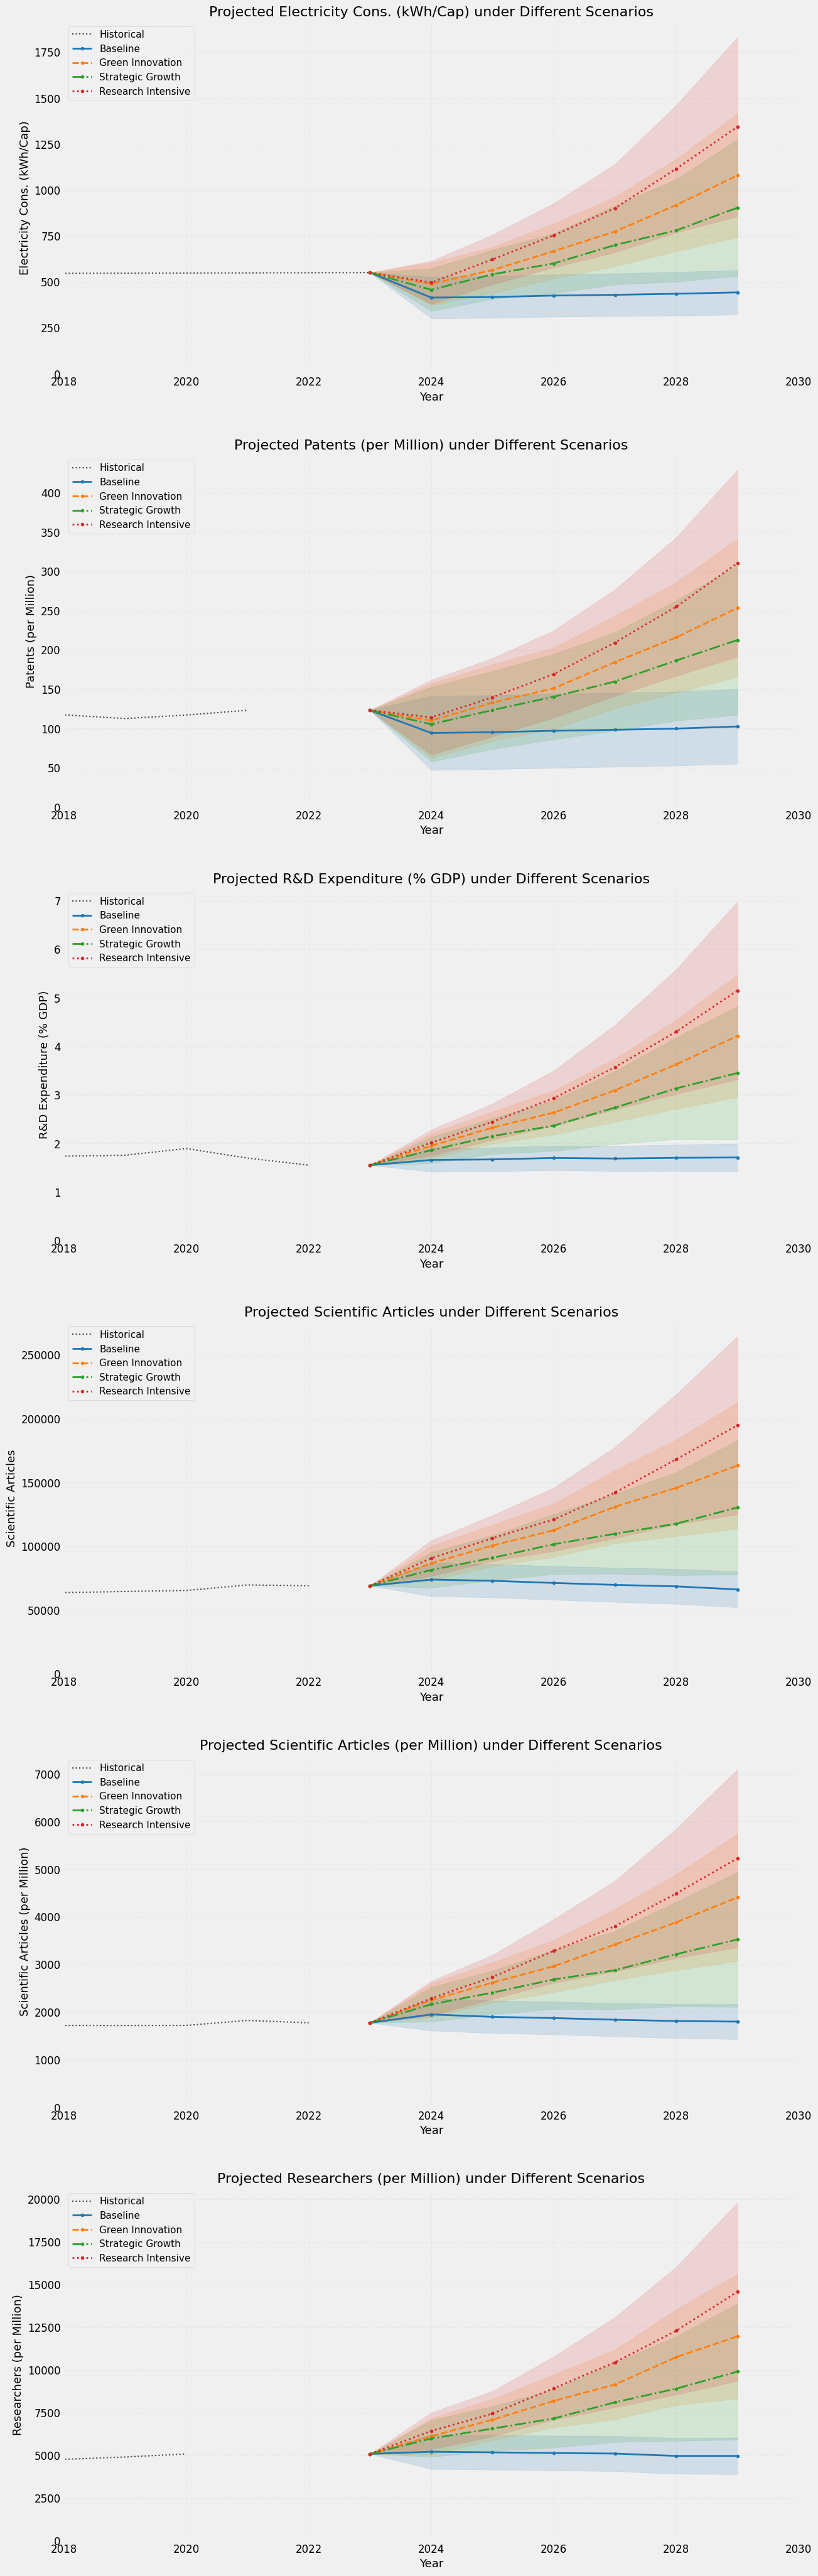

Visualization completed.

--- Calculating Economic Impacts ---
Using Patent->GDP Growth coefficient: 0.030598 (% growth per Patent/Million), p=0.504
Base economic calculation on GDP in 2023: $2142.5 B, Recent Avg TOTAL GDP Growth: 4.81%
Economic impact calculation completed.

Comprehensive analysis simulation finished.


In [ ]:
# Run Comprehensive Simulation
print("--- Running Comprehensive Policy Analysis ---")
simulation_results = {}
if model_creation_successful:
    try:
        if x_df_sim is None or x_df_sim.empty:
            raise ValueError("Input Energy DataFrame (x_df_sim) is missing.")

        simulation_results = simulator.run_comprehensive_analysis(
            energy_df=x_df_sim,
            innovation_models=sim_models,
            innovation_latest_values=sim_innovation_latest,
            innovation_historical_dfs=sim_innovation_dfs,
            gdp_df=sim_gdp_total_df,
            patent_gdp_model=sim_patent_gdp_model,
            lags=sim_lags,
            scenarios=sim_scenarios
        )
        print("\nComprehensive analysis simulation finished.")
    except Exception as e:
        print(f"\nAn error occurred during the simulation run: {e}")
        traceback.print_exc()
else:
    print("Skipping simulation run: Simulation setup failed (no valid models).")

In [ ]:
# Analyze Simulation Results - Economic Impacts
print("\n--- Analyzing Simulation Results: Economic Impacts ---")
economic_impacts_df = simulation_results.get('economic_impacts')
if economic_impacts_df is not None and not economic_impacts_df.empty:
    print(f"\nEstimated Economic Impacts Over {simulator.projection_horizon} Years (Relative to Baseline):")

    # Define columns to display and formatting
    horizon = simulator.projection_horizon
    display_cols = [
        'Scenario',
        'Patent_Increase_per_M',
        'Est_GDP_Growth_Increase_pp',
        f'Cumul_GDP_Gain_{horizon}yr_Percent',
        'GDP_Gain_Percent_Lower_CI', 'GDP_Gain_Percent_Upper_CI',
        # 'Est_Total_Investment',
        'Est_ROI_Ratio',
        'ROI_Lower_CI', 'ROI_Upper_CI'
    ]
    # Ensure columns exist before selecting/formatting
    display_cols = [col for col in display_cols if col in economic_impacts_df.columns]

    format_dict = {
        'Patent_Increase_per_M': '{:,.1f}',
        'Est_GDP_Growth_Increase_pp': '{:,.4f}%',
        f'Cumul_GDP_Gain_{horizon}yr_Percent': '{:,.2f}%',
        'GDP_Gain_Percent_Lower_CI': '{:,.2f}%',
        'GDP_Gain_Percent_Upper_CI': '{:,.2f}%',
        'Est_Total_Investment': '${:,.0f}',
        'Est_ROI_Ratio': '{:.1f}x',
        'ROI_Lower_CI': '{:.1f}x',
        'ROI_Upper_CI': '{:.1f}x',
    }
    format_dict_final = {k: v for k, v in format_dict.items() if k in display_cols}
    styled_impacts = economic_impacts_df[display_cols].style.format(format_dict_final)
    try:
        display(styled_impacts)
    except NameError:
        print(economic_impacts_df[display_cols].to_string(formatters=format_dict_final))

    print("\n--- Detailed Economic Impact Summary ---")
    for _, row in economic_impacts_df.iterrows():
        scenario = row['Scenario']
        pct_gain_col = f'Cumul_GDP_Gain_{horizon}yr_Percent'
        pct_gain = row[pct_gain_col] if pct_gain_col in row else np.nan
        pct_lower = row['GDP_Gain_Percent_Lower_CI'] if 'GDP_Gain_Percent_Lower_CI' in row else np.nan
        pct_upper = row['GDP_Gain_Percent_Upper_CI'] if 'GDP_Gain_Percent_Upper_CI' in row else np.nan
        roi = row['Est_ROI_Ratio'] if 'Est_ROI_Ratio' in row else np.nan
        roi_lower = row['ROI_Lower_CI'] if 'ROI_Lower_CI' in row else np.nan
        roi_upper = row['ROI_Upper_CI'] if 'ROI_Upper_CI' in row else np.nan
        print(f"\nScenario: {scenario}")
        if pd.notna(pct_gain):
            print(f"  - Est. Cumulative GDP Increase: {pct_gain:.2f}% (Approx. 90% CI: {pct_lower:.2f}% to {pct_upper:.2f}%)")
        if pd.notna(roi):
            print(f"  - Est. ROI Ratio: {roi:.1f}x investment (Approx. 90% CI: {roi_lower:.1f}x to {roi_upper:.1f}x)")
        if 'Patent_Increase_per_M' in row and pd.notna(row['Patent_Increase_per_M']):
            print(f"  - Based on Patent Increase: {row['Patent_Increase_per_M']:,.1f} per Million People")

    print(f"\nNote: Economic impacts are highly sensitive to the Patent->GDP model ({'used' if sim_patent_gdp_model else 'defaulted'}) coefficient and scenario assumptions.")
    print(f"Note: Confidence intervals for GDP Gain and ROI are approximate, based on coefficient p-value.")

elif 'economic_impacts' in simulation_results:
     print("Economic impact calculation did not produce results (check logs for reasons like missing data or baseline).")
else:
     print("Economic impact results not found in simulation output (simulation might have failed).")


--- Analyzing Simulation Results: Economic Impacts ---

Estimated Economic Impacts Over 6 Years (Relative to Baseline):



--- Detailed Economic Impact Summary ---

Scenario: Green Innovation
  - Est. Cumulative GDP Increase: 29.54% (Approx. 90% CI: 22.15% to 36.92%)
  - Est. ROI Ratio: 87.0x investment (Approx. 90% CI: 65.3x to 108.8x)
  - Based on Patent Increase: 151.0 per Million People

Scenario: Strategic Growth
  - Est. Cumulative GDP Increase: 20.87% (Approx. 90% CI: 15.65% to 26.09%)
  - Est. ROI Ratio: 69.2x investment (Approx. 90% CI: 51.9x to 86.5x)
  - Based on Patent Increase: 109.9 per Million People

Scenario: Research Intensive
  - Est. Cumulative GDP Increase: 42.39% (Approx. 90% CI: 31.79% to 52.99%)
  - Est. ROI Ratio: 102.2x investment (Approx. 90% CI: 76.6x to 127.7x)
  - Based on Patent Increase: 207.8 per Million People

Note: Economic impacts are highly sensitive to the Patent->GDP model (used) coefficient and scenario assumptions.
Note: Confidence intervals for GDP Gain and ROI are approximate, based on coefficient p-value.


In [ ]:
# Analyze Simulation Results - Innovation Projections
print("\n--- Analyzing Simulation Results: Innovation Projections ---")
projections_dict = simulation_results.get('projections')
if projections_dict:
    # Ensure base_year and horizon are correctly defined
    sim_base_year = simulator.base_year
    proj_horizon = simulator.projection_horizon
    end_year_proj = sim_base_year + proj_horizon
    print(f"\nProjected Values in {end_year_proj} (Relative to Baseline):")

    # Analyze specific metrics like Patents and R&D
    metrics_to_analyze = [name for name in y_names_for_reg if name in projections_dict] # Analyze metrics that were modeled
    for metric_name in metrics_to_analyze:
         proj_df = projections_dict.get(metric_name)
         if proj_df is None or proj_df.empty:
              print(f"\nProjections for '{metric_name}' are empty or missing.")
              continue

         if 'Baseline' in proj_df.columns:
              try:
                   baseline_end_value = proj_df.loc[end_year_proj, 'Baseline']
                   print(f"\n{metric_name}:")
                   print(f"  - Baseline Projection ({end_year_proj}): {baseline_end_value:,.2f}")

                   scenarios_available = [col for col in proj_df.columns if not col.endswith(('_lower', '_upper'))]
                   for scenario in scenarios_available:
                       if scenario != 'Baseline':
                           scenario_end_value = proj_df.loc[end_year_proj, scenario]
                           # Avoid division by zero if baseline is zero
                           pct_change = ((scenario_end_value / baseline_end_value - 1) * 100) if abs(baseline_end_value) > 1e-9 else np.nan
                           change_str = f"({pct_change:+.1f}% vs Baseline)" if pd.notna(pct_change) else "(Baseline near zero)"
                           print(f"  - {scenario} ({end_year_proj}): {scenario_end_value:,.2f} {change_str}")
              except KeyError:
                    print(f"  - Error accessing projected year {end_year_proj} for {metric_name}. Available years: {proj_df.index.min()}-{proj_df.index.max()}")
              except Exception as e:
                   print(f"  - Error processing {metric_name}: {e}")
         else:
              print(f"\nCannot compare {metric_name}: Baseline scenario missing in projections.")

    # Display first few rows of a projection table for inspection (e.g., Patents)
    patent_metric_name = 'Patents (per Million)'
    if patent_metric_name in projections_dict:
         print(f"\nSample Projection Data ({patent_metric_name}):")
         sample_df = projections_dict[patent_metric_name].head()
         try:
              display(sample_df)
         except NameError:
              print(sample_df)
else:
    print("Innovation projection results not found in simulation output (simulation might have failed).")


--- Analyzing Simulation Results: Innovation Projections ---

Projected Values in 2029 (Relative to Baseline):

Electricity Cons. (kWh/Cap):
  - Baseline Projection (2029): 442.28
  - Green Innovation (2029): 1,079.09 (+144.0% vs Baseline)
  - Strategic Growth (2029): 903.05 (+104.2% vs Baseline)
  - Research Intensive (2029): 1,343.58 (+203.8% vs Baseline)

Patents (per Million):
  - Baseline Projection (2029): 102.53
  - Green Innovation (2029): 253.51 (+147.3% vs Baseline)
  - Strategic Growth (2029): 212.47 (+107.2% vs Baseline)
  - Research Intensive (2029): 310.35 (+202.7% vs Baseline)

R&D Expenditure (% GDP):
  - Baseline Projection (2029): 1.71
  - Green Innovation (2029): 4.22 (+146.5% vs Baseline)
  - Strategic Growth (2029): 3.45 (+101.8% vs Baseline)
  - Research Intensive (2029): 5.15 (+201.3% vs Baseline)

Scientific Articles:
  - Baseline Projection (2029): 66,138.45
  - Green Innovation (2029): 163,300.37 (+146.9% vs Baseline)
  - Strategic Growth (2029): 130,417.53 (

Baseline  Baseline_lower  Baseline_upper  Green Innovation  \
Year                                                                 
2023  123.169894      123.169894      123.169894        123.169894   
2024   94.266792       47.027326      141.506258        110.047347   
2025   95.233859       48.109453      142.358264        132.838804   
2026   97.076755       49.997152      144.156358        151.104549   
2027   98.334113       51.222938      145.445287        184.433252   

      Green Innovation_lower  Green Innovation_upper  Strategic Growth  \
Year                                                                     
2023              123.169894              123.169894        123.169894   
2024               62.592649              157.502045        105.423084   
2025               84.115365              181.562244        123.388099   
2026               99.344861              202.864237        140.423993   
2027              125.465289              243.401214        159.723580   

      Strategic Growth_lower  Strategic Growth_upper  Research Intensive  \
Year                                                                       
2023              123.169894              123.169894          123.169894   
2024               57.771977              153.074191          114.142471   
2025               73.708223              173.067976          139.682568   
2026               86.143214              194.704772          169.228631   
2027               97.173621              222.273540          209.253982   

      Research Intensive_lower  Research Intensive_upper  
Year                                                      
2023                123.169894                123.169894  
2024                 66.537404                161.747537  
2025                 89.960781                189.404354  
2026                113.771637                224.685624  
2027                141.500126                277.007839

These projections directly reflect the combined effects of the energy pathway and the scenario-specific boosts/feedbacks defined in the simulation parameters.


## Conclusion & Next Steps

**Summary of Findings:**

*   **(EDA):** Briefly summarize key trends observed for G7+China and Canada (high Canadian energy use, China's rise in R&D/patents).
*   **(Correlation - Canada):** Summarize the main correlations found between electricity consumption and innovation metrics in Canada (sign, strength, significance).
*   **(Canada vs. US):** Recap the major findings from the gap analysis ( Canada lags in patents/R&D, leads/lags in efficiency, trends in gaps).
*   **(Regression - Canada):** Note the statistical significance and direction of the relationship found between electricity and innovation metrics in the simple OLS models.
*   **(Simulation):** Summarize which policy scenarios project the largest increases in innovation metrics (e.g., patents, R&D) and estimated economic benefits (GDP gain, ROI), relative to the baseline. Highlight the top-performing scenarios.

**Limitations:**

*   **Data:** Data availability, potential inaccuracies in reported data, use of proxy indicators. Electricity data forecasting adds uncertainty.
*   **Models:** Simple linear regression models used may not capture complex, non-linear relationships. Correlation does not imply causation.
*   **Simulation:** Scenario parameters are illustrative and carry uncertainty. Economic impact calculation relies on a very simplified Patent->GDP link and fixed coefficients. Uncertainty quantification is approximate. External shocks or structural changes are not modeled.
*   **Scope:** Focuses primarily on electricity consumption; other energy sources and broader economic/policy factors are not included in the core models.

**Potential Future Work:**

*   Incorporate more granular energy data (industrial vs. residential, energy source mix).
*   Use more sophisticated time series models (ARIMA) to better capture dynamics and potential causality.
*   Include additional control variables in regression models (education levels, FDI).
*   Develop more complex economic impact models (CGE models).
*   Refine simulation parameters based on specific policy details or expert input.
*   Perform sensitivity analysis on simulation assumptions and model coefficients.
*   Analyze data for other countries or regions in more detail.